7/5/2019

I'll use the S0 model to score an utterance given the same target color across all three conditions and see how well this predicts the condition the utterance was created in.

The first step is to create the color contexts. This means for each target, generate the two conditions that it doesn't appear in. I want to first check and see if these already exist somewhere.

In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [99]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
import caption_featurizers                              # for getting caption representations
import color_featurizers                                # for getting color representations
from experiment import FeatureHandler                   # for combining caption and color features

from models import PytorchModel, ConditionPredictor, ColorEncoder, LiteralSpeakerScorer, CaptionGenerator  # model base that handles training / evaluation

In [219]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import copy
import pandas as pd
from functools import partial

In [334]:
%matplotlib inline
plt.style.use("ggplot")

In [480]:
import importlib
import models
importlib.reload(models)
from models import PytorchModel, ConditionPredictor, ColorEncoder, LiteralSpeakerScorer, CaptionGenerator  # model base that handles training / evaluation

In [4]:
# get data
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [9]:
train_data[0].colors[0].hsl

[226, 81, 50]

In [12]:
all_train_target_hsl = [train_data[i].colors[0].hsl for i in range(len(train_data))]

In [13]:
all_train_target_hsl[:10]

[[226, 81, 50],
 [249, 25, 50],
 [301, 57, 50],
 [87, 66, 50],
 [156, 84, 50],
 [40, 7, 50],
 [82, 9, 50],
 [108, 16, 50],
 [5, 45, 50],
 [215, 13, 50]]

In [22]:
all_train_target_hsl_str = [str(hsl) for hsl in all_train_target_hsl]

In [23]:
train_hsl_counts = Counter(all_train_target_hsl_str)

In [27]:
train_hsl_counts.most_common()

[('[276, 48, 50]', 5),
 ('[322, 74, 50]', 4),
 ('[254, 13, 50]', 4),
 ('[70, 43, 50]', 4),
 ('[114, 29, 50]', 4),
 ('[244, 29, 50]', 4),
 ('[282, 43, 50]', 4),
 ('[162, 9, 50]', 4),
 ('[245, 40, 50]', 4),
 ('[32, 9, 50]', 4),
 ('[234, 74, 50]', 4),
 ('[280, 89, 50]', 4),
 ('[112, 29, 50]', 4),
 ('[65, 6, 50]', 4),
 ('[20, 47, 50]', 4),
 ('[272, 4, 50]', 4),
 ('[39, 24, 50]', 4),
 ('[303, 69, 50]', 4),
 ('[278, 43, 50]', 4),
 ('[311, 49, 50]', 4),
 ('[142, 39, 50]', 4),
 ('[336, 32, 50]', 4),
 ('[318, 3, 50]', 4),
 ('[58, 37, 50]', 4),
 ('[224, 66, 50]', 4),
 ('[119, 79, 50]', 4),
 ('[211, 88, 50]', 4),
 ('[62, 94, 50]', 4),
 ('[163, 34, 50]', 4),
 ('[229, 65, 50]', 4),
 ('[285, 78, 50]', 4),
 ('[156, 45, 50]', 4),
 ('[212, 19, 50]', 4),
 ('[254, 44, 50]', 4),
 ('[355, 14, 50]', 4),
 ('[115, 30, 50]', 4),
 ('[84, 31, 50]', 4),
 ('[320, 68, 50]', 4),
 ('[257, 19, 50]', 4),
 ('[94, 67, 50]', 4),
 ('[51, 88, 50]', 4),
 ('[116, 40, 50]', 4),
 ('[255, 22, 50]', 4),
 ('[124, 28, 50]', 4),
 ('

In [47]:
potential_hsls = [hsl for hsl, count in train_hsl_counts.most_common() if count >=3]

In [48]:
len(potential_hsls)

402

In [51]:
all_conditions_set = set(['close', 'split', 'far'])

all_conditions_hsl = []

for phsl in potential_hsls:
    # get indices from full list
    train_data_idxs = [i for i, hsl in enumerate(all_train_target_hsl_str) if hsl == phsl]
    phsl_conditions = [train_data[i].condition for i in train_data_idxs]
    if set(phsl_conditions) == all_conditions_set:
        all_conditions_hsl.append({phsl_conditions[i]: train_data_idxs[i] for i in range(len(train_data_idxs))})

In [53]:
len(all_conditions_hsl)

89

In [55]:
all_conditions_hsl[:10]

[{'close': 12209, 'far': 15406, 'split': 11903},
 {'close': 9495, 'far': 1121, 'split': 3035},
 {'close': 14815, 'far': 10777, 'split': 14835},
 {'close': 6855, 'far': 4536, 'split': 11327},
 {'close': 10660, 'far': 1655, 'split': 13996},
 {'close': 8806, 'far': 5863, 'split': 12091},
 {'close': 3666, 'far': 10573, 'split': 5688},
 {'close': 11206, 'far': 14859, 'split': 3947},
 {'close': 9166, 'far': 14022, 'split': 11811},
 {'close': 5045, 'far': 11773, 'split': 13377}]

Ok, so there are only 89 colors in the training data that are associated with contexts across all three conditions...
this means that I would have a total of 89*3=267 samples. This isn't really fair to compare to the 15,000 from the other data, so I'm going to have to generate distractors. That said, it does provide a good set to test things on, so I'll use it to develop the prediction framework now

In [220]:
# this is going to be pretty standard I think - let's start with character features

# define feature functions
caption_phi_character = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.CharacterTokenizer)

# we use a color featurizer because the code was designed to always use both color and text features. These 
# features will just be ignored in the model code
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True)

# speaker's target is to predict tokens following the SOS token
def speaker_target(data_entry, caption_phi):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target

speaker_target_character = partial(speaker_target, caption_phi=caption_phi_character)

Scratch that - actually this isn't going to be standard because the input is a list of 3 color contexts. I'm not sure the feature handler can handle that. 

Ok, so upon further investigation, it looks like if we messed around with the data object, it could, but that would be very bad style. Instead I think what we should do is run the s0 speaker on all of the caption, context pairs and then do the normalization separately. I think that's probably the best way forward.

That means the first step is to create a data_entry list using just the entries we have, substituting in the captions

In [95]:
# here our target function is the speaker target so that we can easily extract the probability of the sentence
# train data is our train_data, so the character to index map matches what the speaker model was trained on
feature_handler_character = FeatureHandler(train_data, small_train_all_conditions_data,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)



In [96]:
X_train = feature_handler_character.train_features()
y_train = feature_handler_character.train_targets()

In [97]:
X_assess = feature_handler_character.test_features()
y_assess = feature_handler_character.test_targets()

In [481]:
# set up model
s0_character = LiteralSpeakerScorer(CaptionGenerator)
s0_character.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_character.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_character.load_model("../model/character_literal_speaker_full_context.params")

In [104]:
def output_to_score_lss(outputs, targets):
    all_scores = []
    for i, predictions in enumerate(outputs):
        scores = [0, 0, 0]
        for j, prediction in enumerate(predictions):
            scores[j] = np.sum(prediction[np.arange(len(targets[i])), targets[i]].numpy())
        all_scores.append(scores)
    return np.argmax(all_scores, axis=1) == 0

In [125]:
def output_to_likelihood(outputs, targets, target_idx=0):
    all_likelihoods = []
    for i, predictions in enumerate(outputs):
        log_prob = np.sum(predictions[target_idx][np.arange(len(targets[i])), targets[i]].numpy())
        all_likelihoods.append(log_prob)
            
    return np.array(all_likelihoods)

In [700]:
def reshape_sample_list(samples, num_samples):
    rounds_per_condition = 2 * num_samples + 1
    num_conditions = 3
    
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] => [[0, 1, 2, 3, 4],
    #                                    [5, 6, 7, 8, 9]]]
    samples = samples.reshape(-1, rounds_per_condition)
    
    # target_values = [0, 5]
    target_values = samples[:, 0]
    target_values = np.repeat(target_values, num_samples)
    
    # [[0, 1, 2, 3, 4],    [[1, 2],
    #  [5, 6, 7, 8, 9]] =>  [3, 4],
    #                       [6, 7],
    #                       [8, 9]]
    samples_generated = samples[:, 1:].reshape((-1, num_conditions - 1)) # group into pairs of context
    samples_all = np.insert(samples_generated, 0, target_values, axis=1)
    
    return samples_all

    

def likelihood_to_predictions(likelihoods, num_samples=1):
    # likelihoods is a 1d list, but every rounds_per_condition items represents a different set of conditions to 
    # softmax over. We don't care about the probabilities right now, however, so we just report the argmax of the
    # likelihoods from each rounds_per_condition rounds
    
    likelihoods_all = reshape_sample_list(likelihoods, num_samples)
    predictions = np.argmax(likelihoods_all, axis=1)
    
    
    
    
#     likelihoods = likelihoods.reshape(-1, rounds_per_condition)
#     predictions = np.argmax(likelihoods, axis=1)
    
    # predictions = np.empty(len(likelihoods) // rounds_per_condition, dtype=np.int)
    
#     for i in range(len(likelihoods) // rounds_per_condition):
#         # get all of the likelihoods for the ith target
#         same_target = likelihoods[i * rounds_per_condition : (i + 1) * rounds_per_condition]
        
#         # get all 
#         all_repeated_rounds = np.insert(same_target[1:].reshape(-1, num_conditions - 1), 0, same_target[0], axis=1)
#         maxes = np.argmax(all_repeated_rounds, axis=1)
#         predictions[num_conditions * i : num_conditions * (i + 1)] = mins
    
    # return predictions in index form
    return predictions

In [634]:
a = np.array([1, 2, 3, 22, 222, 33, 333, 4, 5, 6, 55, 66, 555, 666])

In [701]:
likelihood_to_predictions(a, 3)

array([2, 2, 2, 2, 2, 2])

In [636]:
ap = np.reshape(a, (-1, 2*3 + 1))

In [637]:
a

array([  1,   2,   3,  22, 222,  33, 333,   4,   5,   6,  55,  66, 555,
       666])

In [653]:
preds = np.empty(6,dtype=np.int)
for i in range(2):
    rounds_per_condition = 2 * 3 + 1
    tempa = a[i*rounds_per_condition: (i+1) * rounds_per_condition]
    tempap = np.insert(tempa[1:].reshape(-1, 2), 0, tempa[0], axis=1)
    mins = np.argmin(tempap, axis=1)
    print(mins)
    preds[3*i: 3*(i+1)] = mins

[0 0 0]
[0 0 0]


In [655]:
a.reshape((-1, 2*3+1))

array([[  1,   2,   3,  22, 222,  33, 333],
       [  4,   5,   6,  55,  66, 555, 666]])

In [657]:
ap

array([[  1,   2,   3,  22, 222,  33, 333],
       [  4,   5,   6,  55,  66, 555, 666]])

In [673]:
begin = ap[:, 0]

In [674]:
begin

array([1, 4])

In [661]:
beginp = begin.reshape(-1, 1)

In [662]:
beginp

array([[1],
       [4]])

In [675]:
np.repeat(begin, 3)

array([1, 1, 1, 4, 4, 4])

In [676]:
app = ap[:, 1:].reshape(-1, 2)

In [678]:
np.insert(app, 0, np.repeat(begin, 3), axis=1)

array([[  1,   2,   3],
       [  1,  22, 222],
       [  1,  33, 333],
       [  4,   5,   6],
       [  4,  55,  66],
       [  4, 555, 666]])

In [654]:
preds

array([0, 0, 0, 0, 0, 0])

In [606]:
ap[:, [0, 1, 2]]

array([[1, 2, 3],
       [4, 5, 6]])

In [621]:
np.take(ap, [[0, 1, 2], [0, 3, 4]], axis=1)

array([[[ 1,  2,  3],
        [ 1, 22, 33]],

       [[ 4,  5,  6],
        [ 4, 55, 66]]])

In [624]:
b = np.array([0, 1, 2, 3, 4])

In [625]:
b

array([0, 1, 2, 3, 4])

In [632]:
np.insert(b[1:].reshape(-1, 2), 0, 0, axis=1)

array([[0, 1, 2],
       [0, 3, 4]])

In [622]:
np.take(ap, [[0, 1, 2], [0, 3, 4]], axis=1).reshape(-1, 3)

array([[ 1,  2,  3],
       [ 1, 22, 33],
       [ 4,  5,  6],
       [ 4, 55, 66]])

In [666]:
app = np.reshape(ap[:, 1:], (-1, 2, 2))

In [667]:
app

array([[[  2,   3],
        [ 22, 222]],

       [[ 33, 333],
        [  5,   6]],

       [[ 55,  66],
        [555, 666]]])

In [570]:
ap[:, 0], app

(array([1, 4]), array([[[ 2,  3],
         [22, 33]],
 
        [[ 5,  6],
         [55, 66]]]))

In [593]:
for i in range(2):
    print(np.insert(app[i], 0, ap[:, 0][i], axis=1))

[[ 1  2  3]
 [ 1 22 33]]
[[ 4  5  6]
 [ 4 55 66]]


In [ ]:
np.reshape

In [185]:
import pandas as pd

In [196]:
small_train_all_conditions_data = []
small_train_all_conditions_data_df = pd.DataFrame(index=list(range(len(small_train_all_conditions_data))), columns=train_data.data.columns)

entry_counter = 0
for triple in all_conditions_hsl:
    for condition, i in triple.items():
        # update caption in each condition's data entry to be the caption in each condition (this makes no sense)
        caption = train_data[i].caption
        
        # the first entry of the three will be the correct condition. The correct condition will always be at index 0
        new_data_entry = copy.deepcopy(train_data[i])
        small_train_all_conditions_data.append(new_data_entry)
        
        small_train_all_conditions_data_df.loc[entry_counter] = train_data.data.loc[i]
        small_train_all_conditions_data_df.loc[entry_counter, "contents"] = caption
        small_train_all_conditions_data_df.loc[entry_counter, "condition_group"] = condition
        entry_counter += 1
        
        
        for j in triple.values():
            if j == i: continue

            new_data_entry = copy.deepcopy(train_data[j])
            new_data_entry.caption = caption
            
            # data identical except for caption
            small_train_all_conditions_data.append(new_data_entry)
            small_train_all_conditions_data_df.loc[entry_counter] = train_data.data.loc[j]
            small_train_all_conditions_data_df.loc[entry_counter, "contents"] = caption
            small_train_all_conditions_data_df.loc[entry_counter, "condition_group"] = condition
            entry_counter += 1

        

In [197]:
small_train_all_conditions_data_df

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source,condition_group
0,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,dark purple,853.0,1.0,2,10,10.0,2.0,human,far
1,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,dark purple,258.0,1.0,1,4,4.0,1.0,human,far
2,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,dark purple,777.0,0.0,2,14,14.0,2.0,human,far
3,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,purp,258.0,1.0,1,4,4.0,1.0,human,split
4,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,purp,853.0,1.0,2,10,10.0,2.0,human,split
5,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,purp,777.0,0.0,2,14,14.0,2.0,human,split
6,6035-4,1.476482e+12,12,close,distr2,324,60,50,3,1,...,speaker,brighter purple,777.0,0.0,2,14,14.0,2.0,human,close
7,9202-f,1.476490e+12,40,far,target,276,48,50,2,2,...,speaker,brighter purple,853.0,1.0,2,10,10.0,2.0,human,close
8,8514-f,1.476481e+12,3,split,target,276,48,50,3,1,...,speaker,brighter purple,258.0,1.0,1,4,4.0,1.0,human,close
9,7584-c,1.459885e+12,28,far,target,244,29,50,3,3,...,speaker,purple,NaN,1.0,1,6,6.0,1.0,human,far


In [198]:
small_train_all_conditions_data_df.to_csv("../data/csv/train_corpus_condition_pred_small.csv", header=True, index=False)

In [199]:
import pickle as pkl
with open("../data/entries/train_entries_condition_pred_small.pkl", "wb") as pkl_file:
    pkl.dump(small_train_all_conditions_data, pkl_file)

In [200]:
# load in data
train_cp_data_small = MonroeData("../data/csv/train_corpus_condition_pred_small.csv", "../data/entries/train_entries_condition_pred_small.pkl")

In [201]:
feature_handler_character_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)

In [202]:
X_assess = feature_handler_character_test.test_features()
y_assess = feature_handler_character_test.test_targets()

In [681]:
len(cp_likelihood)

46995

In [682]:
cp_preds_idx_test = likelihood_to_predictions(cp_likelihood)



In [685]:
all(cp_preds_idx_test == cp_preds_idx)

True

In [213]:
cp_outputs = s0_character.predict(X_assess)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [218]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.50      0.43      0.46        89
         far       0.56      0.64      0.60        89
       split       0.48      0.48      0.48        89

   micro avg       0.52      0.52      0.52       267
   macro avg       0.51      0.52      0.51       267
weighted avg       0.51      0.52      0.51       267



In [482]:
# out of curiosity, let's try with a different tokenizer - endings tokenizer:
# set up feature handler
caption_phi_endings = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.EndingTokenizer)
speaker_target_endings = partial(speaker_target, caption_phi=caption_phi_endings)

feature_handler_endings_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_endings, color_phi, target_fn=speaker_target_endings,
                                 randomized_colors=False)

# set up model
s0_endings = LiteralSpeakerScorer(CaptionGenerator)
s0_endings.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_endings_test.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_endings.load_model("../model/literal_speaker_30epochGLOVE.params")

In [223]:
X_assess_endings = feature_handler_endings_test.test_features()
y_assess_endings = feature_handler_endings_test.test_targets()

In [224]:
cp_outputs = s0_endings.predict(X_assess_endings)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess_endings)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [225]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.40      0.40      0.40        89
         far       0.53      0.58      0.56        89
       split       0.49      0.44      0.46        89

   micro avg       0.48      0.48      0.48       267
   macro avg       0.47      0.48      0.47       267
weighted avg       0.47      0.48      0.47       267



In [483]:
# out of curiosity, once more let's try with a different tokenizer - subword tokenizer:
# set up feature handler
caption_phi_subword = caption_featurizers.CaptionFeaturizer(tokenizer = caption_featurizers.SentencePieceTokenizer)
speaker_target_subword = partial(speaker_target, caption_phi=caption_phi_subword)

feature_handler_subword_test = FeatureHandler(train_data, train_cp_data_small,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword,
                                 randomized_colors=False)

# set up model
s0_subword = LiteralSpeakerScorer(CaptionGenerator)
s0_subword.init_model(color_in_dim=54, color_dim=100,
                 vocab_size=feature_handler_subword_test.caption_featurizer.caption_indexer.size, embed_dim=100,
                 speaker_hidden_dim=100)
s0_subword.load_model("../model/subword100_literal_speaker_full_context.params")

In [227]:
X_assess_subword = feature_handler_subword_test.test_features()
y_assess_subword = feature_handler_subword_test.test_targets()

In [228]:
cp_outputs = s0_subword.predict(X_assess_subword)

cp_likelihood = output_to_likelihood(cp_outputs, y_assess_subword)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data_small])
cp_preds_str = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

In [229]:
print(classification_report(cp_truth_str, cp_preds_str))

              precision    recall  f1-score   support

       close       0.53      0.57      0.55        89
         far       0.56      0.56      0.56        89
       split       0.50      0.46      0.48        89

   micro avg       0.53      0.53      0.53       267
   macro avg       0.53      0.53      0.53       267
weighted avg       0.53      0.53      0.53       267



In [362]:
# now let's try with the entire training set:
train_cp_data = MonroeData("../data/csv/train_corpus_condition_prediction.csv", "../data/entries/train_entries_condition_prediction.pkl")
#train_cp_data2 = train_cp_data

In [363]:
feature_handler_character_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_character, color_phi, target_fn=speaker_target_character, 
                                 randomized_colors=False)

In [364]:
X_assess_character_cp = feature_handler_character_cp.test_features()
y_assess_character_cp = feature_handler_character_cp.test_targets()

In [487]:
%%time
cp_outputs_character = s0_character.predict(X_assess_character_cp)

cp_likelihood = output_to_likelihood(cp_outputs_character, y_assess_character_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_character = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 4min 23s, sys: 40.7 s, total: 5min 4s
Wall time: 4min 41s


In [488]:
print("Character Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_character))

Character Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.47      0.47      0.47      5159
         far       0.53      0.57      0.55      5265
       split       0.45      0.42      0.43      5241

   micro avg       0.49      0.49      0.49     15665
   macro avg       0.48      0.49      0.48     15665
weighted avg       0.48      0.49      0.48     15665



In [368]:
feature_handler_endings_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_endings, color_phi, target_fn=speaker_target_endings, 
                                 randomized_colors=False)

X_assess_endings_cp = feature_handler_endings_cp.test_features()
y_assess_endings_cp = feature_handler_endings_cp.test_targets()

In [489]:
%%time
cp_outputs_endings = s0_endings.predict(X_assess_endings_cp)

cp_likelihood = output_to_likelihood(cp_outputs_endings, y_assess_endings_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
#cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_endings = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

#cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 8min 24s, sys: 37.1 s, total: 9min 1s
Wall time: 6min 24s


In [490]:
print("Ending Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_endings))

Ending Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.48      0.50      0.49      5159
         far       0.57      0.58      0.57      5265
       split       0.45      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [370]:
print("Ending Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_endings))

Ending Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.48      0.50      0.49      5159
         far       0.57      0.58      0.57      5265
       split       0.45      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [240]:
print("Ending Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_endings))

              precision    recall  f1-score   support

       close       0.52      0.60      0.55      5159
         far       0.53      0.50      0.52      5265
       split       0.48      0.43      0.46      5241

   micro avg       0.51      0.51      0.51     15665
   macro avg       0.51      0.51      0.51     15665
weighted avg       0.51      0.51      0.51     15665



In [460]:
feature_handler_subword_cp = FeatureHandler(train_data, train_cp_data,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword, 
                                 randomized_colors=False)

# X_train_subword_cp = feature_handler_subword_cp.test_features()
# y_train_subword_cp = feature_handler_subword_cp.test_targets()

X_assess_subword_cp = feature_handler_subword_cp.test_features()
y_assess_subword_cp = feature_handler_subword_cp.test_targets()

In [491]:
%%time
cp_outputs_subword = s0_subword.predict(X_assess_subword_cp)

cp_likelihood = output_to_likelihood(cp_outputs_subword, y_assess_subword_cp)

cp_preds_idx = likelihood_to_predictions(cp_likelihood)

# to get them in string form:
#cp_all_conds_str = np.array([de.condition for de in train_cp_data])
cp_preds_str_subword = cp_all_conds_str.reshape(-1, 3)[list(range(len(cp_preds_idx))), cp_preds_idx]

#cp_truth_str = cp_all_conds_str[::3] # assuming that the first position in every group of 3 is the correct one

CPU times: user 2min 51s, sys: 25.3 s, total: 3min 16s
Wall time: 3min 6s


In [492]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

Subword Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.49      0.54      0.51      5159
         far       0.56      0.55      0.56      5265
       split       0.46      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [373]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

Subword Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.49      0.54      0.51      5159
         far       0.56      0.55      0.56      5265
       split       0.46      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [360]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

Subword Predictions (Augmented Train Data)
              precision    recall  f1-score   support

       close       0.49      0.54      0.51      5159
         far       0.56      0.55      0.56      5265
       split       0.46      0.43      0.44      5241

   micro avg       0.50      0.50      0.50     15665
   macro avg       0.50      0.50      0.50     15665
weighted avg       0.50      0.50      0.50     15665



In [245]:
print("Subword Predictions (Augmented Train Data)")
print(classification_report(cp_truth_str, cp_preds_str_subword))

              precision    recall  f1-score   support

       close       0.51      0.63      0.56      5159
         far       0.53      0.48      0.50      5265
       split       0.48      0.42      0.44      5241

   micro avg       0.51      0.51      0.51     15665
   macro avg       0.51      0.51      0.50     15665
weighted avg       0.51      0.51      0.50     15665



In [272]:
def display_round(roundnum):
    start = roundnum * 3
    for i in range(start, start+3):
        print(train_cp_data.data.condition[i])
        train_cp_data.display_game(i)

close
0) Game: 1124-1_0 Round: 1
The darker blue one


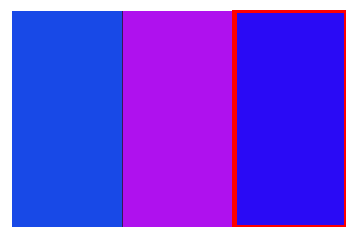

split
1) Game: 1124-1_1 Round: 1
The darker blue one


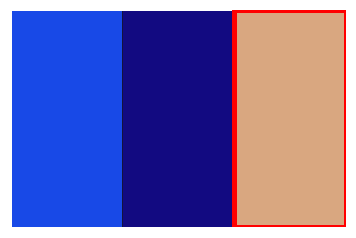

far
2) Game: 1124-1_2 Round: 1
The darker blue one


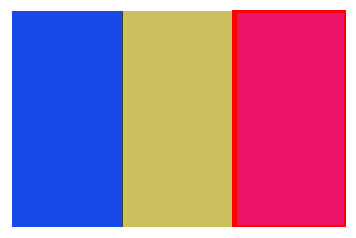

In [374]:
display_round(0)

far
3) Game: 1124-1_0 Round: 2
purple


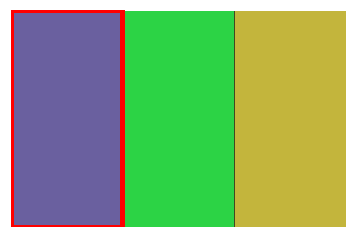

close
4) Game: 1124-1_1 Round: 2
purple


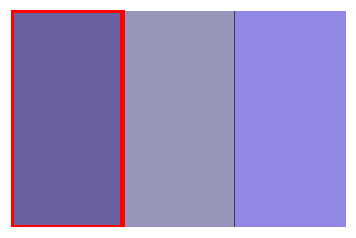

split
5) Game: 1124-1_2 Round: 2
purple


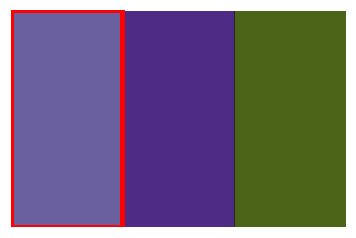

In [375]:
display_round(1)

In [724]:
incorrect_inds = np.where(cp_preds_str_subword != cp_truth_str)

In [725]:
incorrect_inds = incorrect_inds[0]

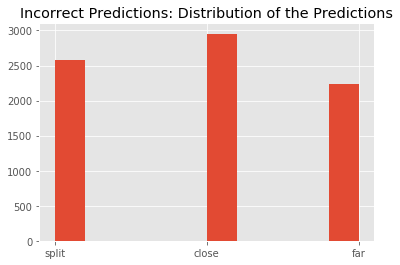

In [378]:
plt.hist(cp_preds_str_subword[incorrect_inds])
plt.title("Incorrect Predictions: Distribution of the Predictions")
plt.show()

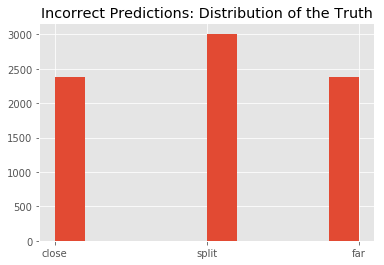

In [379]:
plt.hist(cp_truth_str[incorrect_inds])
plt.title("Incorrect Predictions: Distribution of the Truth")
plt.show()

So it looks like the biggest performance hit comes from predicting that colors in the split condition are actually in the close condition. I suppose this kind of makes sense though.

In [726]:
incorrect_inds[:10]

array([ 0,  3,  4,  6,  7,  8, 12, 16, 18, 19])

In [727]:
cp_preds_str_subword[incorrect_inds][:10]

array(['split', 'close', 'split', 'close', 'far', 'close', 'close',
       'split', 'far', 'far'], dtype='<U5')

In [728]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[3*3:3*3+1], y_assess_subword_cp[3*3:3*3+1], target_idx=t)))

0 [0.01845559]
1 [0.00025836]
2 [9.3926775e-07]


In [730]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[3*3+1:3*3+2], y_assess_subword_cp[3*3+1:3*3+2], target_idx=t)))

0 [0.02312811]
1 [0.00158372]
2 [0.0261943]


In [731]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[3*3+2:3*3+3], y_assess_subword_cp[3*3+2:3*3+3], target_idx=t)))

0 [0.00170699]
1 [2.7772765e-08]
2 [2.3045708e-07]


In [729]:
train_cp_data[9]

lime

split
9) Game: 1124-1_0 Round: 4
lime


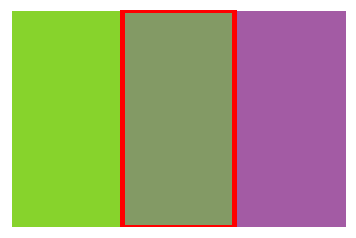

close
10) Game: 1124-1_1 Round: 4
lime


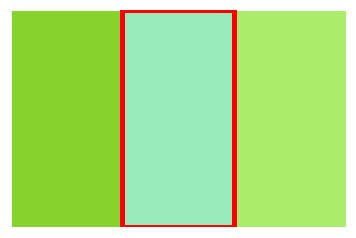

far
11) Game: 1124-1_2 Round: 4
lime


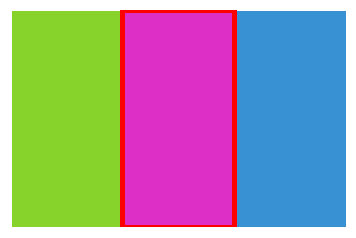

In [380]:
display_round(3)

far
12) Game: 1124-1_0 Round: 5
Mint green.


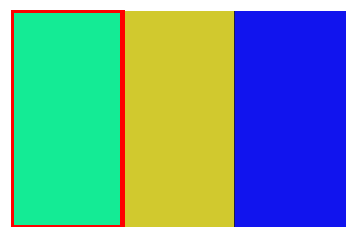

close
13) Game: 1124-1_1 Round: 5
Mint green.


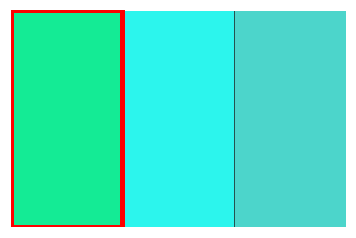

split
14) Game: 1124-1_2 Round: 5
Mint green.


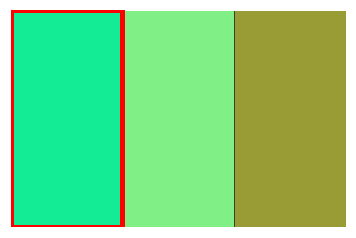

In [721]:
display_round(4)

split
18) Game: 1124-1_0 Round: 7
Mud brown


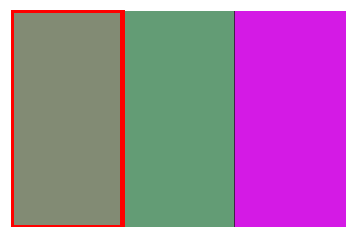

close
19) Game: 1124-1_1 Round: 7
Mud brown


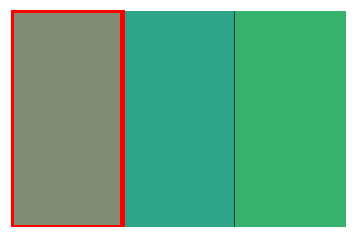

far
20) Game: 1124-1_2 Round: 7
Mud brown


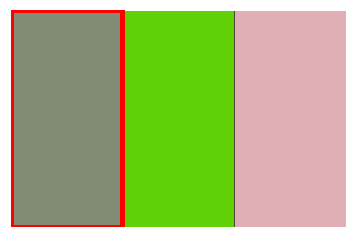

In [722]:
display_round(6)

In [383]:
cp_likelihood_subword = np.exp(((cp_likelihood.reshape(-1, 3).T) - logsumexp(cp_likelihood.reshape(-1, 3), axis=1)).T)

In [723]:
cp_likelihood_subword[0] # I don't understand why there's so much mass on the split condition when the caption is actually very bad for the split condition


array([0.26738313, 0.7301651 , 0.00245202], dtype=float32)

close
0) Game: 1124-1_0 Round: 1
The darker blue one


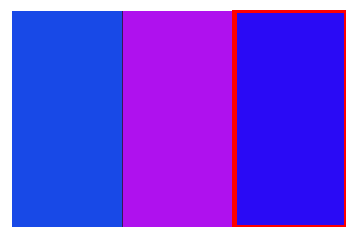

split
1) Game: 1124-1_1 Round: 1
The darker blue one


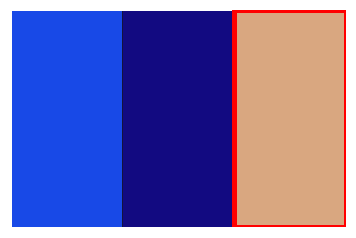

far
2) Game: 1124-1_2 Round: 1
The darker blue one


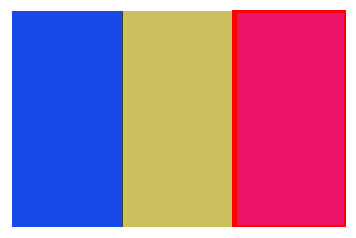

In [425]:
display_round(0)

In [493]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[:1], y_assess_subword_cp[:1], target_idx=t)))

0 [3.5869187e-05]
1 [2.512603e-07]
2 [8.389205e-05]


In [494]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[1:2], y_assess_subword_cp[1:2], target_idx=t)))

0 [9.795094e-05]
1 [1.0868283e-05]
2 [2.8996078e-07]


In [496]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[2:3], y_assess_subword_cp[2:3], target_idx=t)))

0 [3.2893635e-07]
1 [8.6516775e-07]
2 [1.3924568e-08]


The above ordering makes 0 sense to me. Like why should the tan color have a higher probability for "the darker blue one" than the one that's actually blue? Why is the probability of "the darker blue one" so low for the blue in this scenario? I'm pretty sure this isn't a bug and that it's actually something that's out of distribution? It's weird. It might have to do with the fact that the word "darker" is it's own vocab item in the byte pair encoding, but it doesn't appear as often, so it's not getting the benefit of being associated with the word "dark" or something, I'm not totally sure.

One way to test this would be to take a look at say the ending tokenizer (which strips away the "-er" suffix)

In [552]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_endings[2:3], y_assess_endings_cp[2:3], target_idx=t)))

0 [3.6384077e-07]
1 [3.9625716e-09]
2 [2.2686943e-11]


Ok, so in the above cell, we have the probability associated with the phrase "the darker blue" with the blue, tan, and red being the target respectively. The incorrect ordering in the subword data is probably an artefact of the bpe tokenization. My guess is that "darker" is just common enough to be its own vocab item. If I restrict the bpe vocab to say 80 tokens instead of 100, this might work effectively for this particular case.

In [503]:
test_entry = X_assess_subword_cp[2]

In [504]:
test_entry

[array([0, 1, 2, 3, 4, 5]),
 array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
         -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
          0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
         -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
          0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
         -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
         -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
          0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
          0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
         -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
          0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
        [ 1.        , -0.8073518 ,  0.303634  , -0.07325519, -0.52934223,
          0.9279861 , -0.98926735,  0.884906  , -0.43959358,  0.60181504,
         -0.9571276 , 

In [532]:
feature_handler_subword_cp.caption_featurizer.to_string_features("the blue one")

(array(['<sos>', '▁the', '▁blue', '▁one', '<eos>'], dtype='<U5'),
 array([0, 1, 3, 4, 5]))

In [533]:
test_entry[0] = feature_handler_subword_cp.caption_featurizer.to_string_features("the blue one")[1]

In [513]:
test_entry

[array([0, 3, 5]),
 array([[ 1.        , -0.955793  ,  0.82708055, -0.94611347,  0.809068  ,
         -0.6004896 ,  0.7902614 , -0.5751473 ,  0.30918208, -0.6946584 ,
          0.8754645 , -0.9788674 ,  0.89017326, -0.98479265,  0.99234265,
         -0.98975146,  0.9879867 , -0.8988701 , -0.0348995 , -0.2605045 ,
          0.53287625, -0.29061916,  0.55912095, -0.77818865,  0.5848169 ,
         -0.7974792 ,  0.93963325,  0.        , -0.29404032,  0.56208336,
         -0.3238353 ,  0.587715  , -0.79963255,  0.6127699 , -0.8180499 ,
          0.9510029 ,  0.7193398 , -0.4832824 ,  0.20449606, -0.45562217,
          0.17373364,  0.12351536,  0.14280072,  0.1545389 , -0.43821514,
         -0.99939084,  0.96547264, -0.8461932 ,  0.9568388 , -0.8290861 ,
          0.6280306 , -0.81116533,  0.6033464 , -0.34218323],
        [ 1.        , -0.8073518 ,  0.303634  , -0.07325519, -0.52934223,
          0.9279861 , -0.98926735,  0.884906  , -0.43959358,  0.60181504,
         -0.9571276 ,  0.943662

In [549]:
exp = "the dark blue one"

In [550]:
np.exp(output_to_likelihood(s0_subword.predict([
    [feature_handler_subword_cp.caption_featurizer.to_string_features(exp)[1],
     np.roll(X_assess_subword_cp[2][1], 0, axis=0)
    ]
]), np.array([feature_handler_subword_cp.caption_featurizer.to_string_features(exp)[1][1:]])))

array([2.475349e-06], dtype=float32)

In [551]:
np.exp(output_to_likelihood(s0_subword.predict([
    [feature_handler_subword_cp.caption_featurizer.to_string_features(exp)[1],
     np.roll(X_assess_subword_cp[2][1], -1, axis=0)
    ]
]), np.array([feature_handler_subword_cp.caption_featurizer.to_string_features(exp)[1][1:]])))

array([4.4316717e-08], dtype=float32)

In [527]:
s0_subword.predict([test_entry])[0][0]#[np.arange(2), y_assess_subword_cp[2]]

tensor([[-27.1136,  -6.9023,  -6.1051,  -0.0425,  -9.5637,  -7.8977,  -6.4476,
          -4.3997, -14.0885, -12.3792, -10.5650, -12.9276, -11.6348, -10.3528,
         -19.4598,  -5.4735, -18.2041, -13.8156, -12.3852,  -8.0033, -11.7744,
         -14.1314, -15.0694, -11.1938, -14.3990, -11.3236,  -9.5042,  -8.1616,
          -9.1035, -10.8342, -10.6403, -11.0671, -14.4818, -13.8459,  -9.9950,
         -14.4072,  -5.8314, -10.3987, -10.3736, -16.7394, -13.8629, -13.9564,
         -10.8379, -13.3646, -15.0044,  -9.1179,  -8.0383, -13.8844, -11.9673,
         -12.7068, -11.2006, -11.6298, -14.3970, -14.5042, -15.7416, -16.5613,
          -9.1347, -10.5785, -14.9826, -15.4187,  -6.6636,  -5.4027, -11.1072,
         -13.3821, -11.1427, -11.2094, -13.3754, -15.9527,  -8.3039, -15.1569,
         -12.9722,  -5.4373, -16.5995, -14.1366, -19.6447, -19.2816, -17.4402,
         -14.6346,  -7.7343, -17.4969, -16.9597, -12.8980, -10.1946, -14.4810,
          -9.0288,  -8.2804, -15.3953,  -6.0897, -10

In [520]:
y_assess_subword_cp[2:3]

array([array([1, 2, 3, 4, 5])], dtype=object)

In [502]:
train_cp_data[2].colors

[hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
 hsl: [53, 51.0, 59.0], rgb [204.0, 192.0, 96.0], hsv [53, 52.33387561006132, 79.91],
 hsl: [337, 84.0, 50.0], rgb [236.0, 20.0, 102.0], hsv [337, 91.30434782608695, 92.0]]

far
3) Game: 1124-1_0 Round: 2
purple


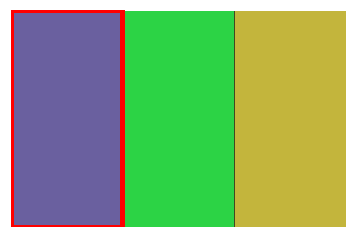

close
4) Game: 1124-1_1 Round: 2
purple


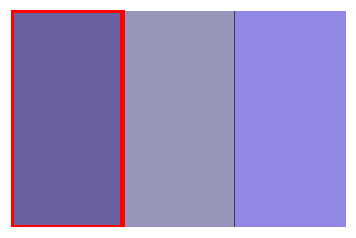

split
5) Game: 1124-1_2 Round: 2
purple


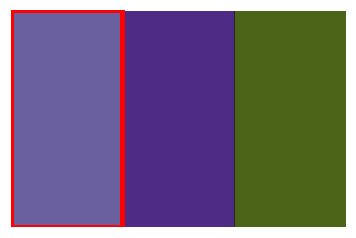

In [499]:
display_round(1)

In [501]:
for t in range(3):
    print(t, np.exp(output_to_likelihood(cp_outputs_subword[4:5], y_assess_subword_cp[4:5], target_idx=t)))

0 [0.21735817]
1 [0.06484333]
2 [0.399301]


In [392]:
cp_all_conds_str.reshape(-1, 3)[incorrect_inds[0]]

array(['close', 'split', 'far'], dtype='<U5')

In [385]:
cp_likelihood_subword[incorrect_inds[1]]

array([0.42631775, 0.5342513 , 0.03943093], dtype=float32)

In [386]:
cp_all_conds_str.reshape(-1, 3)[incorrect_inds[1]]

array(['split', 'close', 'far'], dtype='<U5')

In [300]:
cp_preds_str_subword[incorrect_inds[1]]

'close'

In [301]:
cp_truth_str[incorrect_inds[1]]

'split'

In [302]:
cp_likelihood_subword[1]

array([0.53343534, 0.08819008, 0.37837458], dtype=float32)

In [303]:
cp_all_conds_str.reshape(-1, 3)[1]

array(['far', 'close', 'split'], dtype='<U5')

In [305]:
cp_likelihood_subword[16]

array([0.0189748 , 0.81390345, 0.16712154], dtype=float32)

In [304]:
cp_all_conds_str.reshape(-1, 3)[16]

array(['far', 'close', 'split'], dtype='<U5')

far
48) Game: 1124-1_0 Round: 17
Yellowish brownish orangish yellow ~ lol


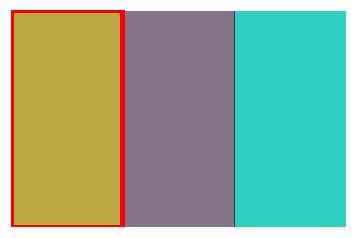

close
49) Game: 1124-1_1 Round: 17
Yellowish brownish orangish yellow ~ lol


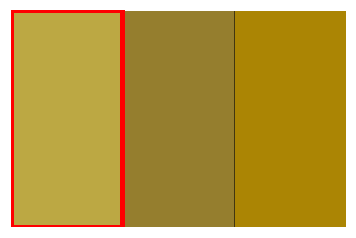

split
50) Game: 1124-1_2 Round: 17
Yellowish brownish orangish yellow ~ lol


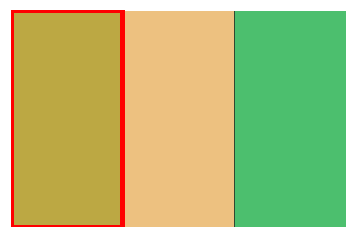

In [719]:
display_round(16)

In [319]:
pd.DataFrame(
    list(
        zip(train_cp_data.data.contents[3*incorrect_inds], 
            cp_preds_str_subword[incorrect_inds], 
            cp_truth_str[incorrect_inds])
    ),
    columns=["caption", "prediction", "truth"]
)

,caption,prediction,truth
0,The darker blue one,split,close
1,lime,close,split
2,Mint green.,close,far
3,Mud brown,close,far
4,Mud brown,far,split
5,Camo green,far,split
6,Darkish red,close,split
7,The more vibrantly red one... not the more pur...,close,split
8,blue,split,far
9,Yellowish brownish orangish yellow ~ lol,close,far


split
87) Game: 1124-1_0 Round: 30
dark green


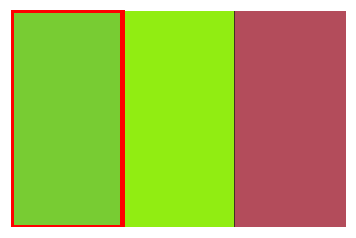

close
88) Game: 1124-1_1 Round: 30
dark green


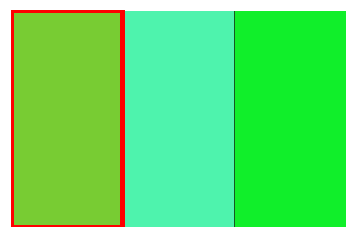

far
89) Game: 1124-1_2 Round: 30
dark green


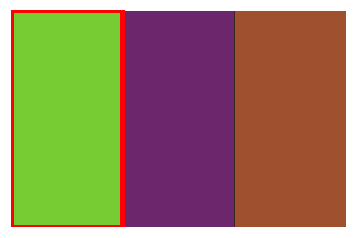

In [720]:
display_round(incorrect_inds[12])

In [336]:
from sklearn.metrics import confusion_matrix

In [344]:
x = confusion_matrix(y_true=cp_truth_str, y_pred=cp_preds_str_subword, labels=["close", "split", "far"])

In [347]:
print("close", "split", "far")
print(tabulate.tabulate(x))

close split far
----  ----  ----
3226  1008   925
1756  2181  1304
1343  1402  2520
----  ----  ----


In [338]:
cp_preds_str_subword

array(['split', 'far', 'close', ..., 'split', 'split', 'far'], dtype='<U5')

In [321]:
# measuring distance between distractors in the split condition:
train_data_split = train_data.data[train_data.data.condition == "split"]


In [330]:
train_data.data.head().T

,0,1,2,3,4
gameid,1124-1,1124-1,1124-1,1124-1,1124-1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,2,3,4,5
condition,close,far,close,split,far
clickStatus,distr2,target,distr2,distr1,target
clickColH,248,249,291,85,156
clickColS,92,25,59,21,84
clickColL,50,50,50,50,50
clickLocS,3,1,3,2,1
clickLocL,1,2,3,1,3


In [324]:
np.train_data_split.D1D2Diff

3        57
6        46
7        38
8        53
12       31
13       69
17       84
18       61
21       35
22       27
23       30
28       38
29       75
31       62
35       39
36       23
49       90
57       66
62       26
63       54
64       58
68       37
69       62
74       22
76       63
78       39
79       22
81       59
82       37
90       44
         ..
15571    44
15575    33
15578    30
15583    35
15584    23
15585    48
15590    30
15594    58
15595    25
15597    39
15606    75
15610    87
15613    25
15614    66
15615    50
15616    77
15619    60
15624    33
15626    67
15628    34
15630    30
15631    60
15634    54
15635    36
15642    71
15645    30
15648    57
15651    42
15659    35
15662    70
Name: D1D2Diff, Length: 5241, dtype: int64

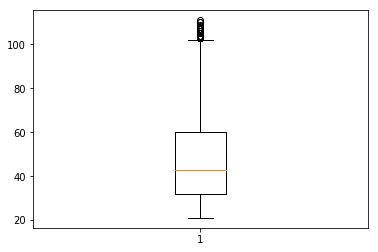

In [327]:
plt.boxplot(train_data_split.D1D2Diff)
plt.show()

In [328]:
min(train_data_split.D1D2Diff)

21

In [329]:
max(train_data_split.D1D2Diff)

111

In [367]:
train_cp_data.data.head().T

,0,1,2,3,4
gameid,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,1,1,2,2
condition,close,split,far,far,close
clickStatus,distr2,distr2,distr2,target,target
clickColH,248,27,337,249,249
clickColS,92,54,84,25,25
clickColL,50,68,50,50,50
clickLocS,3,3,3,1,1
clickLocL,1,1,1,2,2


Playing around with multiple samples:


In [686]:
train_cp_data_small_multisample = MonroeData("../data/csv/train_corpus_condition_prediction_smallmultisample.csv",
                                            "../data/entries/train_entries_condition_prediction_smallmultisample.pkl")

In [687]:
feature_handler_subword_cp_smallmulti = FeatureHandler(train_data, train_cp_data_small_multisample,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword, 
                                 randomized_colors=False)

X_assess_subword_cp_smallmulti = feature_handler_subword_cp_smallmulti.test_features()
y_assess_subword_cp_smallmulti = feature_handler_subword_cp_smallmulti.test_targets()

In [702]:
%%time
cp_outputs_subword_smallmulti = s0_subword.predict(X_assess_subword_cp_smallmulti)

cp_likelihood_smallmulti = output_to_likelihood(cp_outputs_subword_smallmulti, y_assess_subword_cp_smallmulti)

cp_preds_idx_smallmulti = likelihood_to_predictions(cp_likelihood_smallmulti, num_samples=5)

cp_all_conds_smallmulti = np.array([de.condition for de in train_cp_data_small_multisample])
num_samples = 5

cp_truth_str_smallmulti = cp_all_conds_smallmulti[::2*num_samples+1] # extract just the indices from the empirical data
cp_truth_str_smallmulti = cp_truth_str_smallmulti.repeat(num_samples) # holds the correct answer for each sample

# reshape list of all condition strings and then access the string associated with the prediction
cp_preds_str_subword_smallmulti = reshape_sample_list(cp_all_conds_smallmulti, num_samples=5)
cp_preds_str_subword_smallmulti = cp_preds_str_subword_smallmulti[np.arange(len(cp_preds_idx_smallmulti)), cp_preds_idx_smallmulti]

CPU times: user 388 ms, sys: 78.2 ms, total: 466 ms
Wall time: 465 ms


In [718]:
print(classification_report(cp_preds_str_subword_smallmulti, cp_truth_str_smallmulti))

              precision    recall  f1-score   support

       close       0.50      0.28      0.36        18
         far       0.65      0.72      0.68        18
       split       0.30      0.43      0.35        14

   micro avg       0.48      0.48      0.48        50
   macro avg       0.48      0.48      0.46        50
weighted avg       0.50      0.48      0.47        50



In [732]:
train_cp_data_50sample = MonroeData("../data/csv/train_corpus_condition_prediction_50sample.csv",
                                    "../data/entries/train_entries_condition_prediction_50sample.pkl")

In [733]:
feature_handler_subword_cp_50sample = FeatureHandler(train_data, train_cp_data_50sample,
                                 caption_phi_subword, color_phi, target_fn=speaker_target_subword, 
                                 randomized_colors=False)

X_assess_subword_cp_50sample = feature_handler_subword_cp_50sample.test_features()
y_assess_subword_cp_50sample = feature_handler_subword_cp_50sample.test_targets()

In [734]:
%%time
cp_outputs_subword_50sample = s0_subword.predict(X_assess_subword_cp_50sample)

cp_likelihood_50sample = output_to_likelihood(cp_outputs_subword_50sample, y_assess_subword_cp_50sample)

cp_preds_idx_50sample = likelihood_to_predictions(cp_likelihood_50sample, num_samples=50)

cp_all_conds_50sample = np.array([de.condition for de in train_cp_data_50sample])
num_samples = 50

cp_truth_str_50sample = cp_all_conds_50sample[::2*num_samples+1] # extract just the indices from the empirical data
cp_truth_str_50sample = cp_truth_str_50sample.repeat(num_samples) # holds the correct answer for each sample

# reshape list of all condition strings and then access the string associated with the prediction
cp_preds_str_subword_50sample = reshape_sample_list(cp_all_conds_50sample, num_samples=50)
cp_preds_str_subword_50sample = cp_preds_str_subword_50sample[np.arange(len(cp_preds_idx_50sample)), cp_preds_idx_50sample]


CPU times: user 1h 32min 14s, sys: 12min 59s, total: 1h 45min 13s
Wall time: 1h 38min 45s


In [736]:
print("Subword Oversampled")
print(classification_report(cp_preds_str_subword_50sample, cp_truth_str_50sample))

Subword Oversampled
              precision    recall  f1-score   support

       close       0.54      0.49      0.51    287320
         far       0.55      0.57      0.56    256069
       split       0.42      0.46      0.44    239861

   micro avg       0.51      0.51      0.51    783250
   macro avg       0.51      0.51      0.50    783250
weighted avg       0.51      0.51      0.51    783250



In [737]:
%%time
feature_handler_endings_cp_50sample = FeatureHandler(train_data, train_cp_data_50sample,
                                 caption_phi_endings, color_phi, target_fn=speaker_target_endings, 
                                 randomized_colors=False)

X_assess_endings_cp_50sample = feature_handler_endings_cp_50sample.test_features()
y_assess_endings_cp_50sample = feature_handler_endings_cp_50sample.test_targets()

CPU times: user 16min 41s, sys: 5min 56s, total: 22min 37s
Wall time: 30min 1s


# Comparison to Baseline

In [741]:
# ok, so the next step is to compare this to the baseline. I'm not totally sure what the best way to do this is...
# especially because this 50-samples dataset was made on the training set, so I suppose I can just look at the mistakes
# that the "baseline" made on the training data? Or maybe what I can do is train on the dev data and look at the
# predictions on the training data. I think both would be effective

In [770]:
# first, let's load in the predictions from the baseline
with open("../results/condition_prediction_baseline_training_subword.pkl", "rb") as pfile:
    baseline_training_subword = pkl.load(pfile)

In [771]:
baseline_training_subword[:10]

array([0, 2, 1, 1, 2, 2, 2, 2, 1, 2])

In [772]:
# array of strings that will be indexed by baseline results
condition_array = np.repeat(np.array([["close", "split", "far"]]), len(baseline_training_subword), axis=0)

In [773]:
cp_preds_str_subword_baseline = condition_array[np.arange(len(condition_array)), baseline_training_subword]

In [774]:
cp_preds_str_subword_baseline[:10]

array(['close', 'far', 'split', 'split', 'far', 'far', 'far', 'far',
       'split', 'far'], dtype='<U5')

In [775]:
cp_preds_str_subword_baseline_rep = np.repeat(cp_preds_str_subword_baseline, 50)

In [776]:
len(cp_preds_str_subword_baseline_rep)

783250

In [767]:
len(cp_preds_str_subword_50sample)

783250

In [777]:
print(classification_report(cp_preds_str_subword_50sample, cp_preds_str_subword_baseline_rep))

              precision    recall  f1-score   support

       close       0.51      0.24      0.33    287320
         far       0.46      0.79      0.58    256069
       split       0.36      0.30      0.33    239861

   micro avg       0.44      0.44      0.44    783250
   macro avg       0.44      0.45      0.41    783250
weighted avg       0.45      0.44      0.41    783250



In [780]:
diff_inds = cp_preds_str_subword_50sample == cp_preds_str_subword_baseline_rep

In [782]:
sum(diff_inds)/len(cp_preds_str_subword_baseline_rep)

0.44076731567188

In [783]:
diff_inds[:50]

array([False, False,  True,  True, False,  True, False, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False, False, False,  True,  True])

The darker blue one | prag: split | bl: close


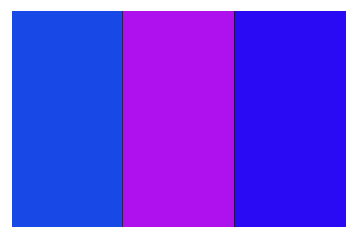

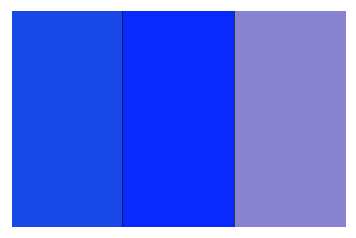

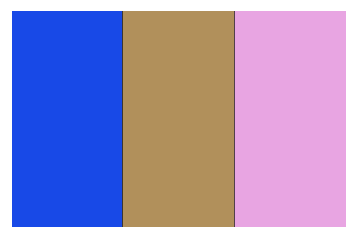

The darker blue one | prag: far | bl: close


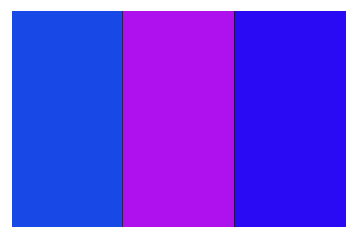

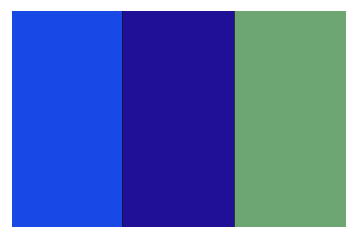

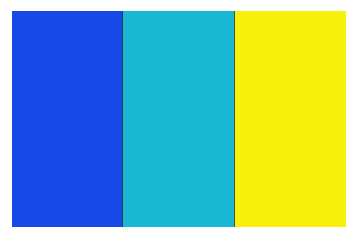

The darker blue one | prag: close | bl: close


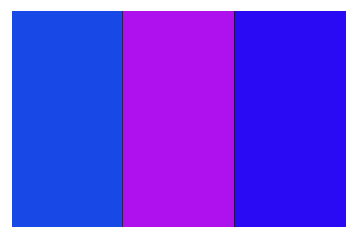

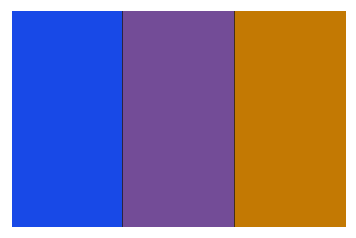

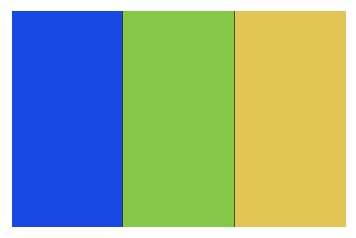

The darker blue one | prag: close | bl: close


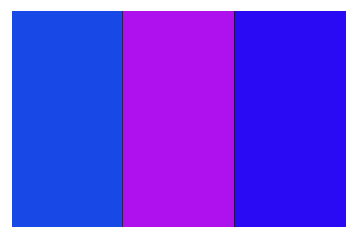

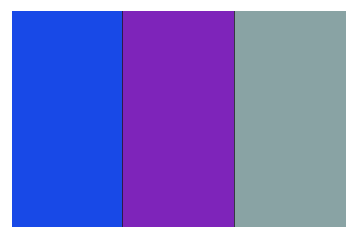

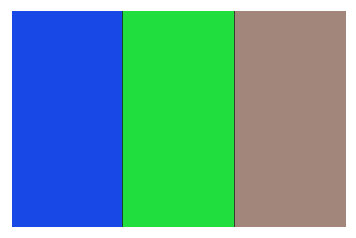

The darker blue one | prag: split | bl: close


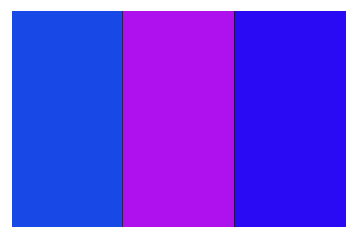

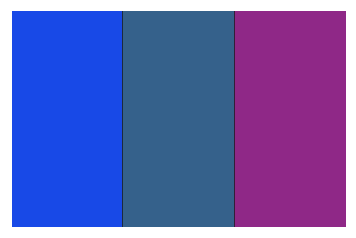

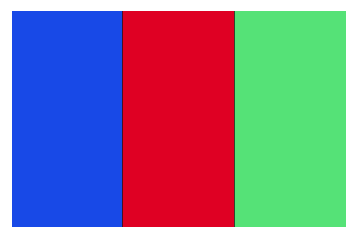

The darker blue one | prag: close | bl: close


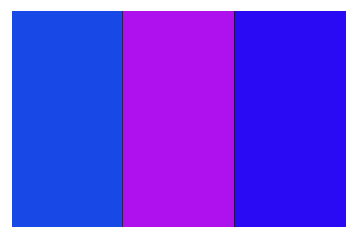

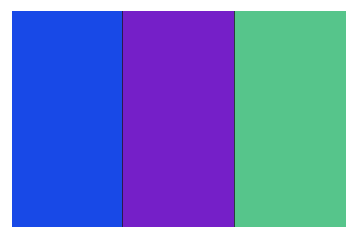

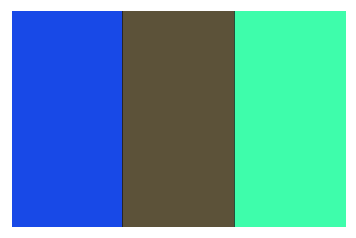

The darker blue one | prag: split | bl: close


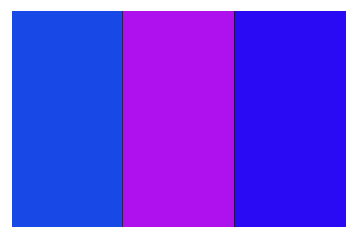

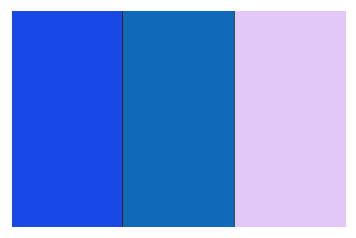

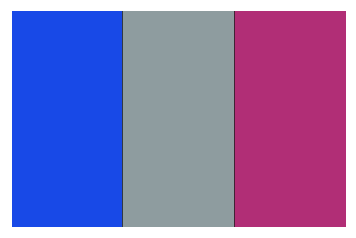

The darker blue one | prag: split | bl: close


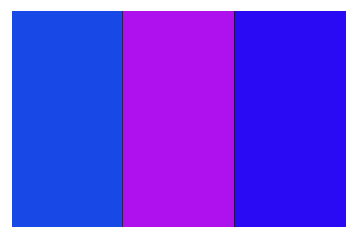

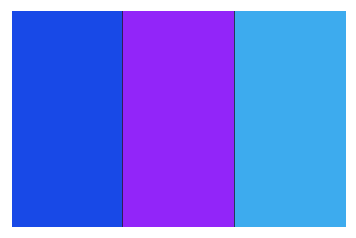

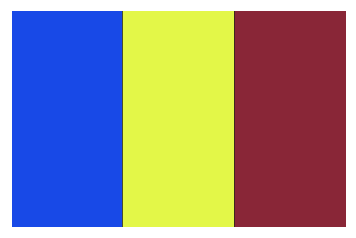

The darker blue one | prag: split | bl: close


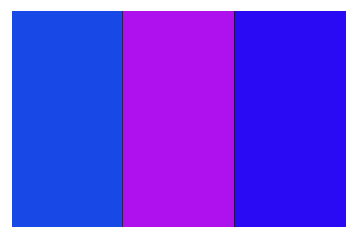

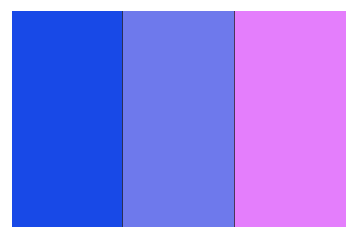

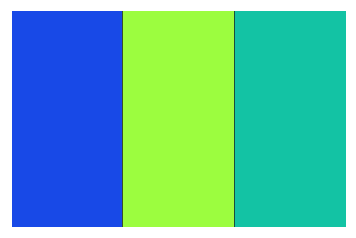

The darker blue one | prag: close | bl: close


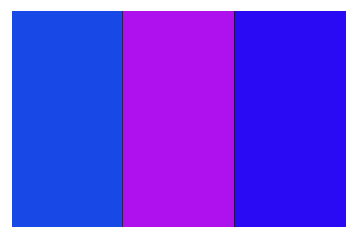

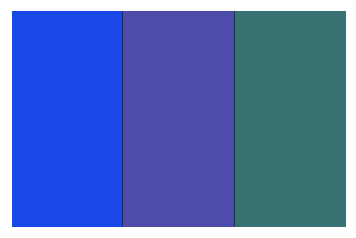

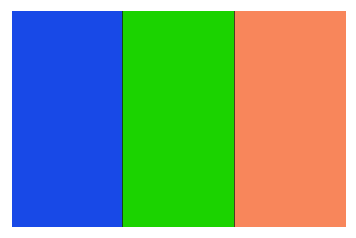

The darker blue one | prag: split | bl: close


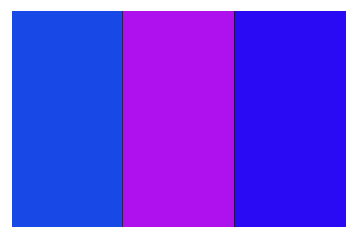

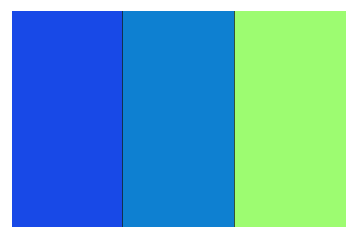

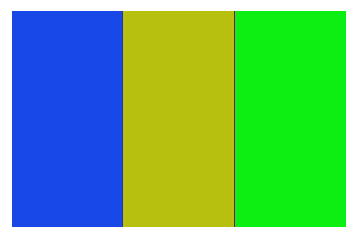

The darker blue one | prag: close | bl: close


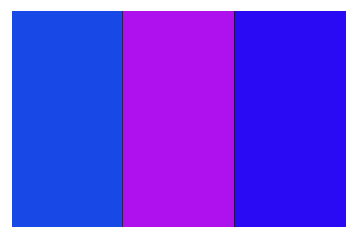

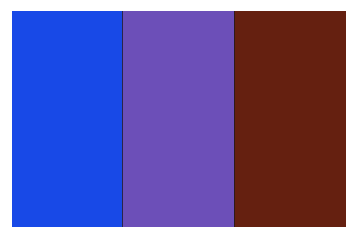

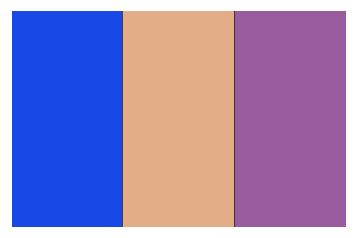

The darker blue one | prag: split | bl: close


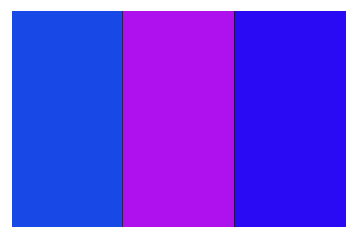

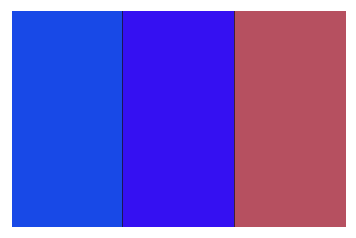

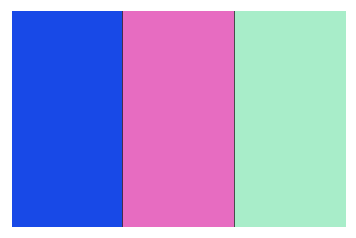

The darker blue one | prag: close | bl: close


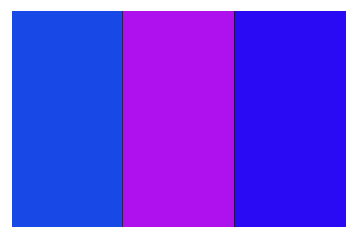

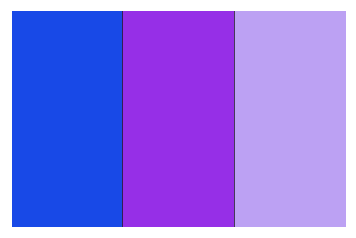

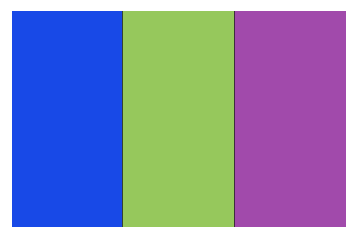

The darker blue one | prag: split | bl: close


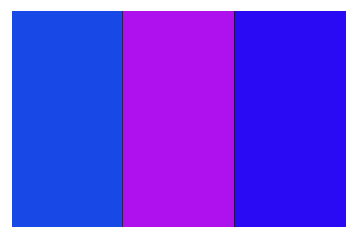

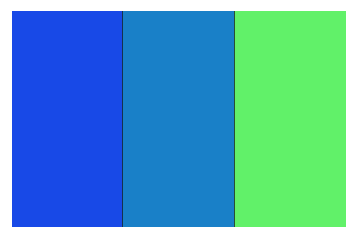

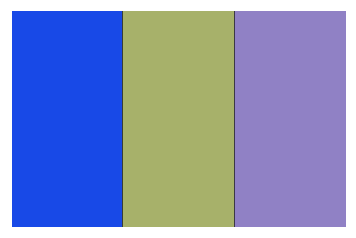

The darker blue one | prag: split | bl: close


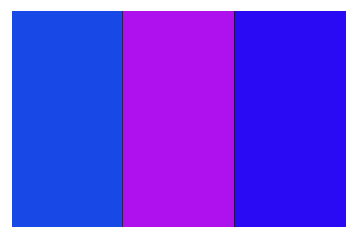

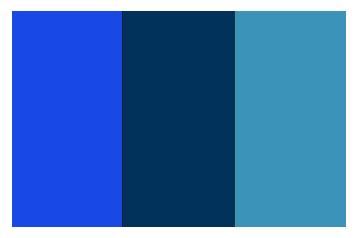

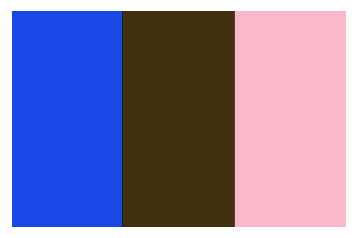

The darker blue one | prag: split | bl: close


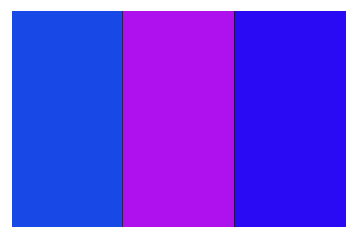

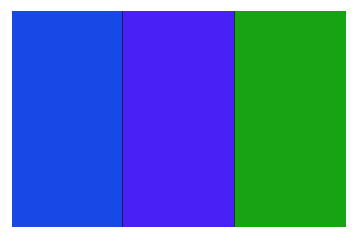

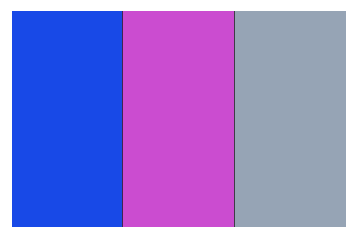

The darker blue one | prag: split | bl: close


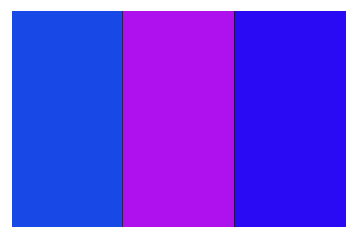

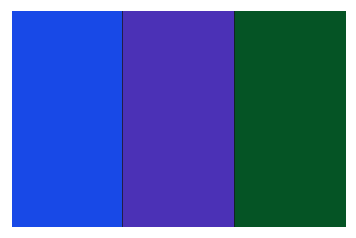

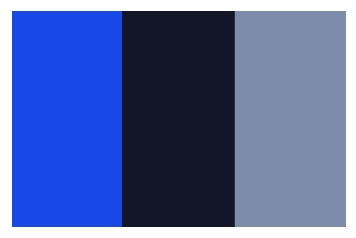

The darker blue one | prag: split | bl: close


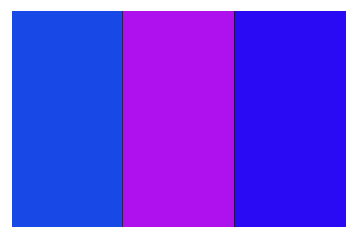

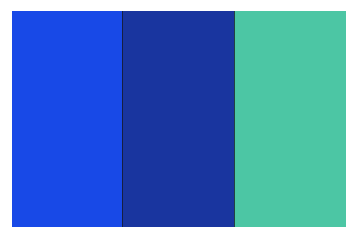

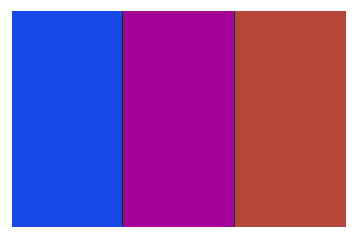

The darker blue one | prag: close | bl: close


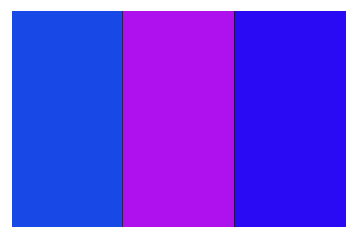

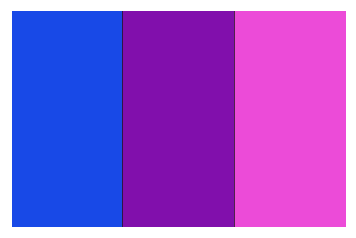

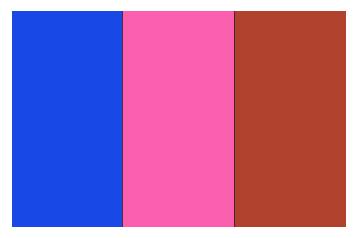

The darker blue one | prag: split | bl: close


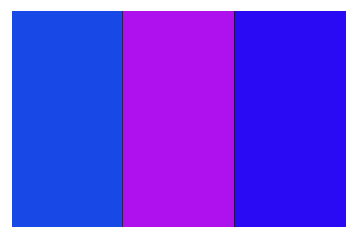

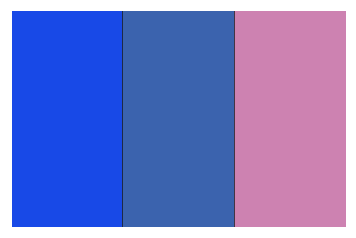

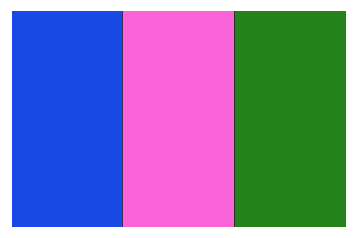

The darker blue one | prag: split | bl: close


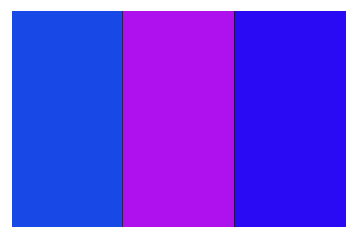

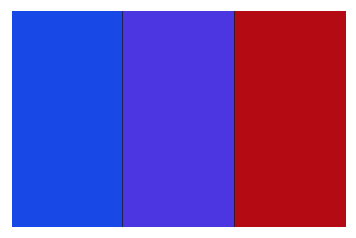

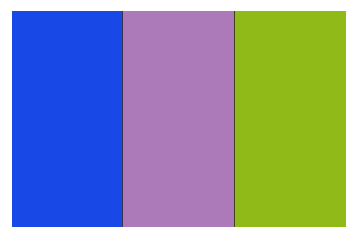

The darker blue one | prag: split | bl: close


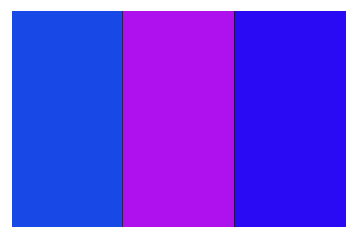

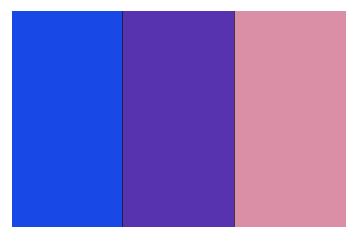

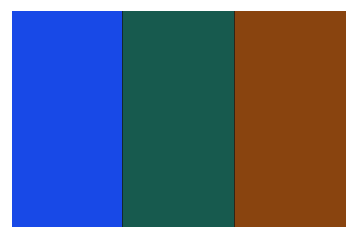

The darker blue one | prag: far | bl: close


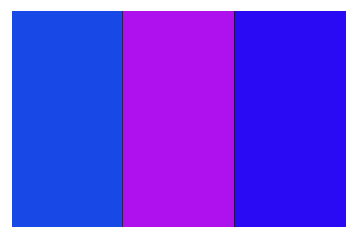

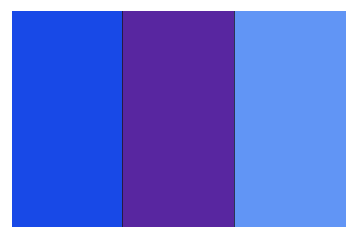

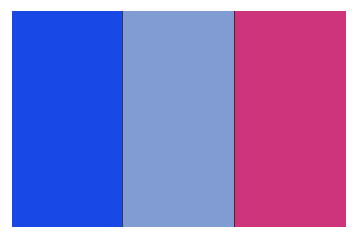

The darker blue one | prag: split | bl: close


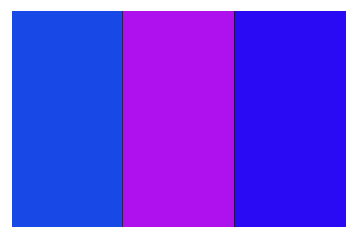

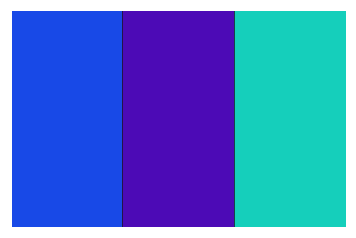

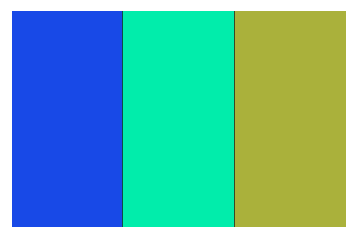

The darker blue one | prag: split | bl: close


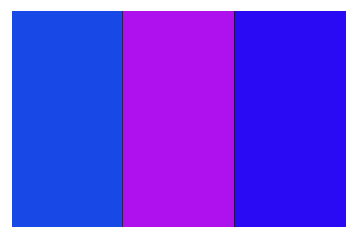

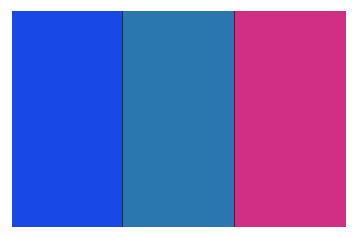

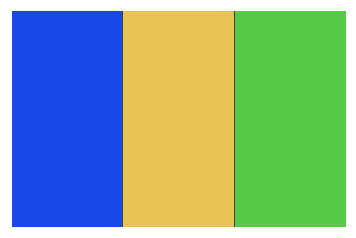

The darker blue one | prag: split | bl: close


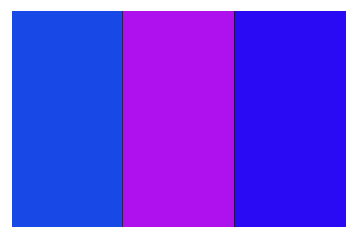

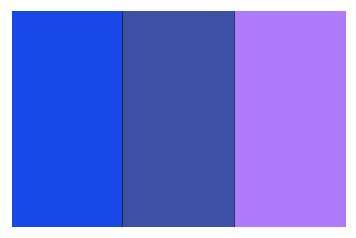

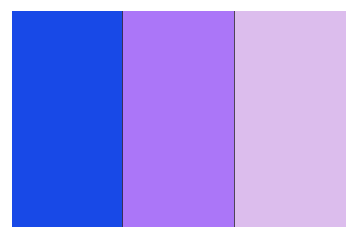

The darker blue one | prag: split | bl: close


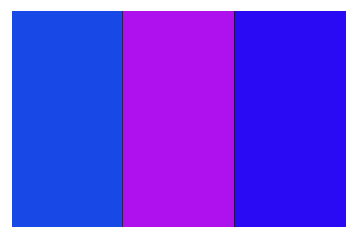

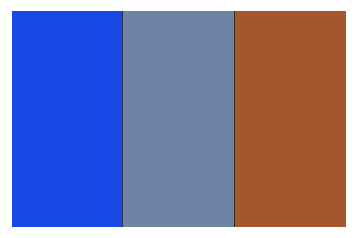

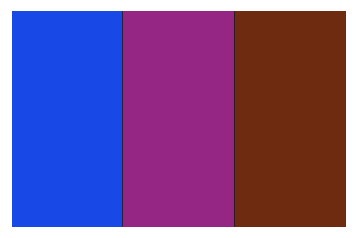

The darker blue one | prag: split | bl: close


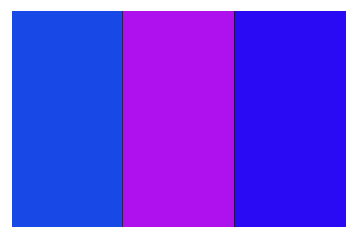

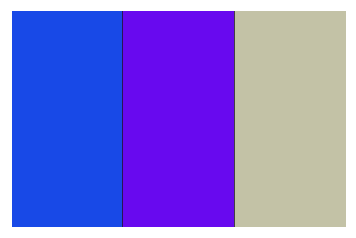

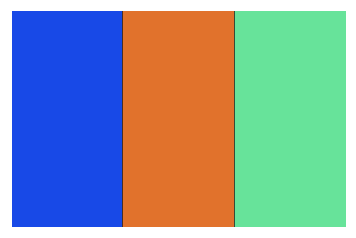

The darker blue one | prag: split | bl: close


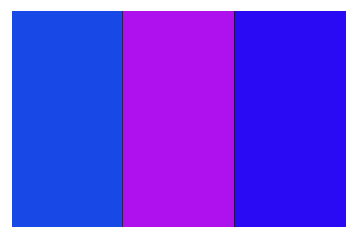

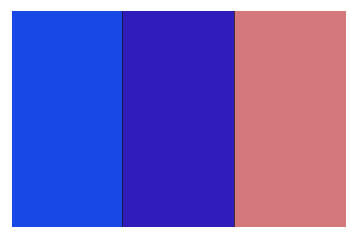

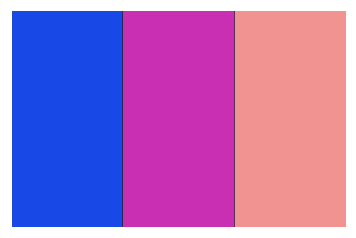

The darker blue one | prag: split | bl: close


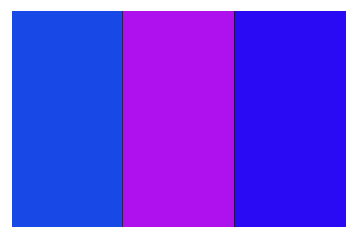

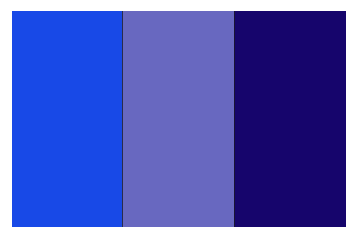

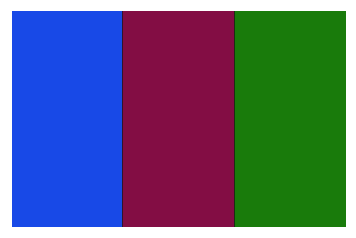

The darker blue one | prag: split | bl: close


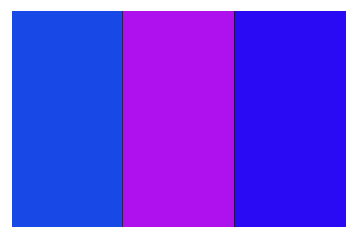

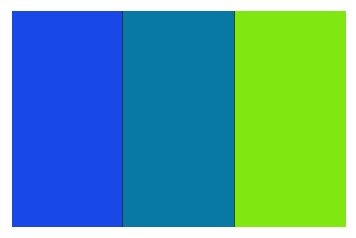

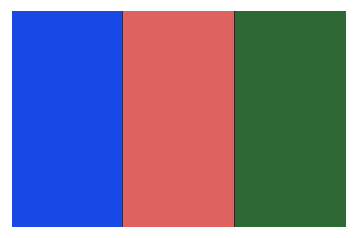

The darker blue one | prag: close | bl: close


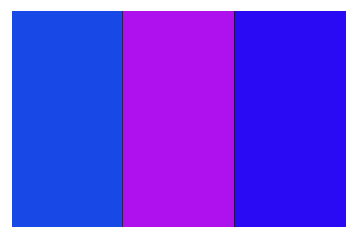

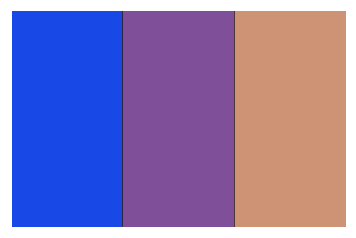

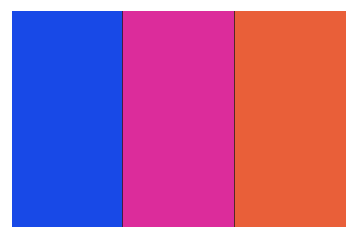

The darker blue one | prag: split | bl: close


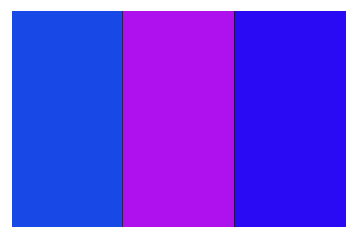

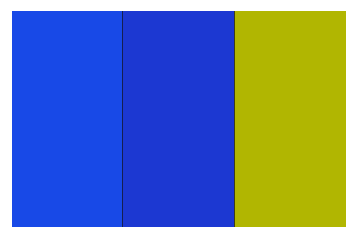

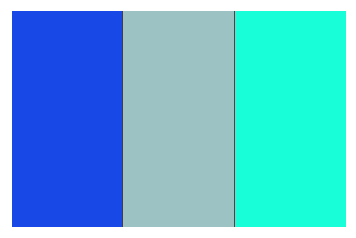

The darker blue one | prag: close | bl: close


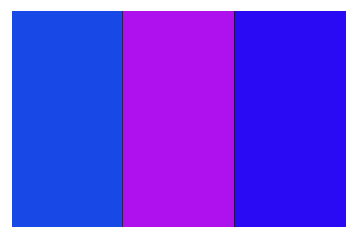

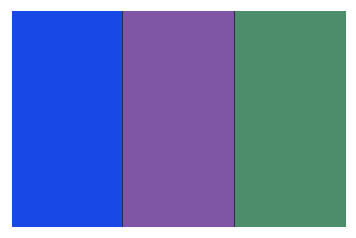

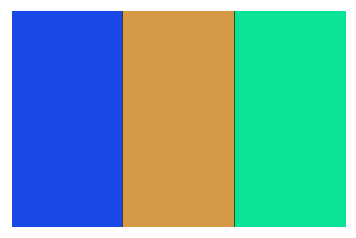

The darker blue one | prag: split | bl: close


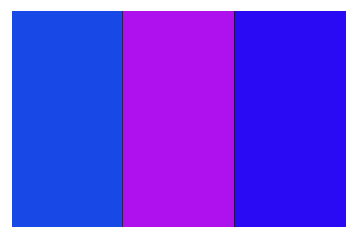

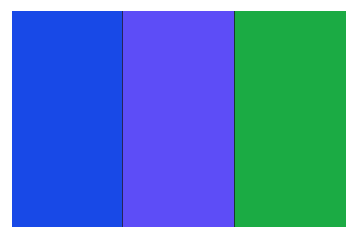

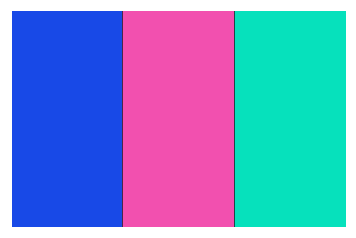

The darker blue one | prag: split | bl: close


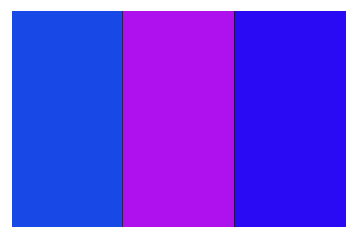

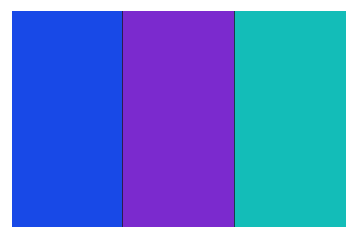

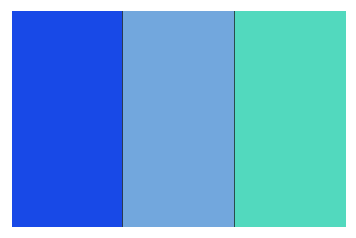

The darker blue one | prag: split | bl: close


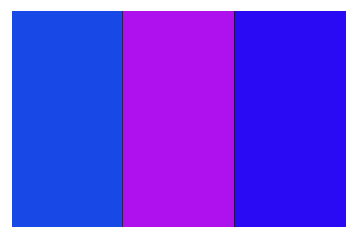

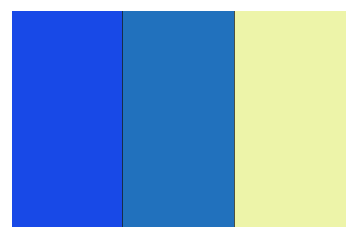

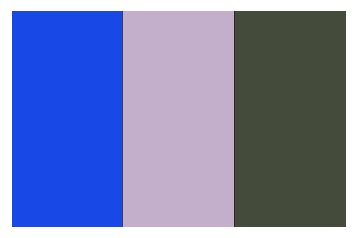

The darker blue one | prag: split | bl: close


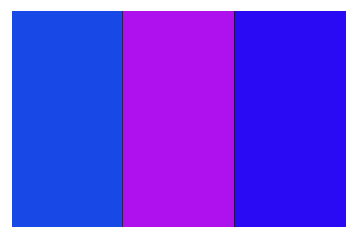

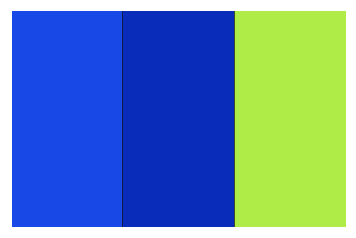

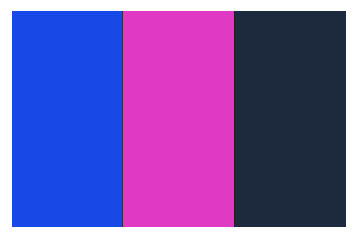

The darker blue one | prag: split | bl: close


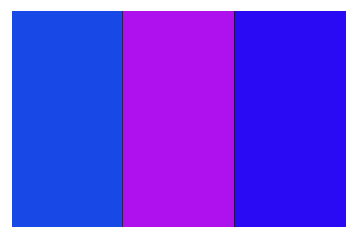

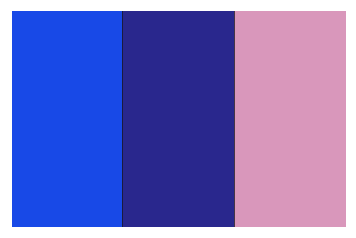

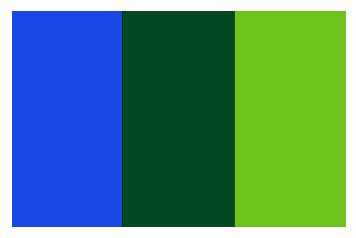

The darker blue one | prag: close | bl: close


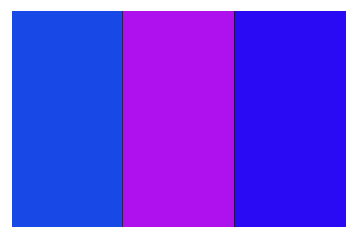

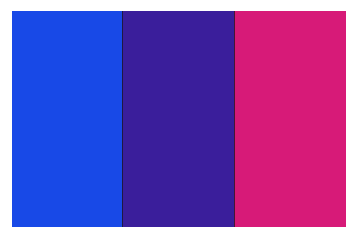

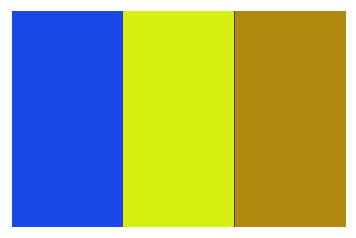

The darker blue one | prag: close | bl: close


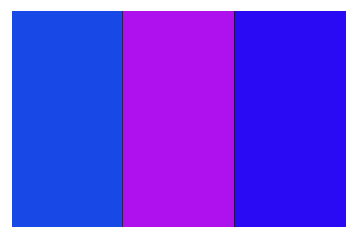

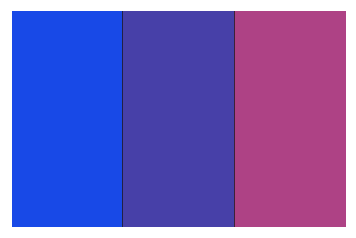

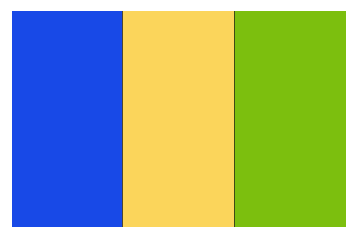

The darker blue one | prag: close | bl: close


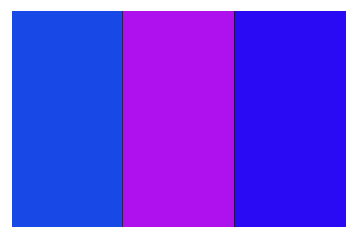

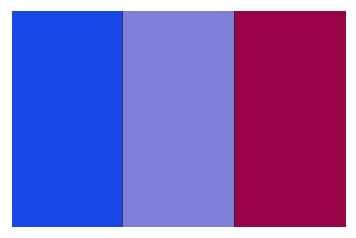

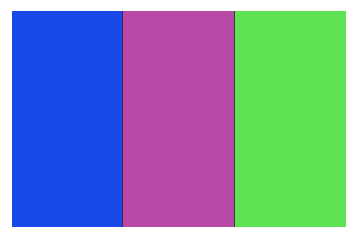

The darker blue one | prag: close | bl: close


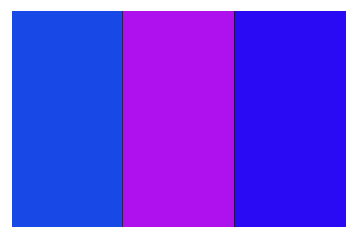

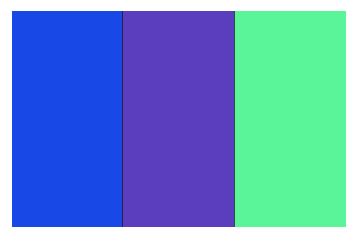

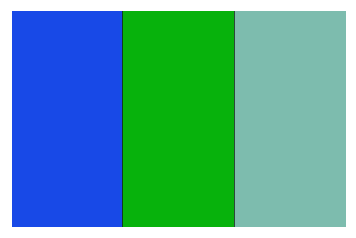

The darker blue one | prag: split | bl: close


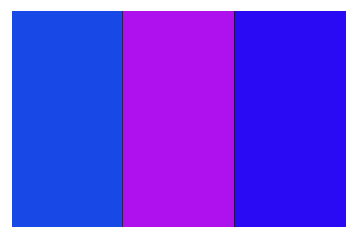

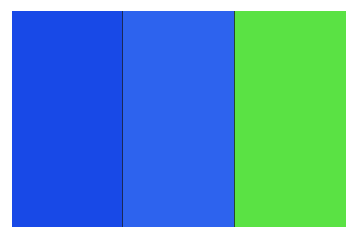

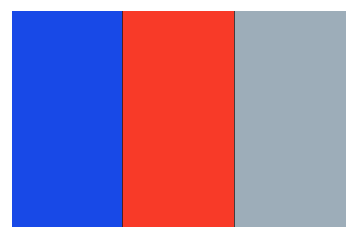

The darker blue one | prag: split | bl: close


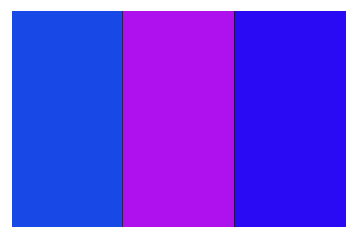

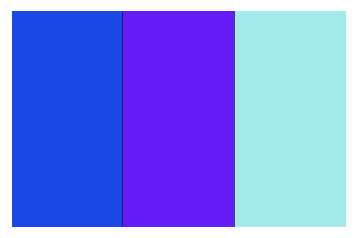

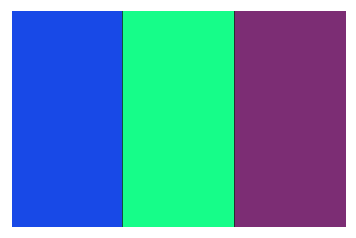

The darker blue one | prag: split | bl: close


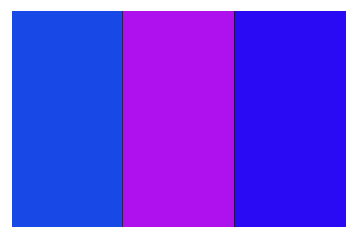

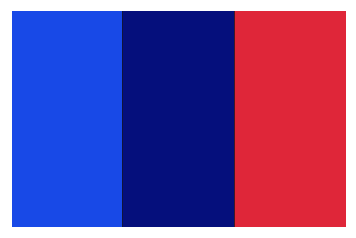

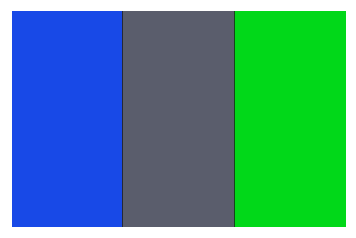

The darker blue one | prag: split | bl: close


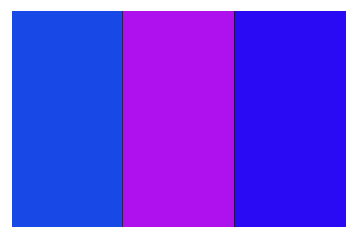

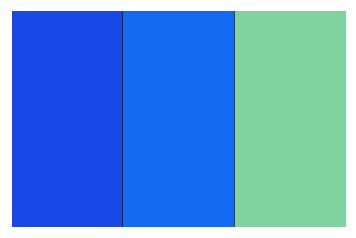

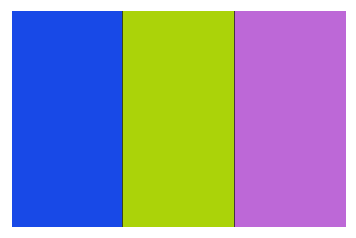

The darker blue one | prag: close | bl: close


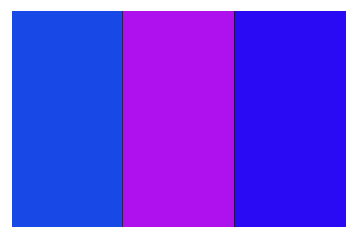

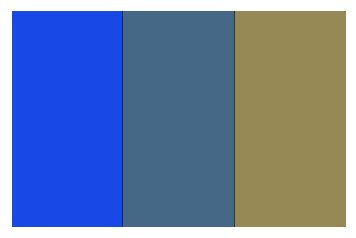

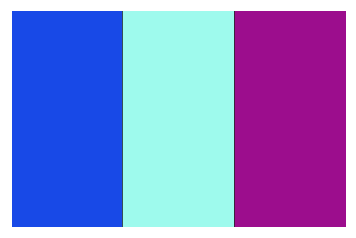

The darker blue one | prag: close | bl: close


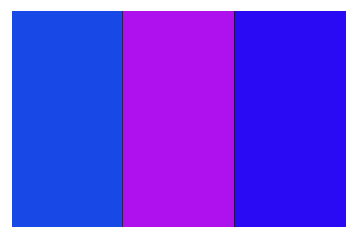

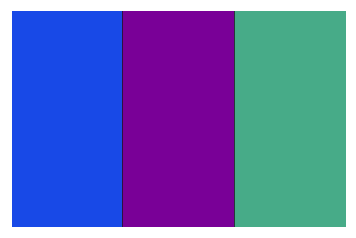

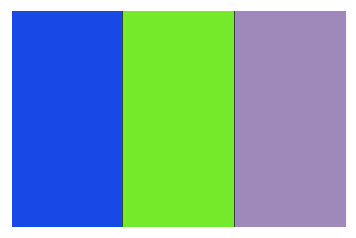

In [795]:
for i in range(50):
    train_data.display_custom_game(train_cp_data_50sample[i//50].colors, "{} | prag: {} | bl: {}".format(
        train_cp_data_50sample[0].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i]))
    train_data.display_custom_game(train_cp_data_50sample[2*i+1].colors, train_cp_data_50sample[2*i+2].condition)
    train_data.display_custom_game(train_cp_data_50sample[2*i+2].colors, train_cp_data_50sample[2*i+2].condition)

(array([33.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., 15.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

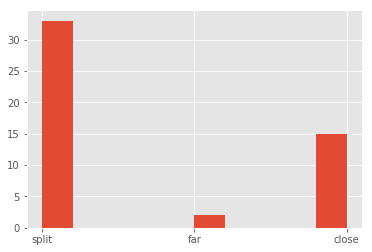

In [797]:
plt.hist(cp_preds_str_subword_50sample[:50])

The darker blue one | prag: far | bl: close


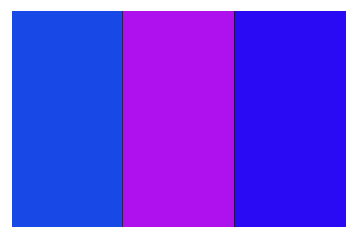

split


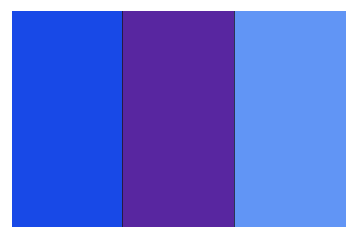

far


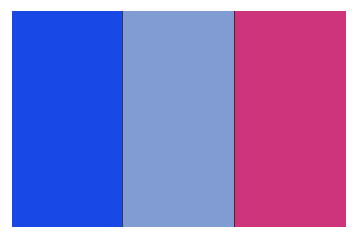

In [803]:
i=23
train_data.display_custom_game(train_cp_data_50sample[i//50].colors, "{} | prag: {} | bl: {}".format(
    train_cp_data_50sample[0].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i]))
train_data.display_custom_game(train_cp_data_50sample[2*i+1].colors, train_cp_data_50sample[2*i+1].condition)
train_data.display_custom_game(train_cp_data_50sample[2*i+2].colors, train_cp_data_50sample[2*i+2].condition)

purple | prag: far | bl: far


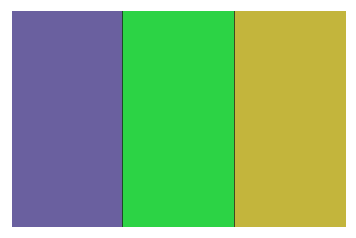

close


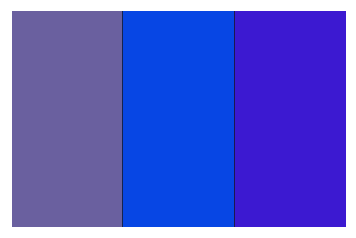

split


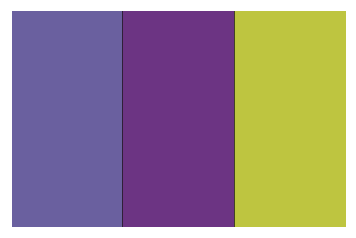

purple | prag: far | bl: far


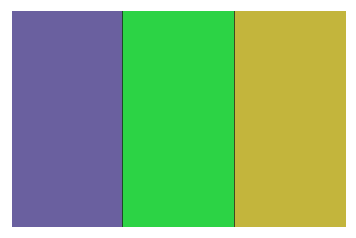

close


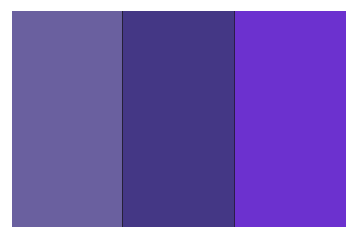

split


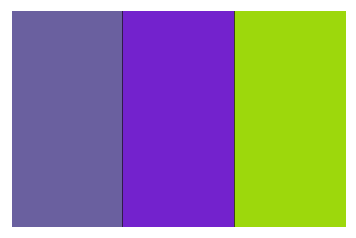

purple | prag: far | bl: far


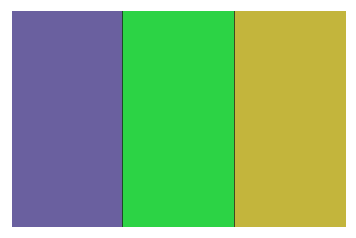

close


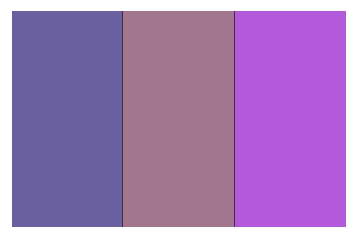

split


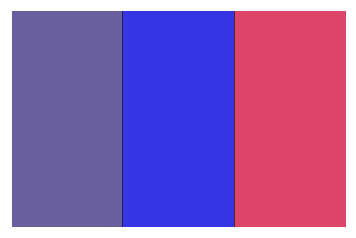

purple | prag: far | bl: far


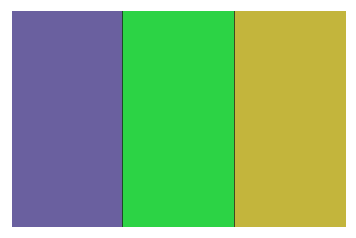

close


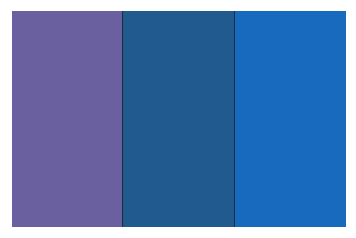

split


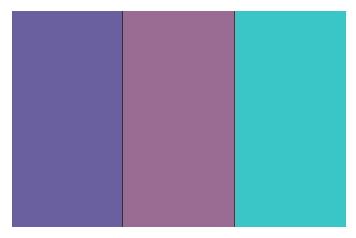

purple | prag: far | bl: far


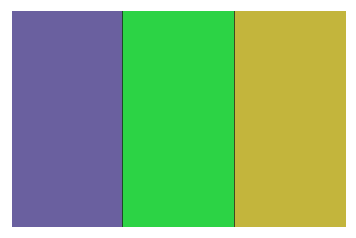

close


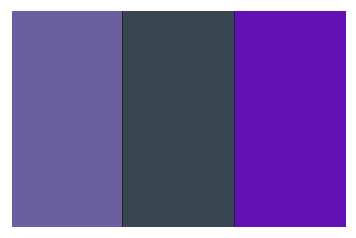

split


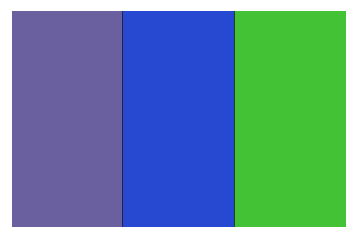

purple | prag: far | bl: far


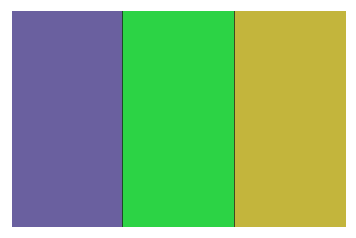

close


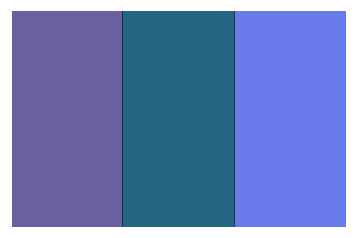

split


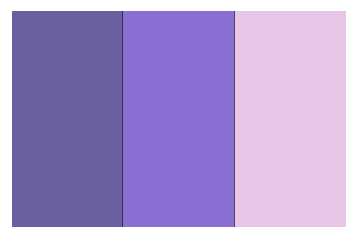

purple | prag: far | bl: far


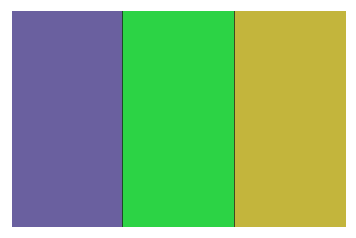

close


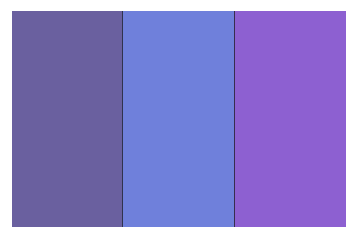

split


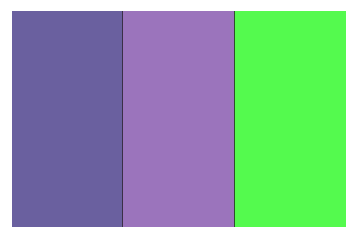

purple | prag: far | bl: far


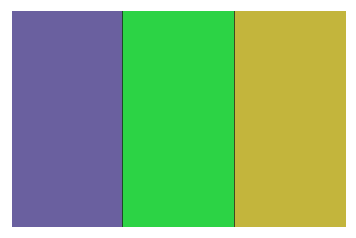

close


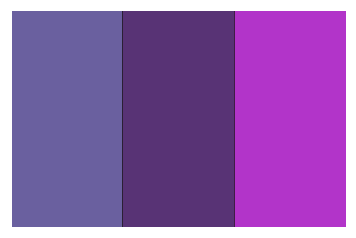

split


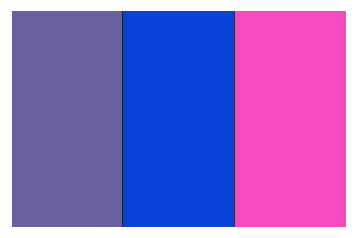

purple | prag: far | bl: far


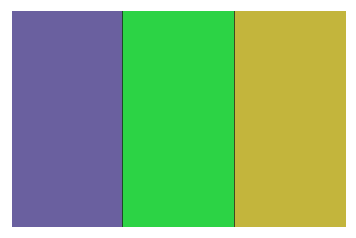

close


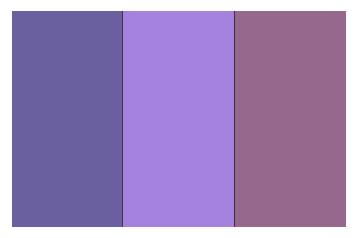

split


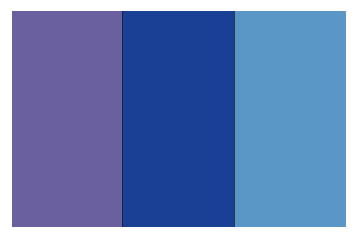

purple | prag: far | bl: far


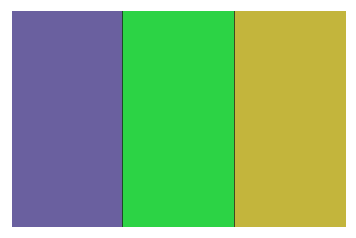

close


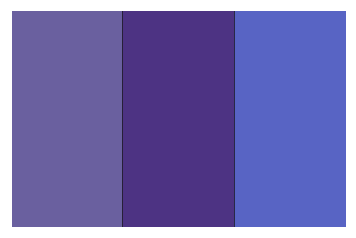

split


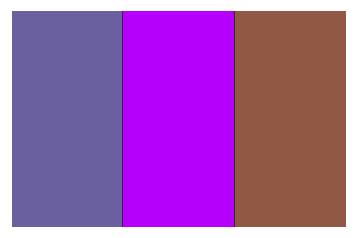

purple | prag: far | bl: far


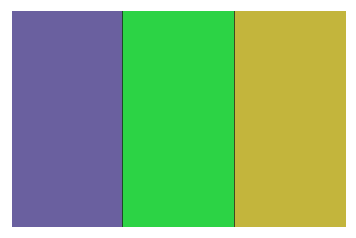

close


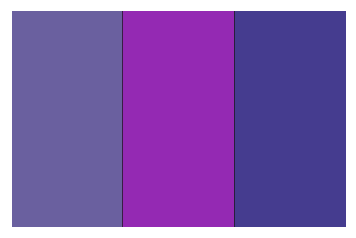

split


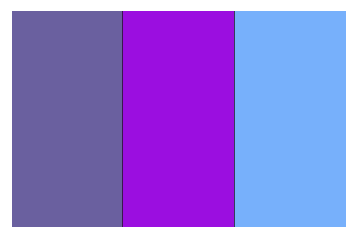

purple | prag: far | bl: far


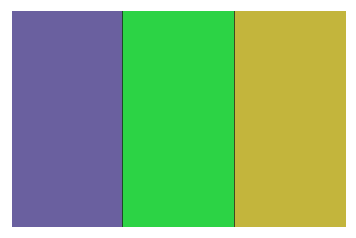

close


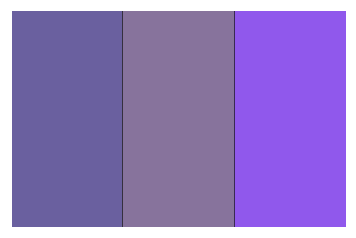

split


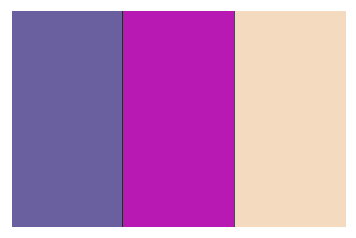

purple | prag: far | bl: far


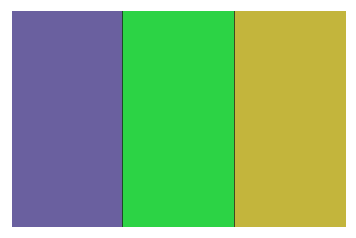

close


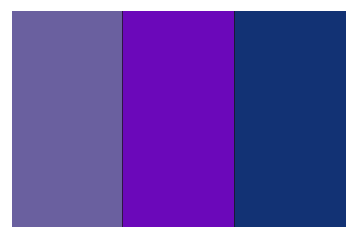

split


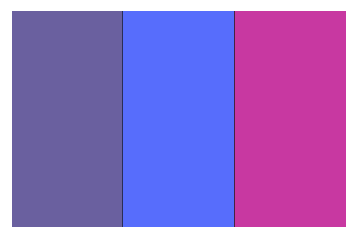

purple | prag: far | bl: far


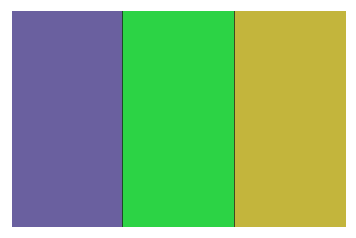

close


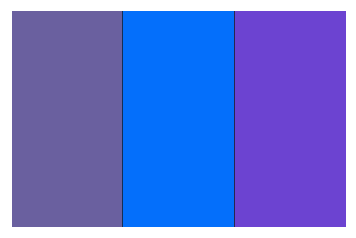

split


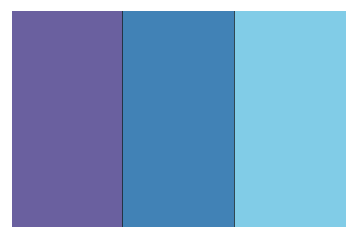

purple | prag: far | bl: far


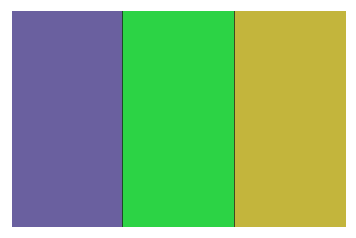

close


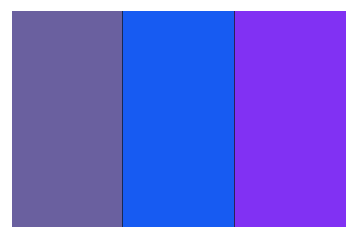

split


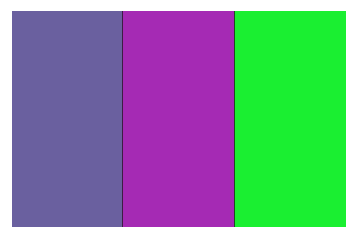

purple | prag: far | bl: far


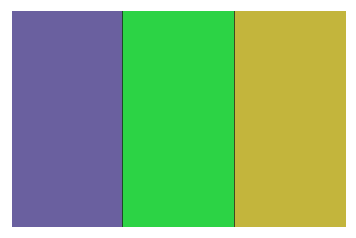

close


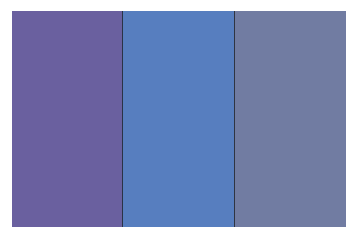

split


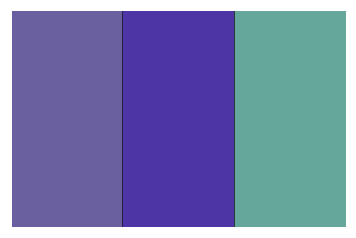

purple | prag: far | bl: far


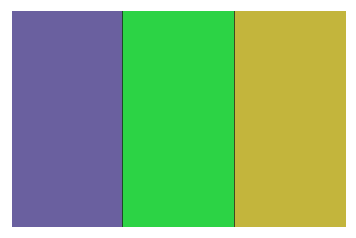

close


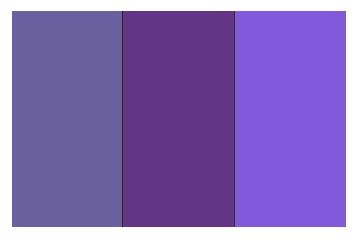

split


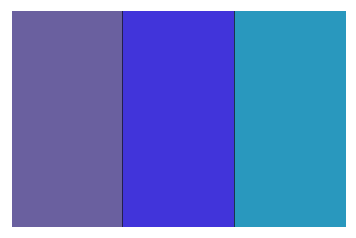

purple | prag: far | bl: far


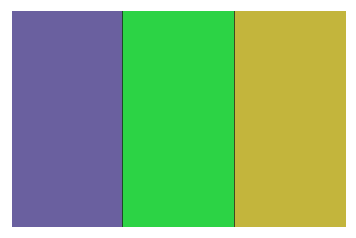

close


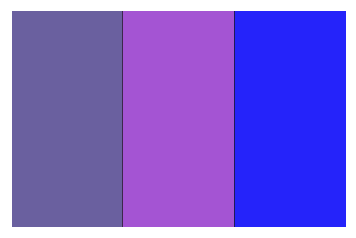

split


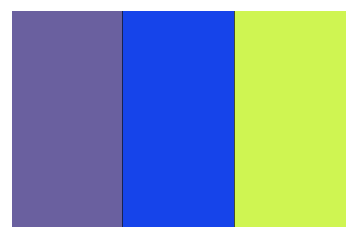

purple | prag: far | bl: far


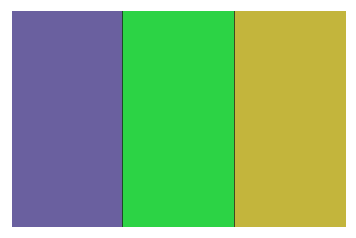

close


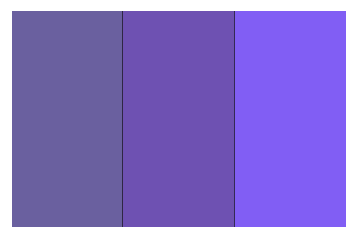

split


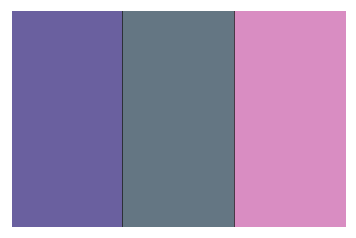

purple | prag: far | bl: far


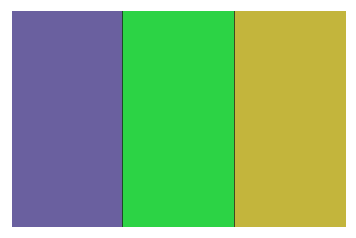

close


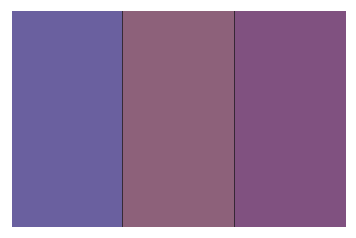

split


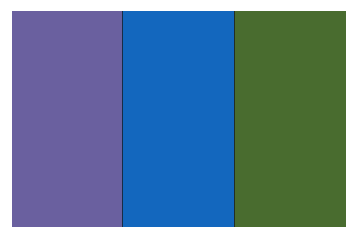

purple | prag: far | bl: far


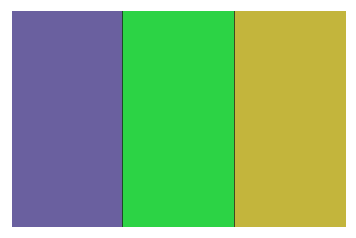

close


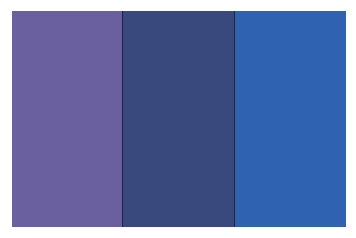

split


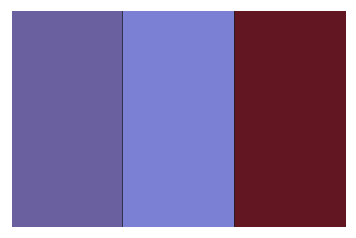

purple | prag: far | bl: far


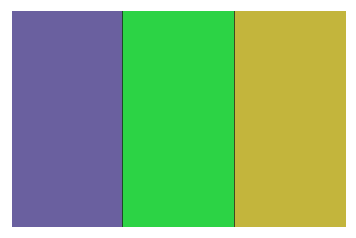

close


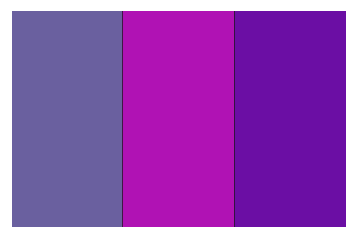

split


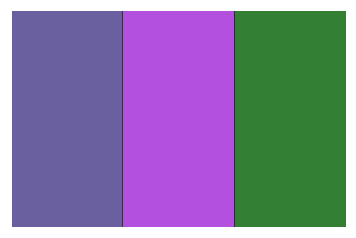

purple | prag: far | bl: far


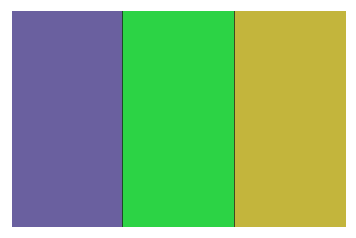

close


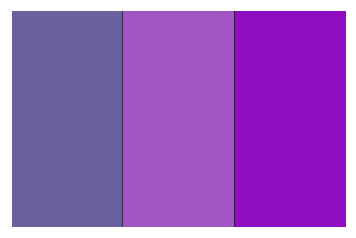

split


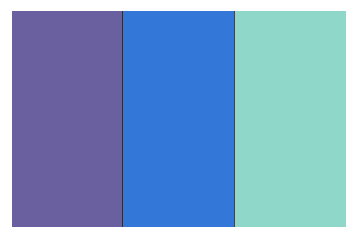

purple | prag: far | bl: far


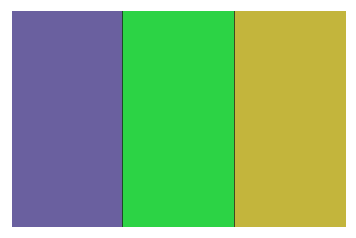

close


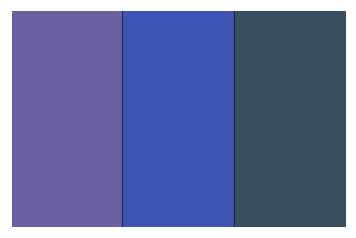

split


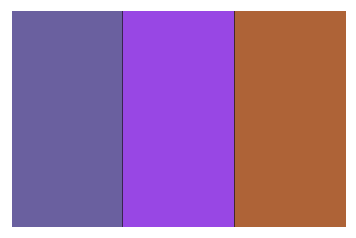

purple | prag: far | bl: far


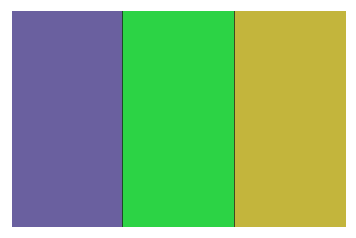

close


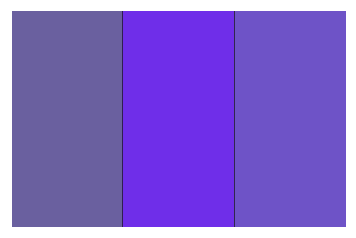

split


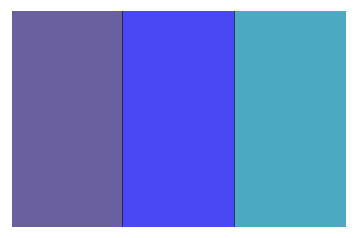

purple | prag: far | bl: far


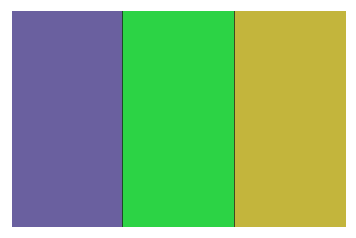

close


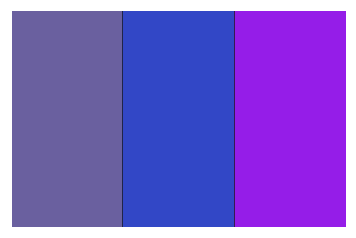

split


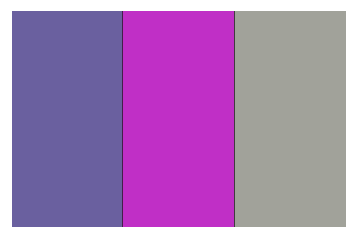

purple | prag: far | bl: far


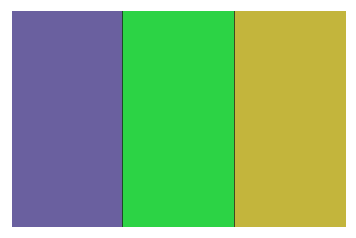

close


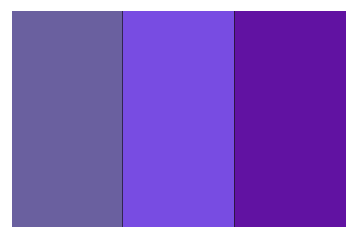

split


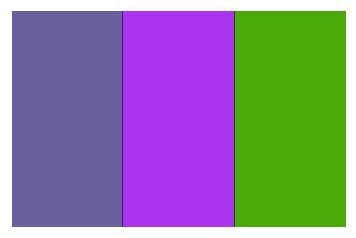

purple | prag: far | bl: far


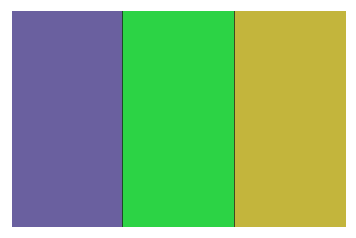

close


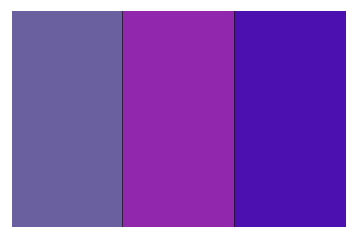

split


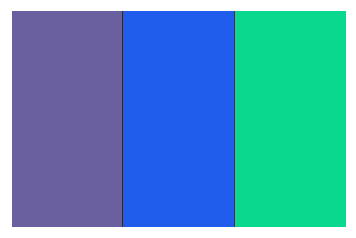

purple | prag: far | bl: far


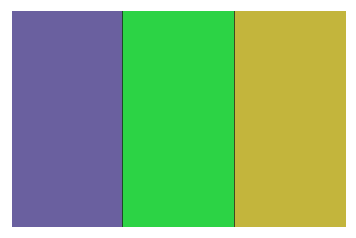

close


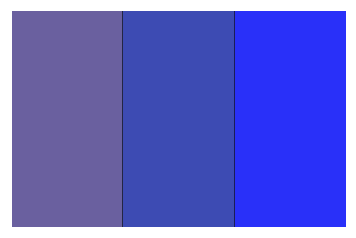

split


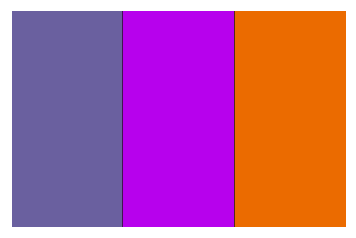

purple | prag: far | bl: far


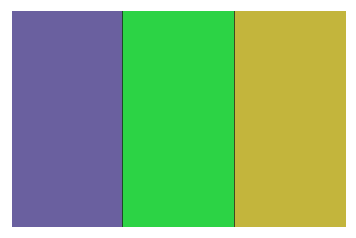

close


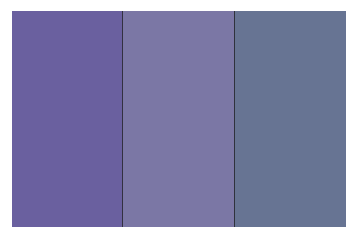

split


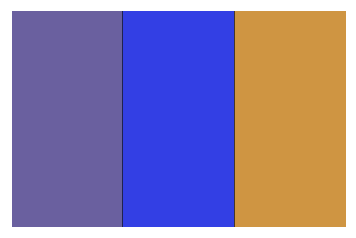

purple | prag: far | bl: far


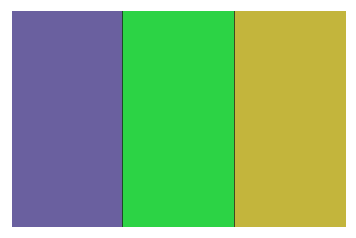

close


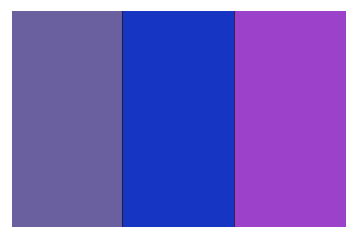

split


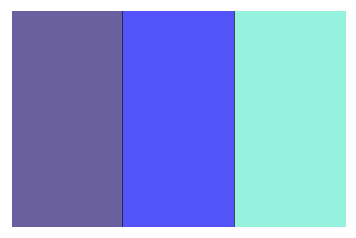

purple | prag: far | bl: far


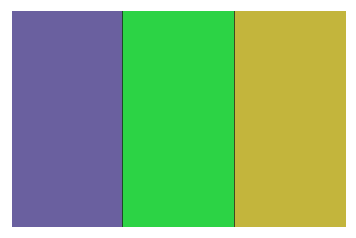

close


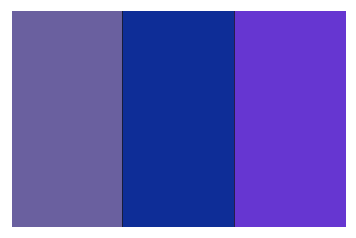

split


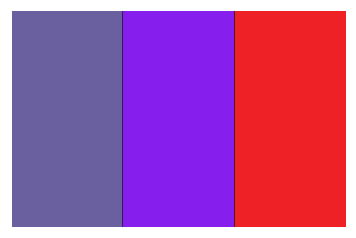

purple | prag: far | bl: far


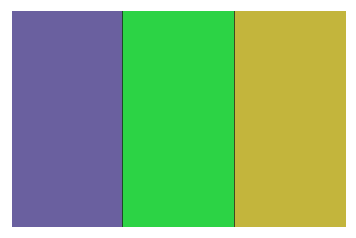

close


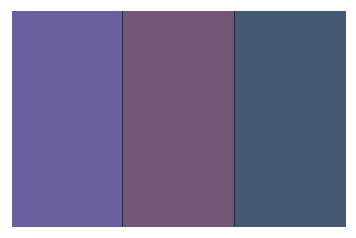

split


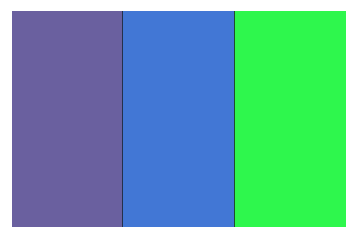

purple | prag: far | bl: far


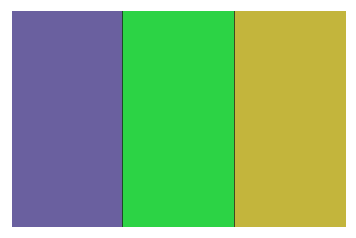

close


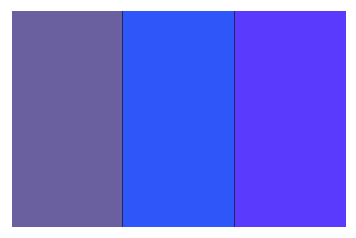

split


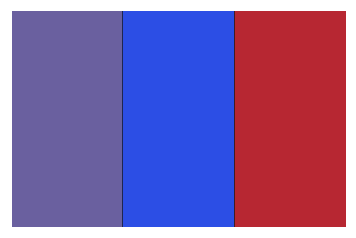

purple | prag: far | bl: far


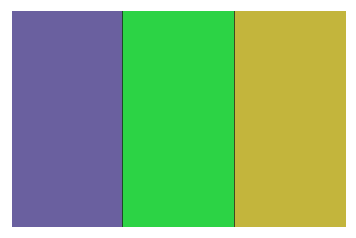

close


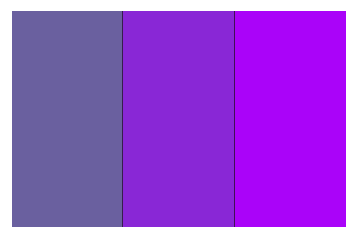

split


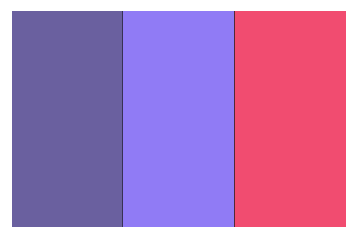

purple | prag: far | bl: far


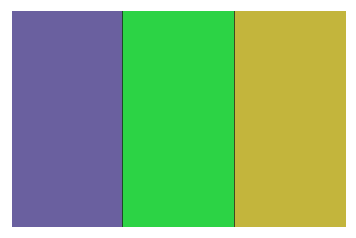

close


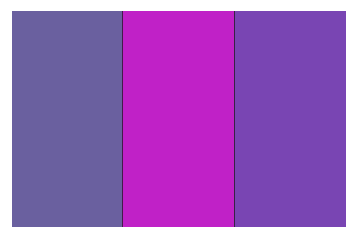

split


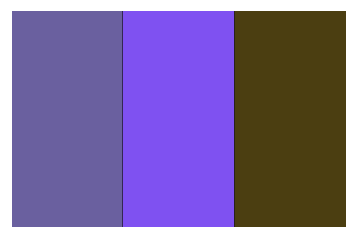

purple | prag: far | bl: far


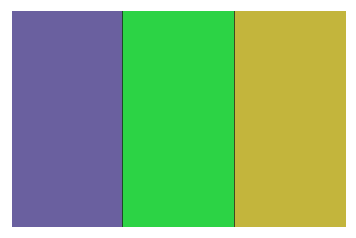

close


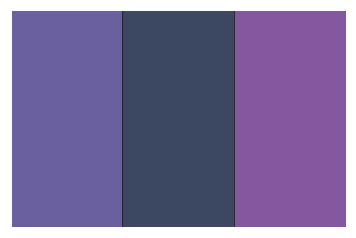

split


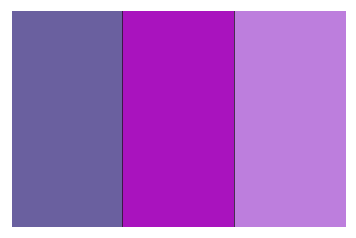

purple | prag: far | bl: far


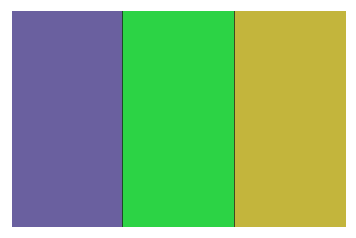

close


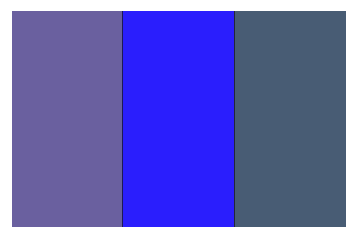

split


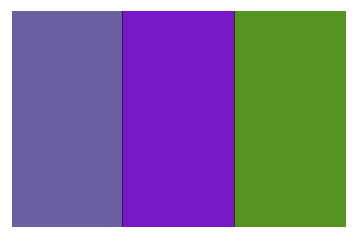

purple | prag: far | bl: far


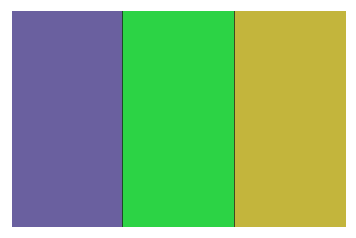

close


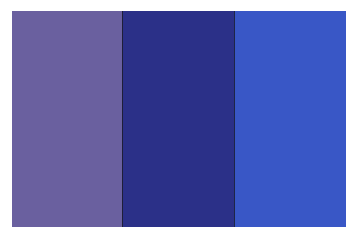

split


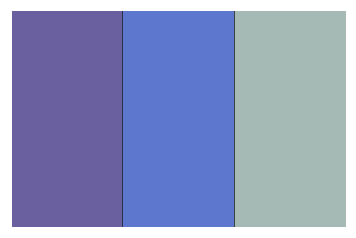

purple | prag: far | bl: far


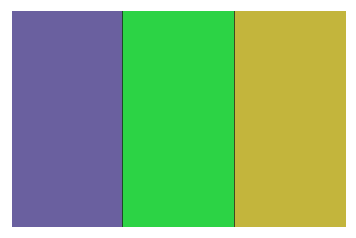

close


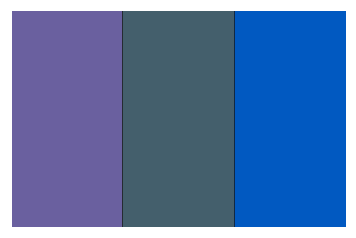

split


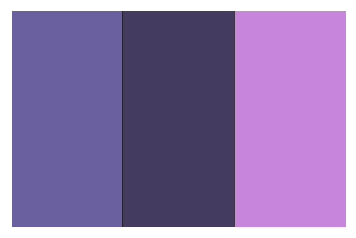

purple | prag: far | bl: far


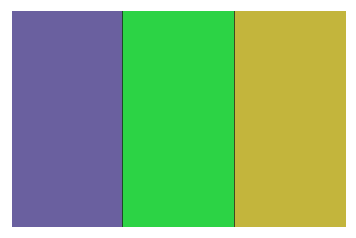

close


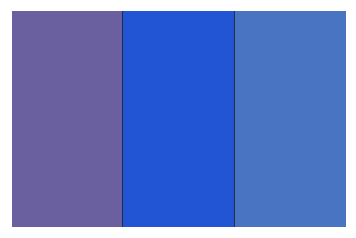

split


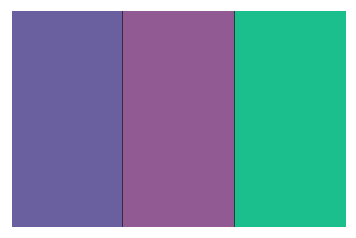

purple | prag: far | bl: far


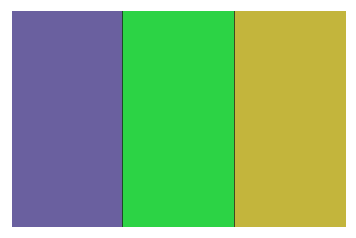

close


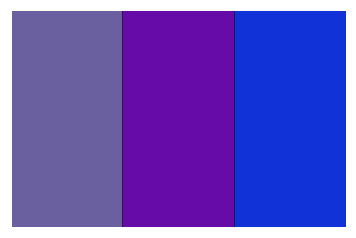

split


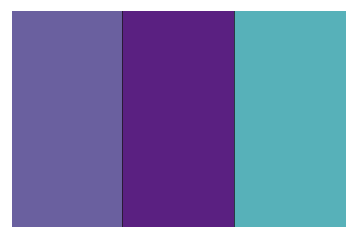

purple | prag: far | bl: far


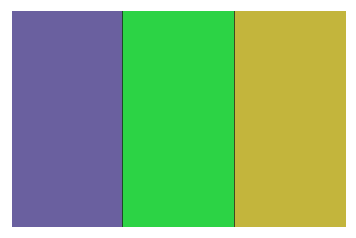

close


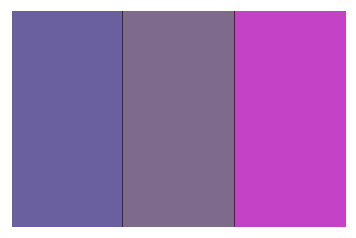

split


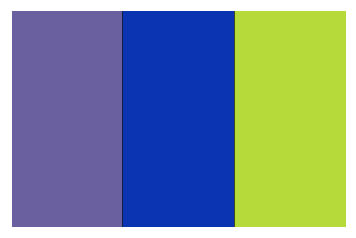

purple | prag: far | bl: far


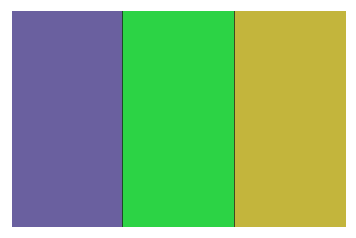

close


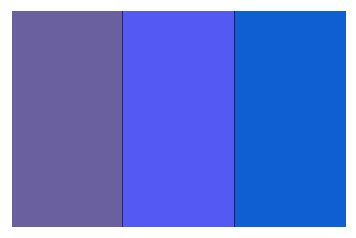

split


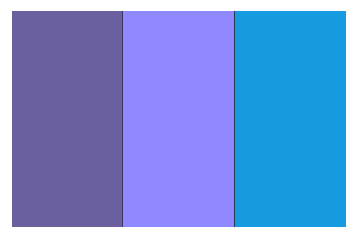

purple | prag: far | bl: far


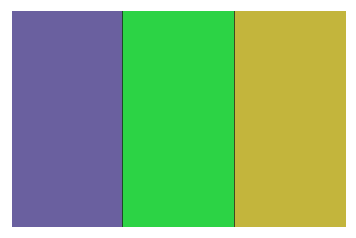

close


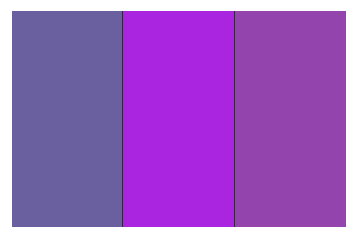

split


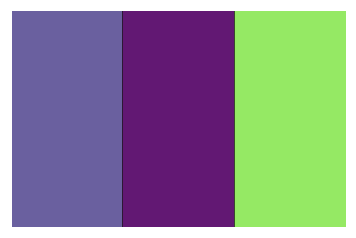

purple | prag: far | bl: far


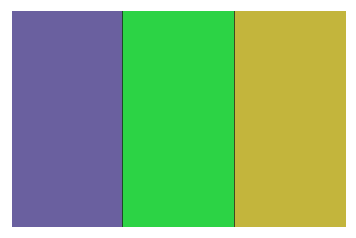

close


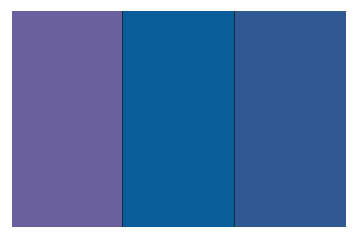

split


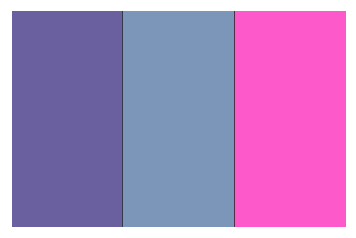

purple | prag: far | bl: far


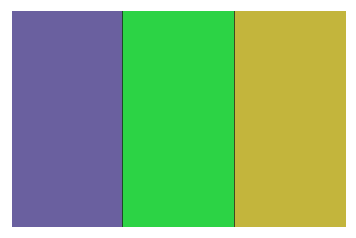

close


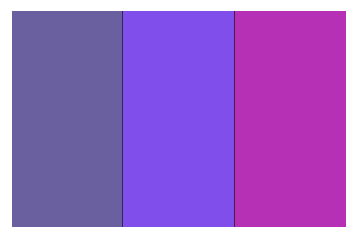

split


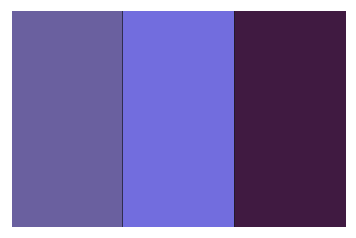

purple | prag: far | bl: far


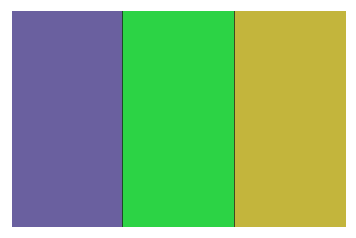

close


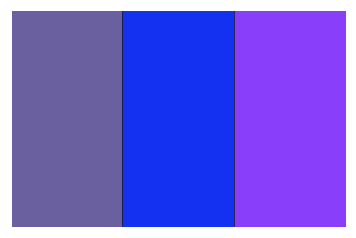

split


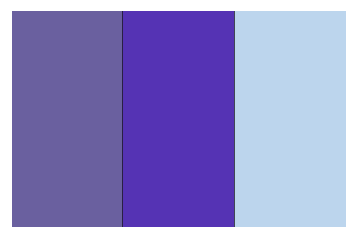

purple | prag: far | bl: far


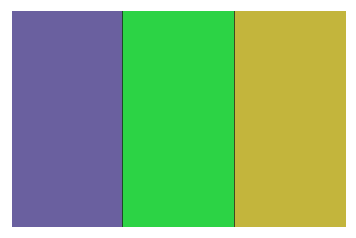

close


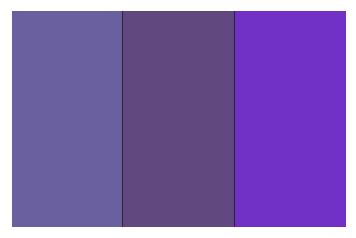

split


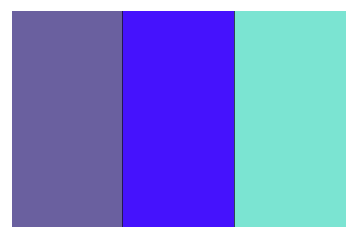

purple | prag: far | bl: far


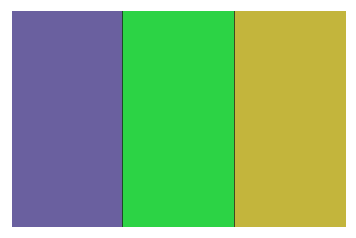

close


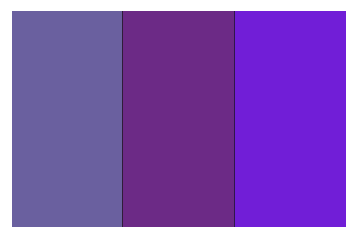

split


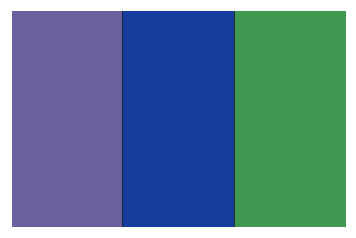

In [831]:
for i in range(50, 100):
    train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {}".format(
        train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i]))
    train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
    train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

(array([17.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0., 16.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

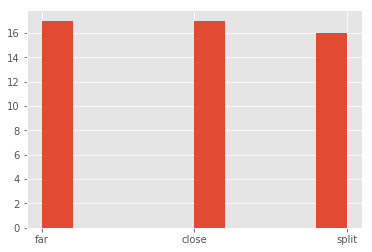

In [878]:
plt.hist(cp_preds_str_subword_50sample[50*1087:50*1088])

grey silver | prag: far | bl: split


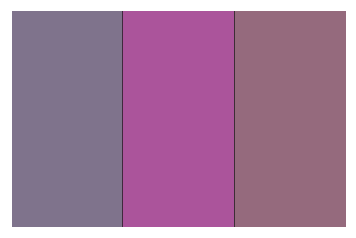

split


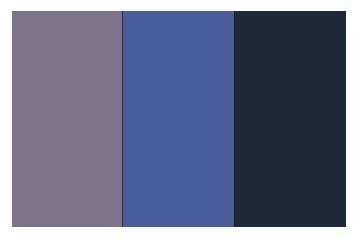

far


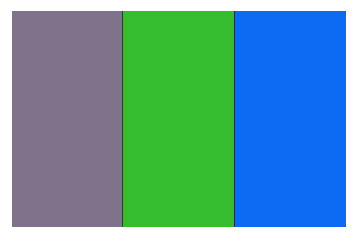

grey silver | prag: close | bl: split


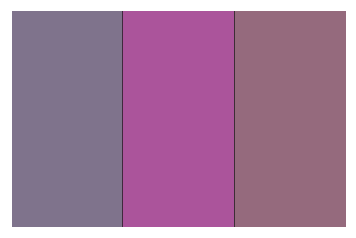

split


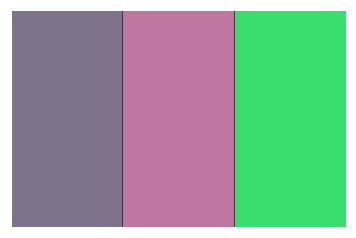

far


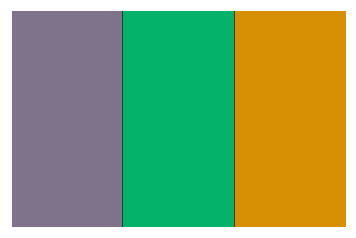

grey silver | prag: close | bl: split


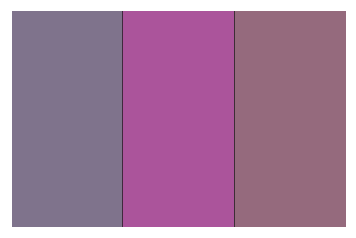

split


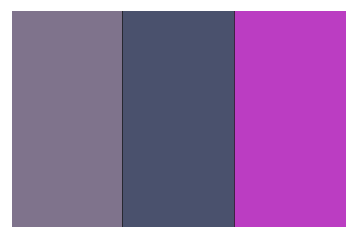

far


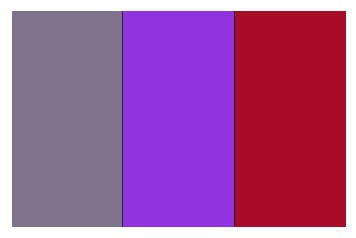

grey silver | prag: close | bl: split


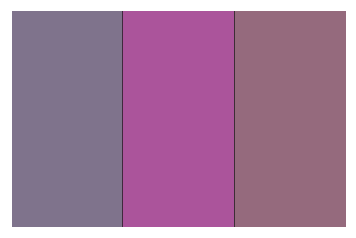

split


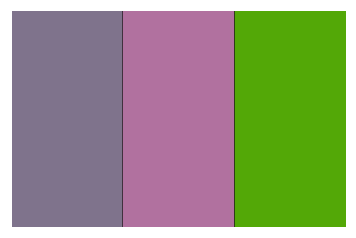

far


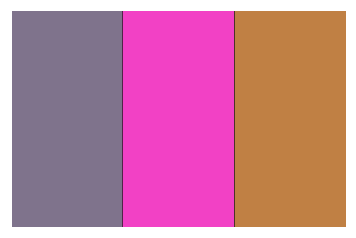

grey silver | prag: close | bl: split


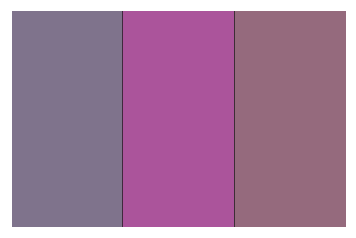

split


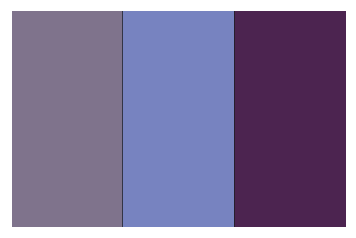

far


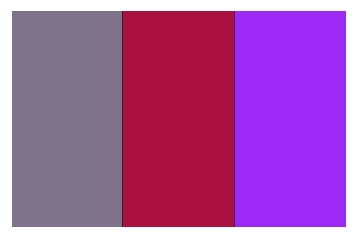

grey silver | prag: split | bl: split


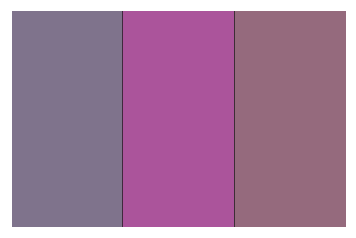

split


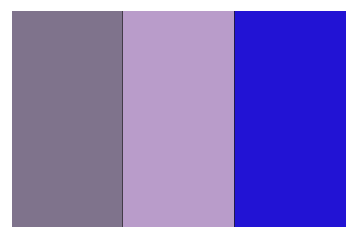

far


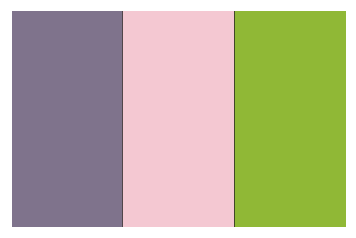

grey silver | prag: close | bl: split


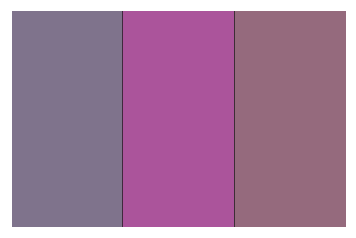

split


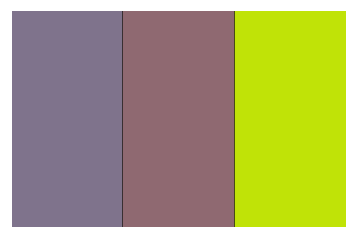

far


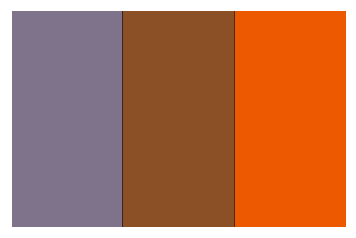

grey silver | prag: far | bl: split


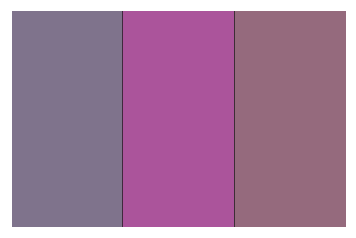

split


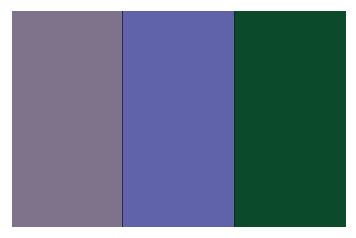

far


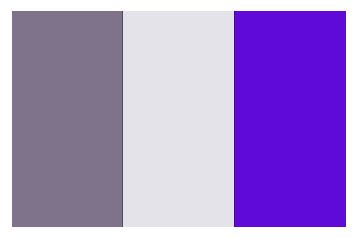

grey silver | prag: close | bl: split


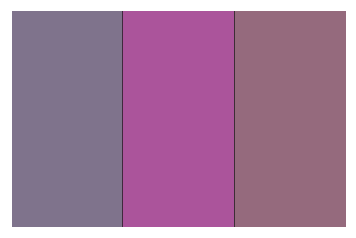

split


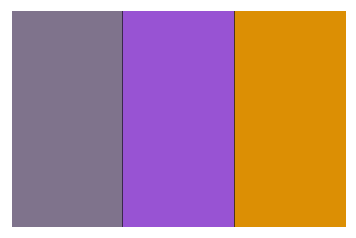

far


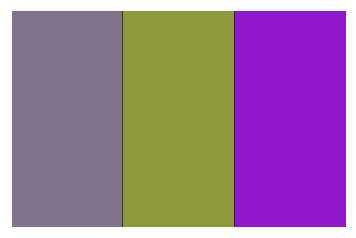

grey silver | prag: far | bl: split


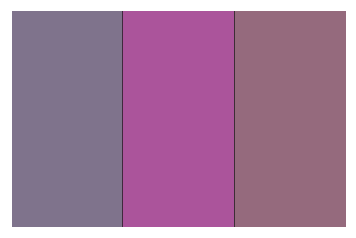

split


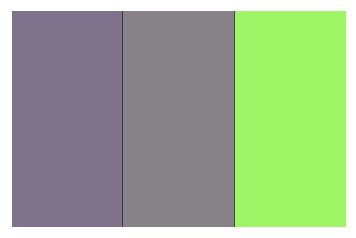

far


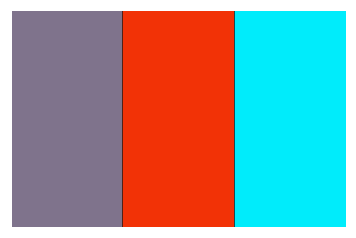

grey silver | prag: split | bl: split


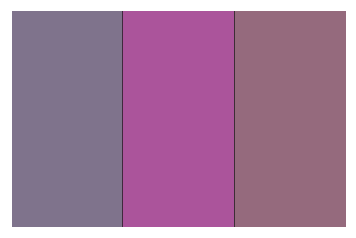

split


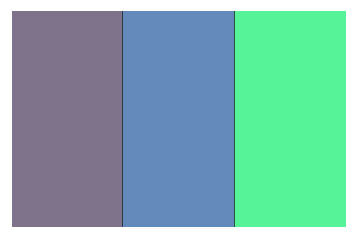

far


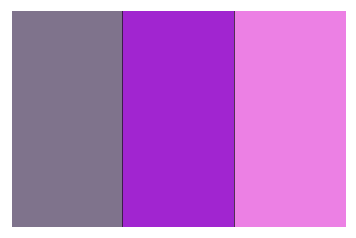

grey silver | prag: close | bl: split


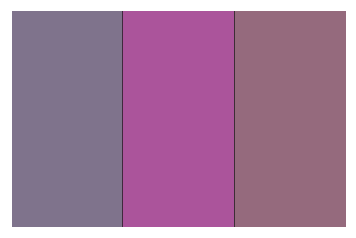

split


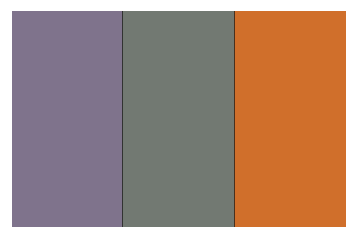

far


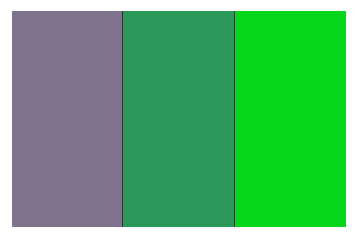

grey silver | prag: close | bl: split


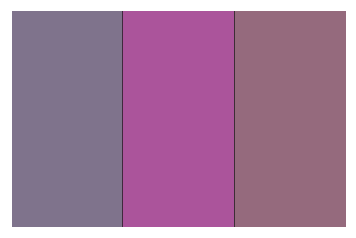

split


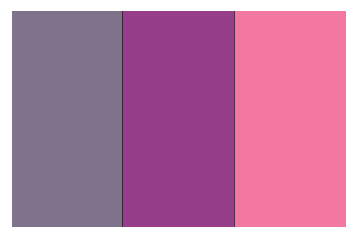

far


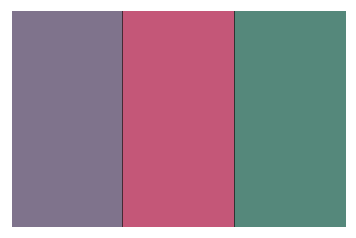

grey silver | prag: far | bl: split


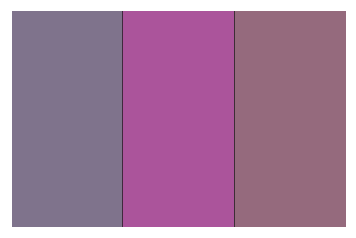

split


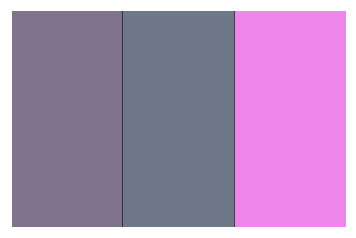

far


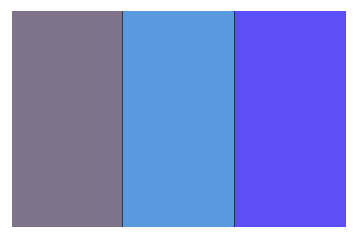

grey silver | prag: far | bl: split


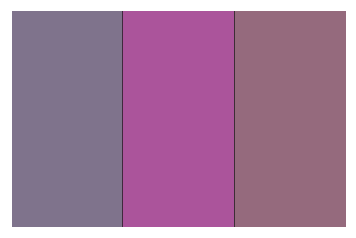

split


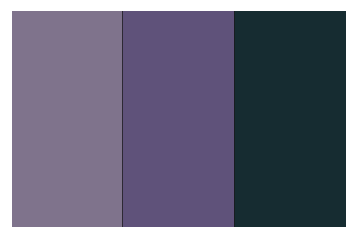

far


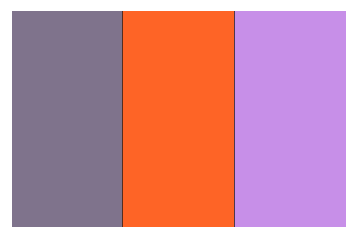

grey silver | prag: close | bl: split


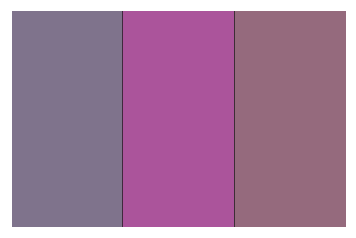

split


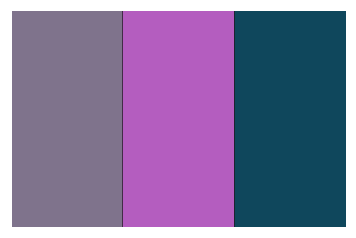

far


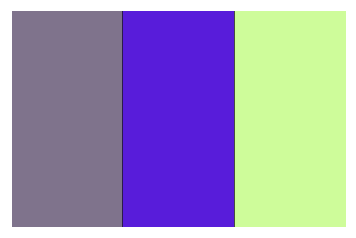

grey silver | prag: split | bl: split


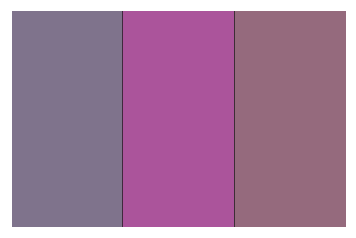

split


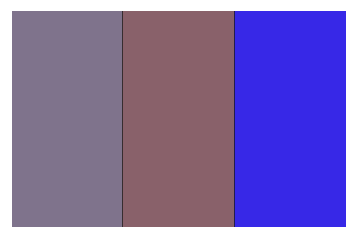

far


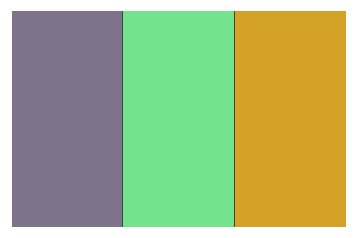

grey silver | prag: far | bl: split


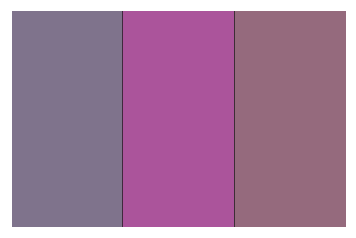

split


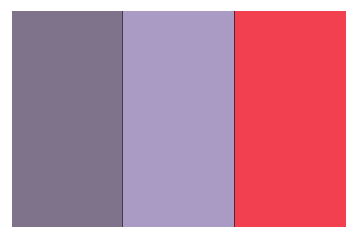

far


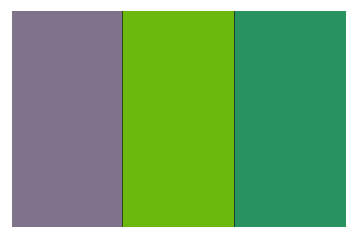

grey silver | prag: far | bl: split


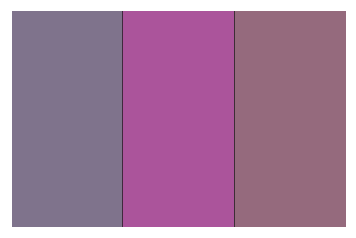

split


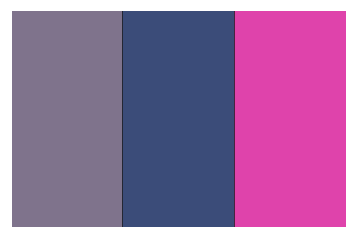

far


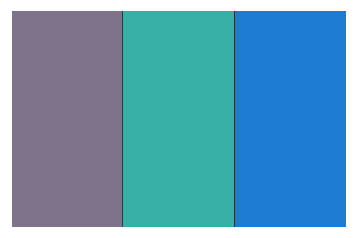

grey silver | prag: far | bl: split


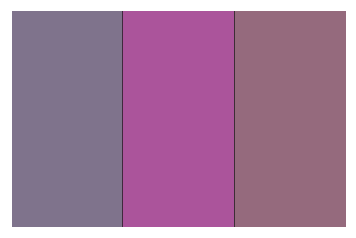

split


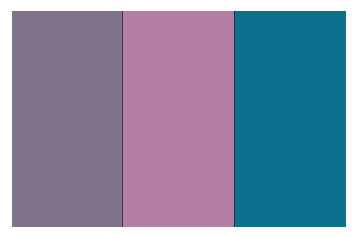

far


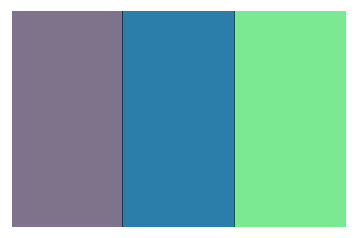

grey silver | prag: split | bl: split


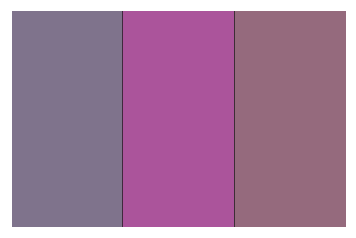

split


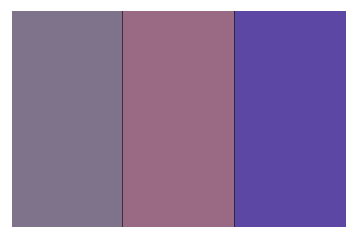

far


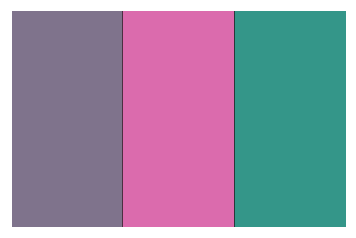

grey silver | prag: far | bl: split


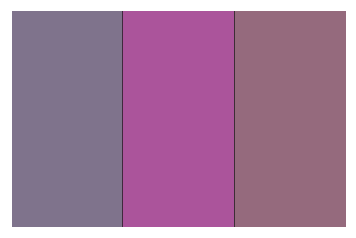

split


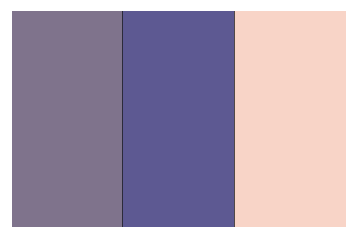

far


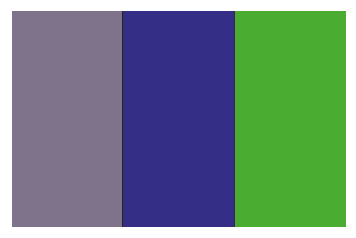

grey silver | prag: close | bl: split


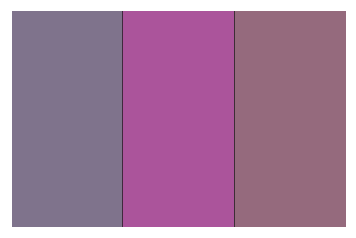

split


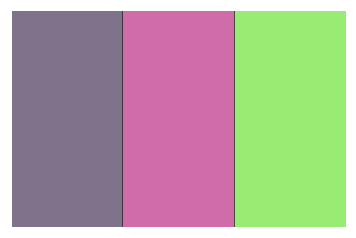

far


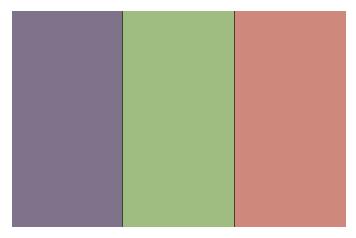

grey silver | prag: close | bl: split


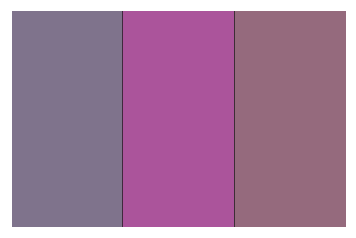

split


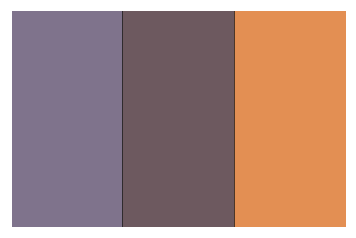

far


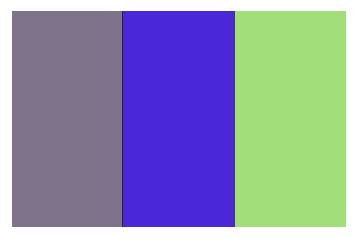

grey silver | prag: split | bl: split


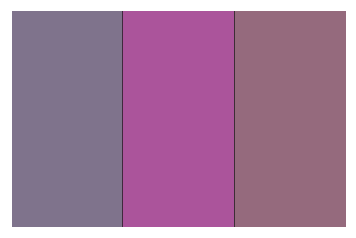

split


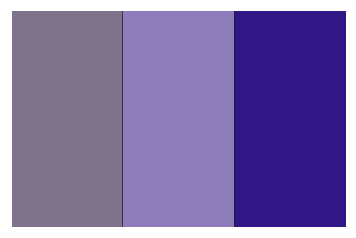

far


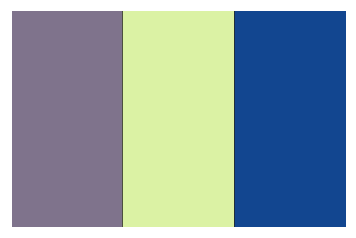

grey silver | prag: split | bl: split


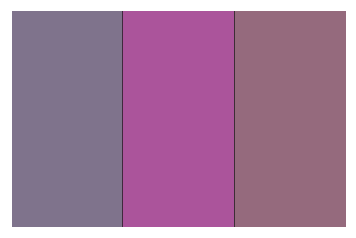

split


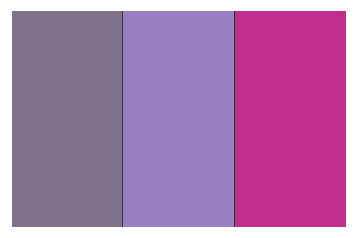

far


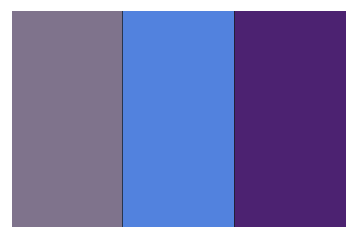

grey silver | prag: close | bl: split


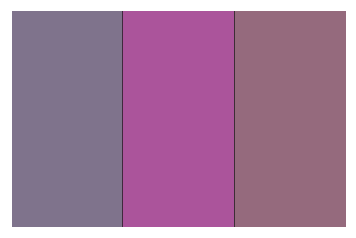

split


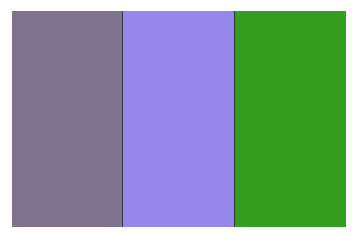

far


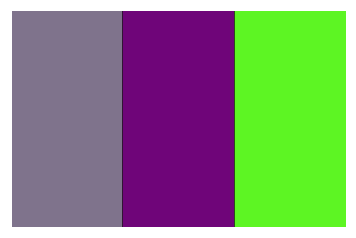

grey silver | prag: close | bl: split


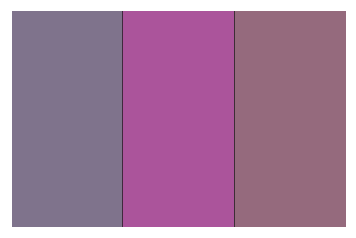

split


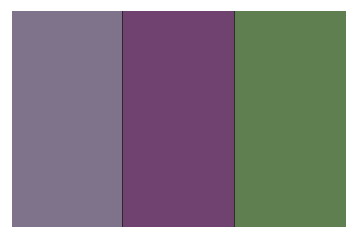

far


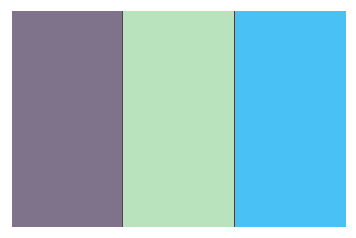

grey silver | prag: split | bl: split


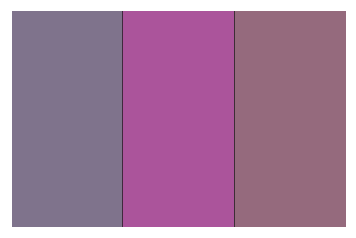

split


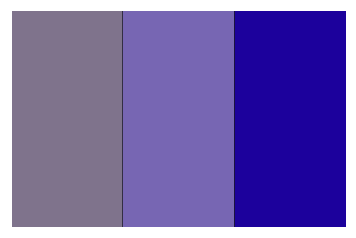

far


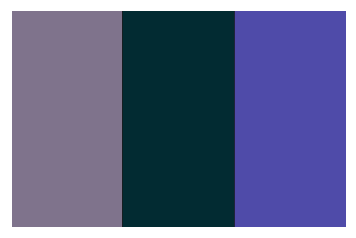

grey silver | prag: split | bl: split


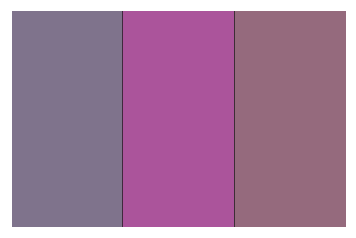

split


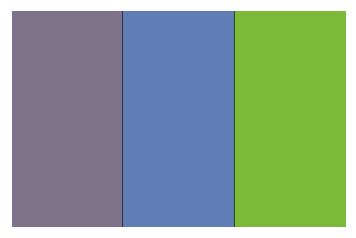

far


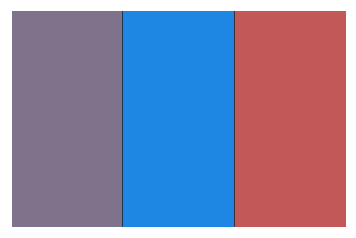

grey silver | prag: split | bl: split


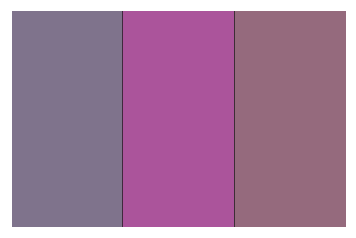

split


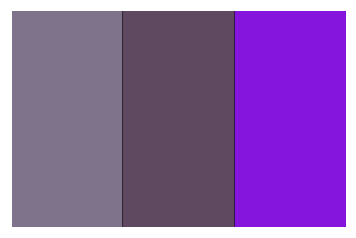

far


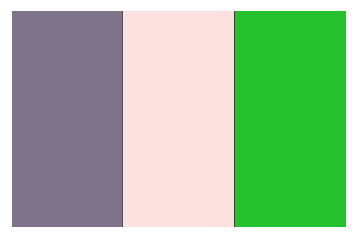

grey silver | prag: split | bl: split


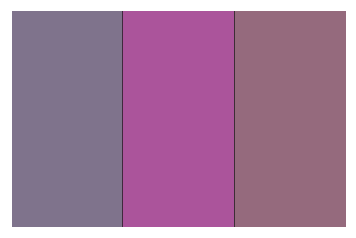

split


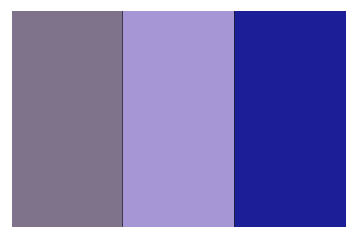

far


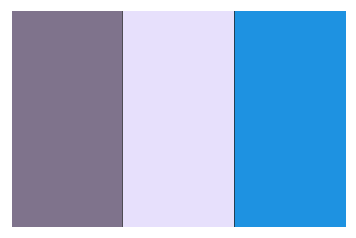

grey silver | prag: far | bl: split


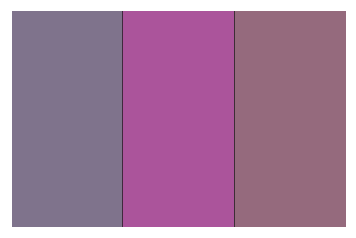

split


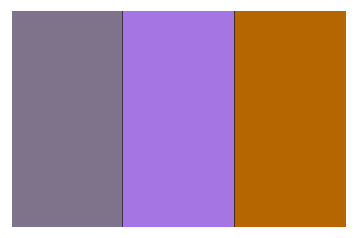

far


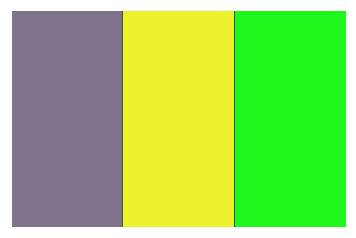

grey silver | prag: split | bl: split


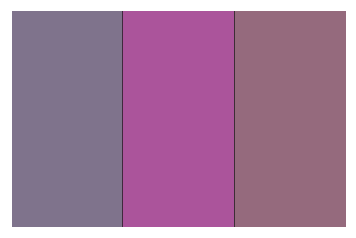

split


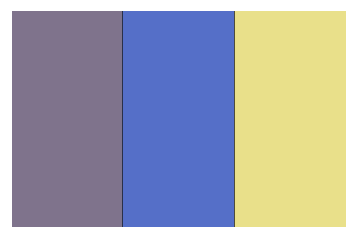

far


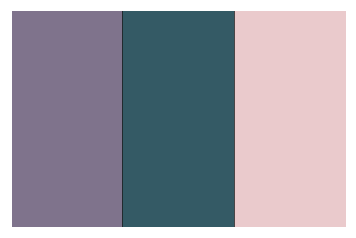

grey silver | prag: close | bl: split


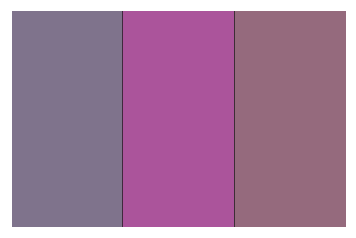

split


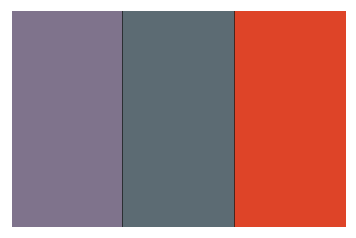

far


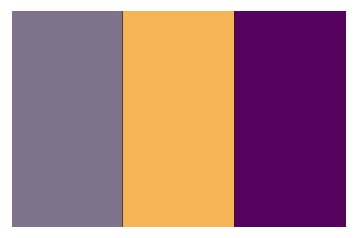

grey silver | prag: close | bl: split


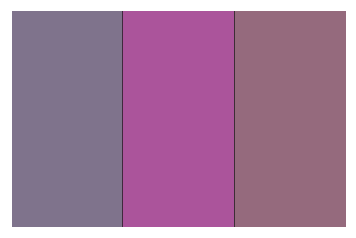

split


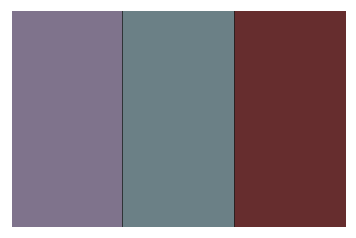

far


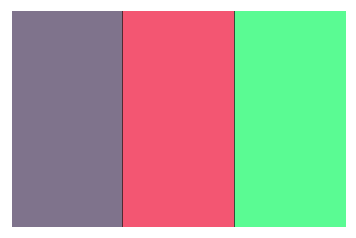

grey silver | prag: split | bl: split


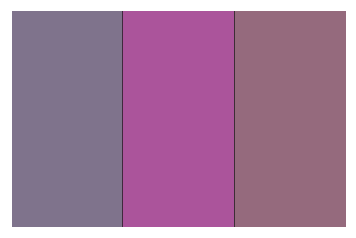

split


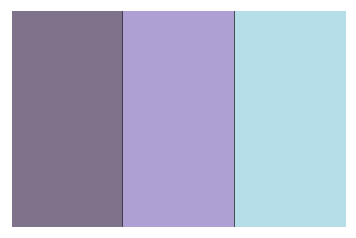

far


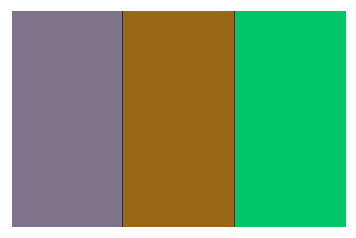

grey silver | prag: split | bl: split


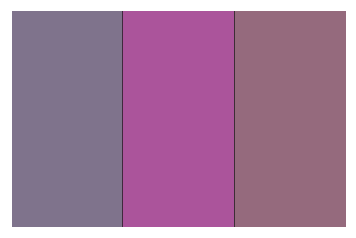

split


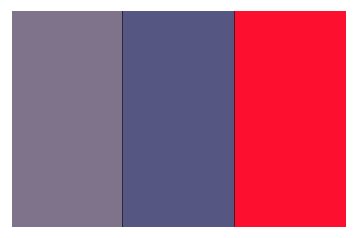

far


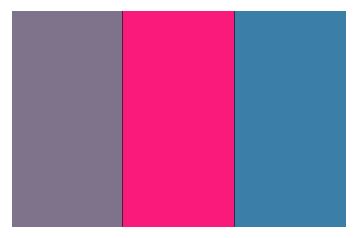

grey silver | prag: close | bl: split


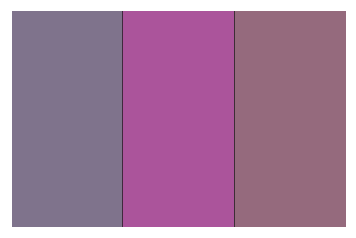

split


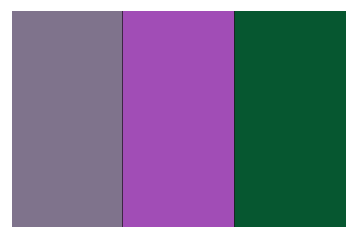

far


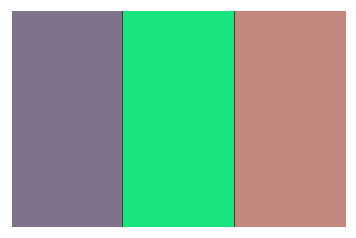

grey silver | prag: close | bl: split


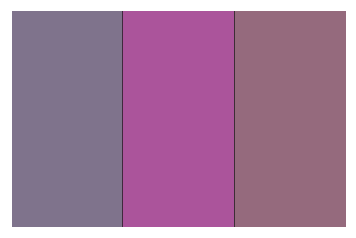

split


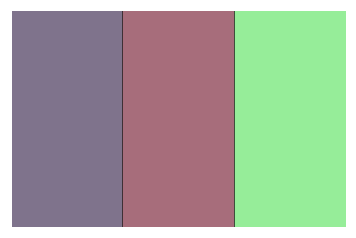

far


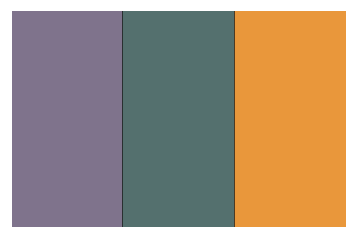

grey silver | prag: far | bl: split


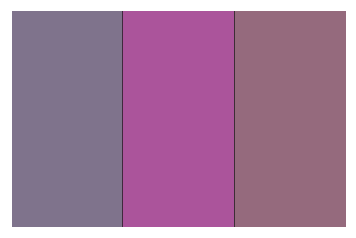

split


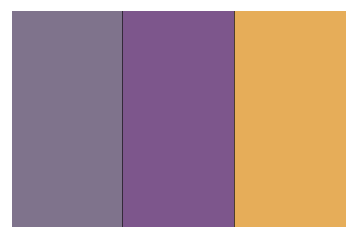

far


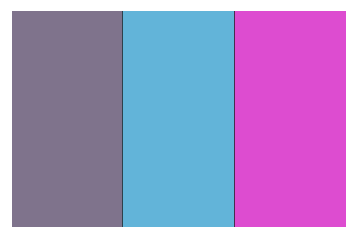

grey silver | prag: split | bl: split


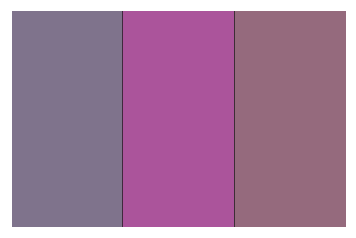

split


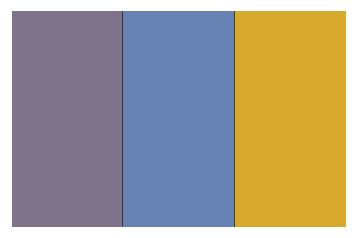

far


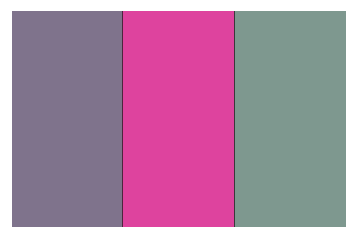

grey silver | prag: split | bl: split


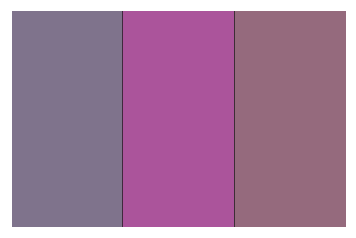

split


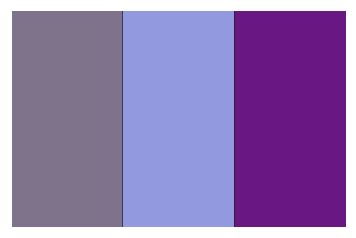

far


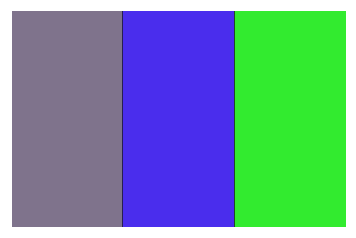

grey silver | prag: split | bl: split


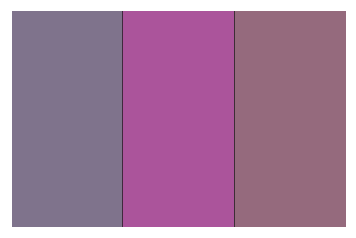

split


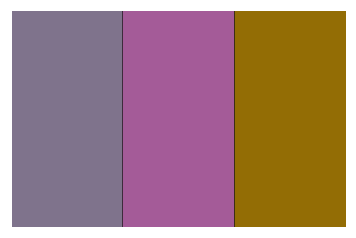

far


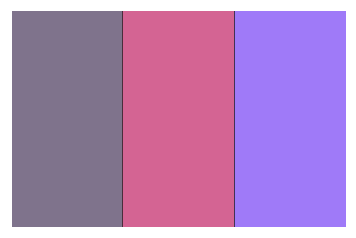

grey silver | prag: far | bl: split


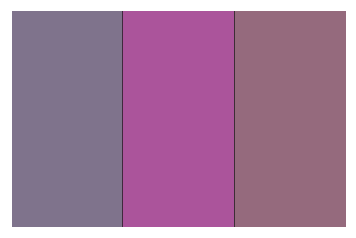

split


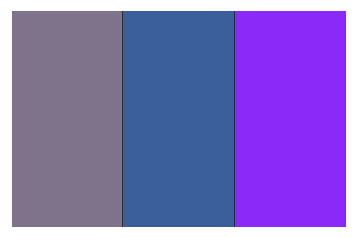

far


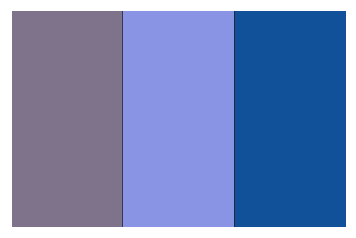

grey silver | prag: far | bl: split


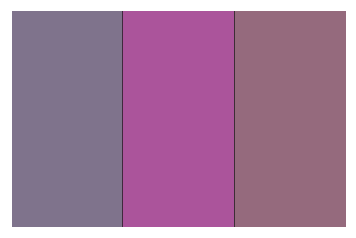

split


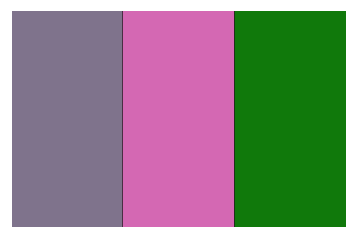

far


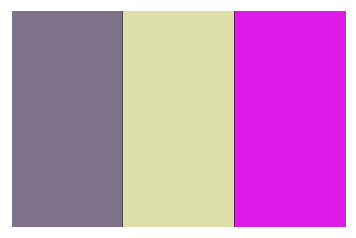

grey silver | prag: far | bl: split


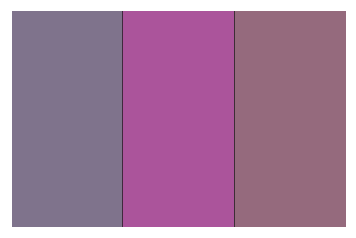

split


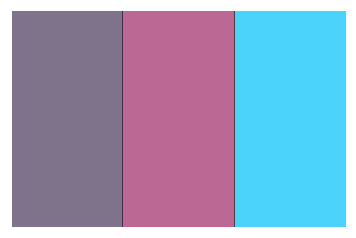

far


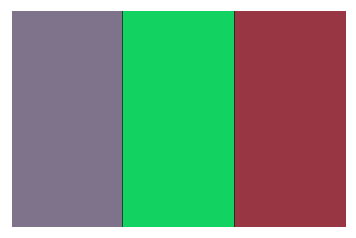

grey silver | prag: far | bl: split


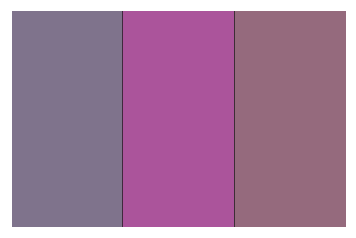

split


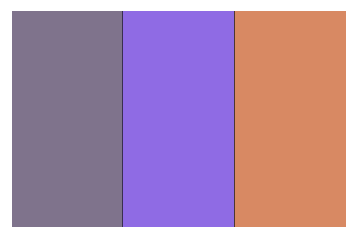

far


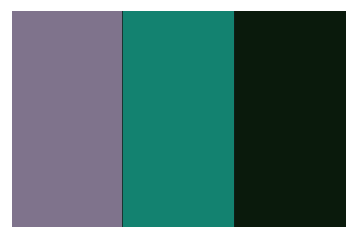

grey silver | prag: far | bl: split


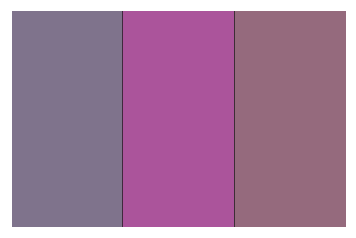

split


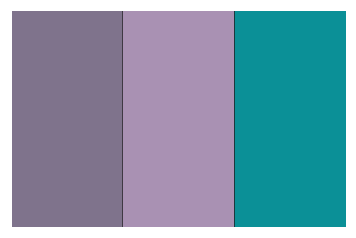

far


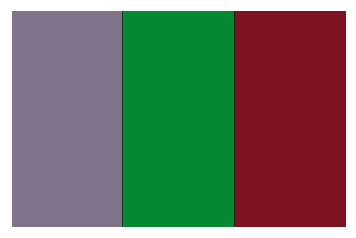

grey silver | prag: far | bl: split


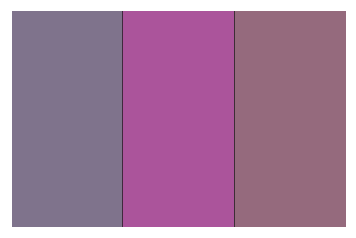

split


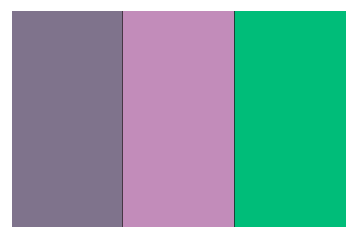

far


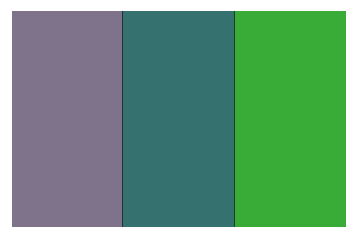

In [879]:
for i in range(50*1087, 50*1087+50):
    train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {}".format(
        train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i]))
    train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
    train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

In [834]:
np.where(cp_preds_str_subword_50sample[101:150] == "far")

(array([42]),)

Medium pink ~ the medium dark one | prag: far | bl: split | correct: False


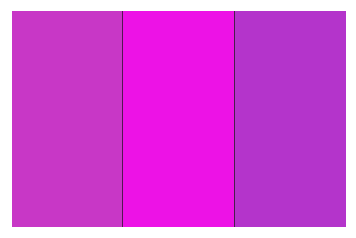

split


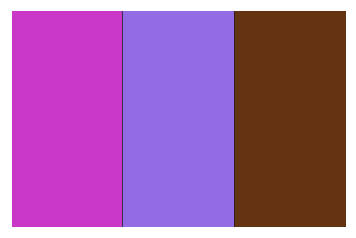

far


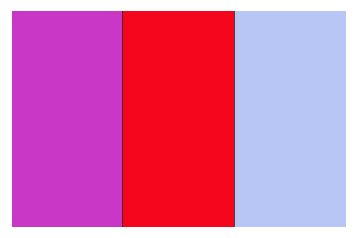

In [837]:
i=143
train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {} | correct: {}".format(
    train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i],
    train_cp_data_50sample[2*50*(i//50) + (i//50)].outcome))
train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

202) Game: 1124-1_0 Round: 3
Medium pink ~ the medium dark one


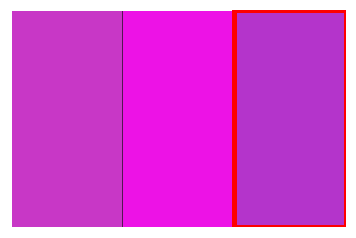

In [839]:
train_cp_data_50sample.display_game(2*50*(i//50) + (i//50))

In [810]:
50*(i//50) + (i//50)

51

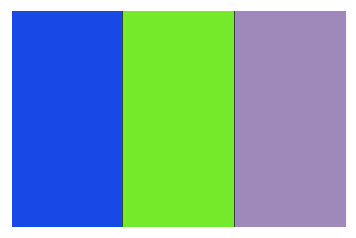

In [820]:
train_data.display_custom_game(train_cp_data_50sample[100].colors, "")

In [828]:
train_cp_data_50sample[103].condition

'split'

In [801]:
np.where(cp_preds_str_subword_50sample[:50] == "far")

(array([ 1, 23]),)

In [794]:
len(train_cp_data_50sample)

1582165

In [845]:
from scipy.stats import mode

In [849]:
modes = mode(cp_preds_str_subword_50sample.reshape(-1, 50), axis=1)

/Users/benjaminnewman/.local/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [850]:
modes[:5]

(array([['split'],
        ['far'],
        ['close'],
        ...,
        ['split'],
        ['far'],
        ['far']], dtype='<U5'), array([[33],
        [50],
        [49],
        ...,
        [39],
        [40],
        [21]]))

In [851]:
modes_result, modes_counts = modes

In [852]:
modes_result[:10]

array([['split'],
       ['far'],
       ['close'],
       ['close'],
       ['close'],
       ['far'],
       ['split'],
       ['far'],
       ['close'],
       ['far']], dtype='<U5')

In [853]:
len(modes_result)

15665

In [858]:
print(classification_report(modes_result.reshape(-1), cp_preds_str_subword_baseline))

              precision    recall  f1-score   support

       close       0.58      0.25      0.35      6253
         far       0.49      0.86      0.62      5026
       split       0.33      0.31      0.32      4386

   micro avg       0.46      0.46      0.46     15665
   macro avg       0.46      0.47      0.43     15665
weighted avg       0.48      0.46      0.43     15665



In [864]:
modes_triples = []

for i in range(len(modes_result)):
    modes_triples.append((i, modes_result[i][0], modes_counts[i][0]))

In [862]:
modes_triples[0]

(0, 'split', 33)

In [865]:
len(modes_triples)

15665

In [866]:
sorted_modes_triples = sorted(modes_triples, key=lambda x: x[2])

In [867]:
sorted_modes_triples[0]

(1087, 'close', 17)

In [870]:
modes_df = pd.DataFrame(sorted_modes_triples, columns = ["orig_index", "pred_condition", "count"])

In [871]:
modes_df.head()

,orig_index,pred_condition,count
0,1087,close,17
1,1141,close,17
2,1289,close,17
3,3309,close,17
4,4355,close,17


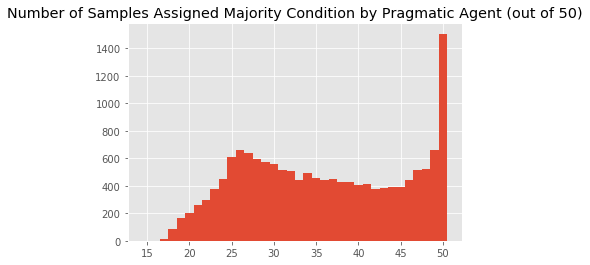

In [1067]:
bins = np.arange(15, modes_df["count"].max() + 1.5) - 0.5

plt.hist(modes_df["count"], bins)
plt.title("Number of Samples Assigned Majority Condition by Pragmatic Agent (out of 50)")
plt.show()

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


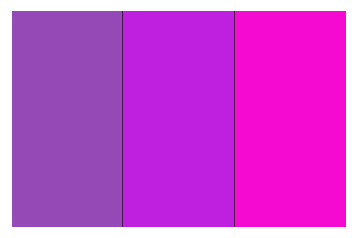

split


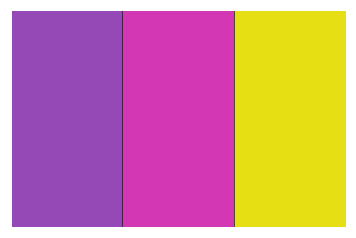

far


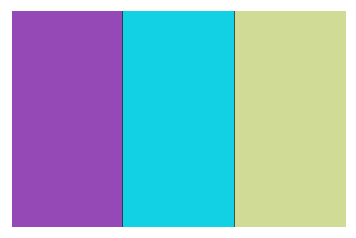

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


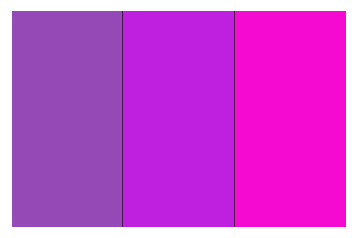

split


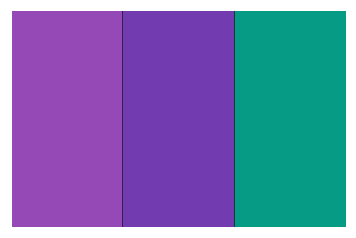

far


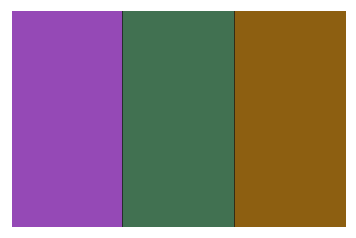

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


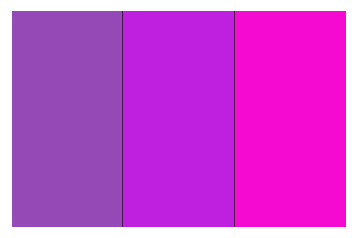

split


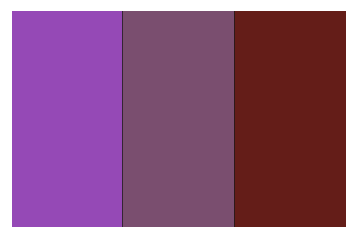

far


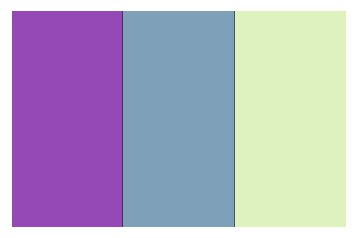

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


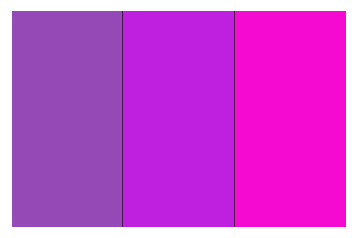

split


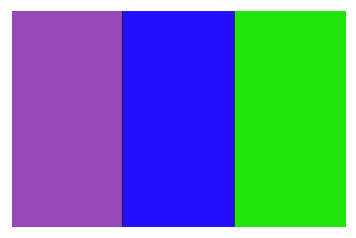

far


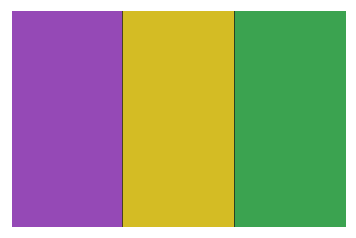

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


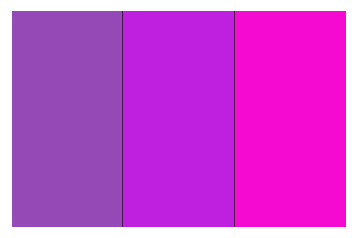

split


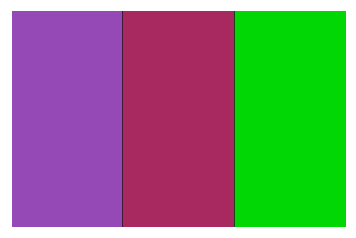

far


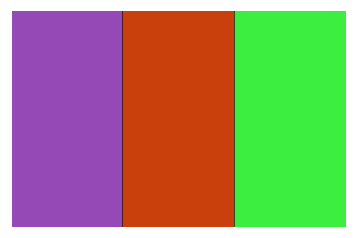

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


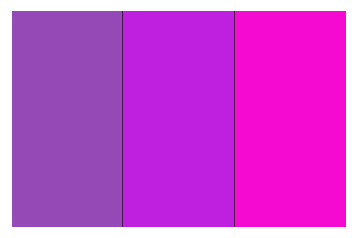

split


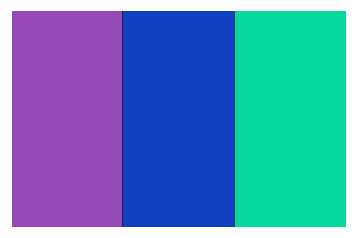

far


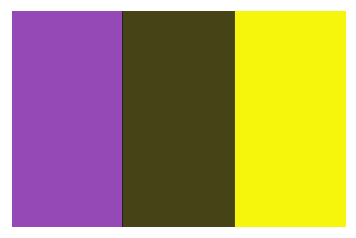

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


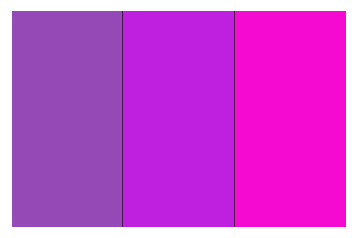

split


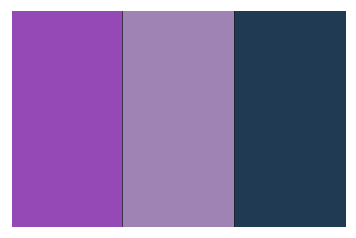

far


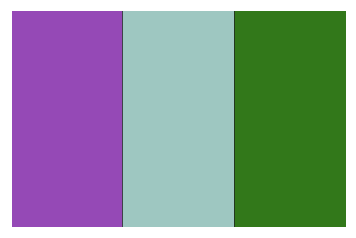

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


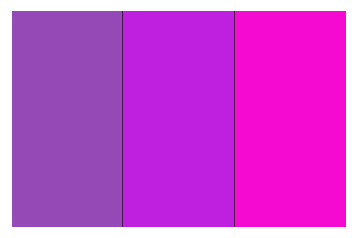

split


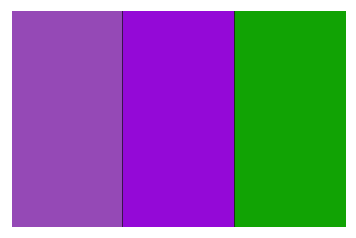

far


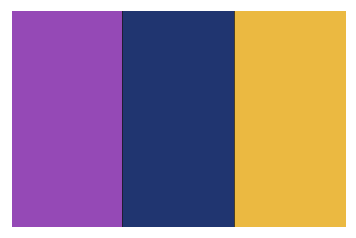

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


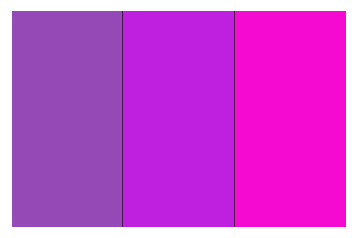

split


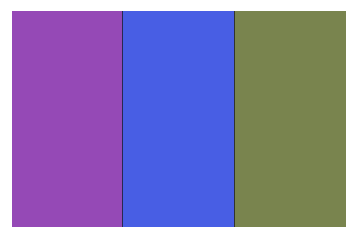

far


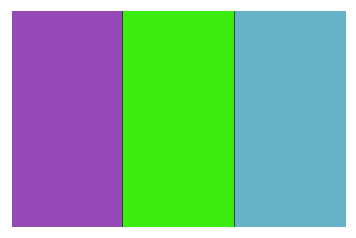

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


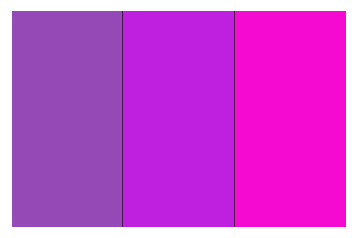

split


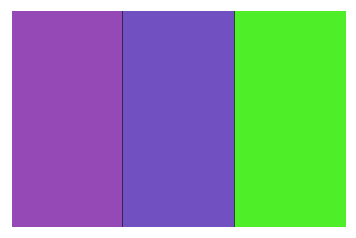

far


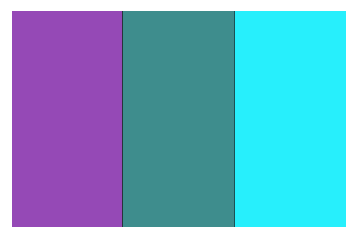

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


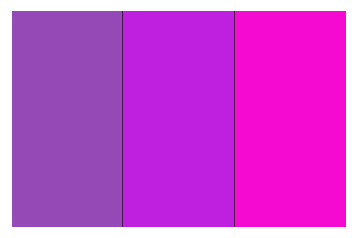

split


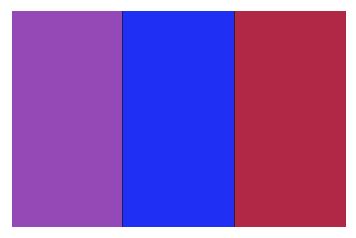

far


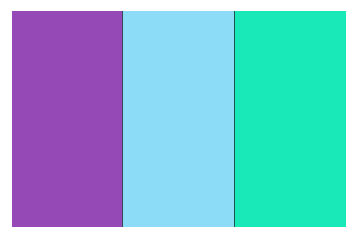

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


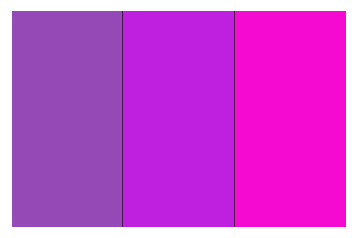

split


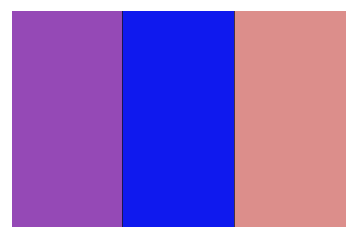

far


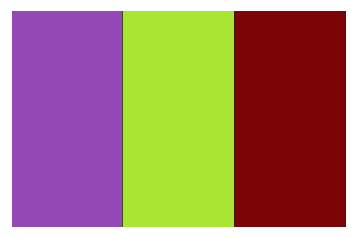

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


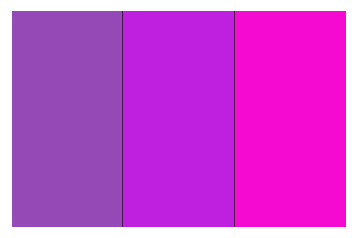

split


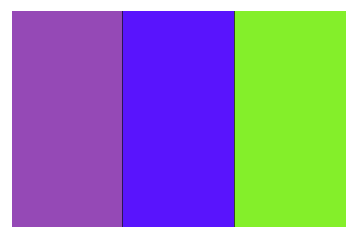

far


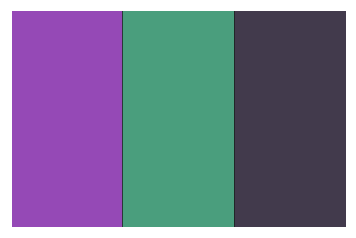

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


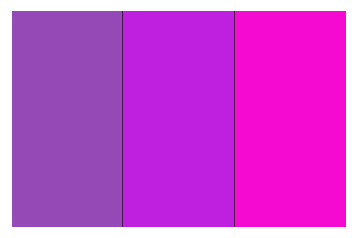

split


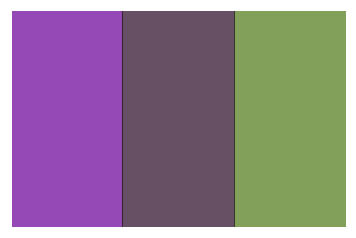

far


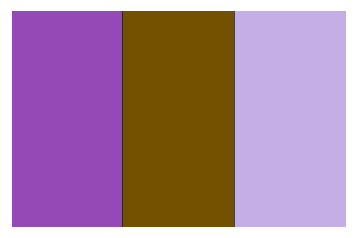

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


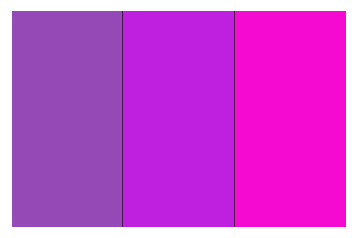

split


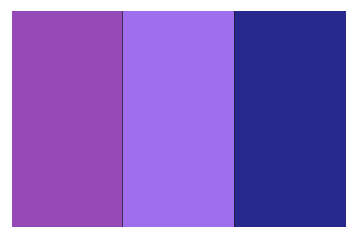

far


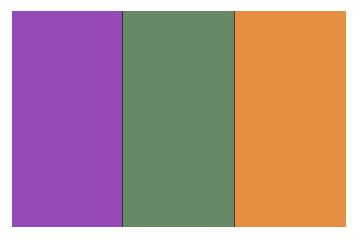

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


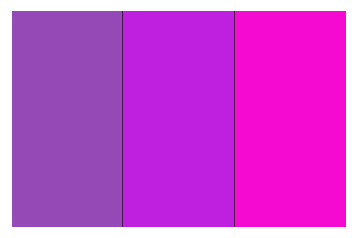

split


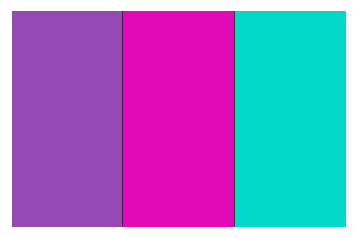

far


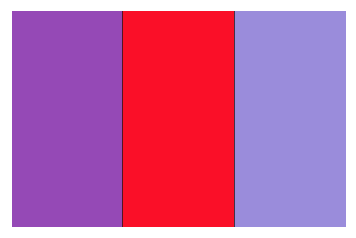

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


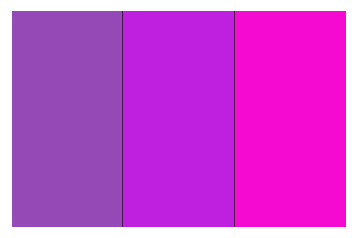

split


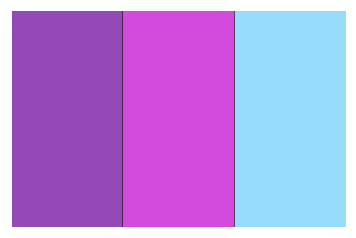

far


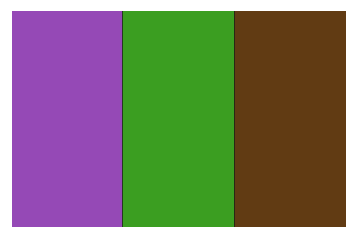

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


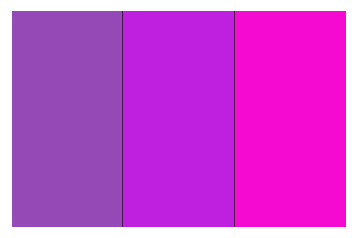

split


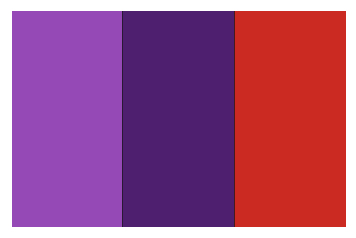

far


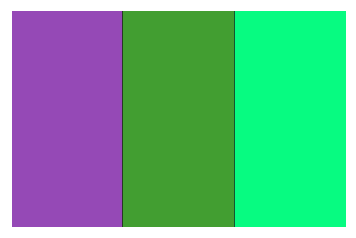

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


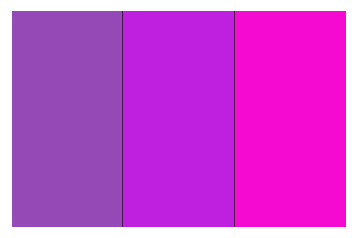

split


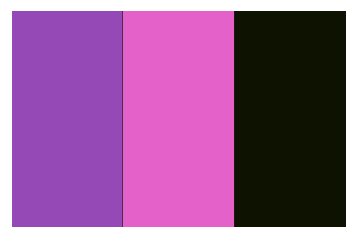

far


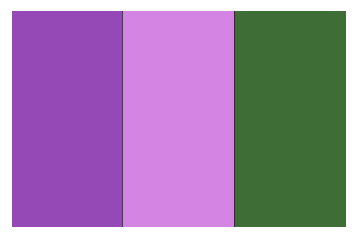

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


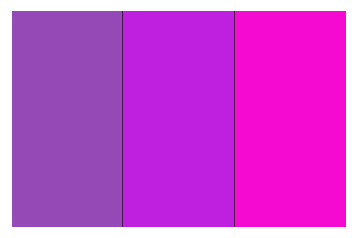

split


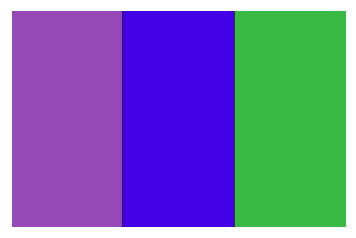

far


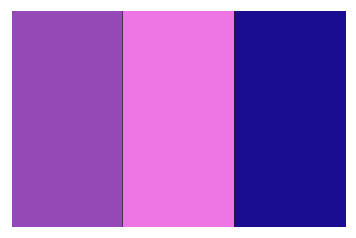

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


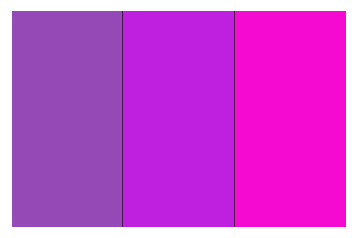

split


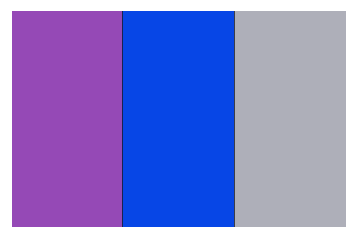

far


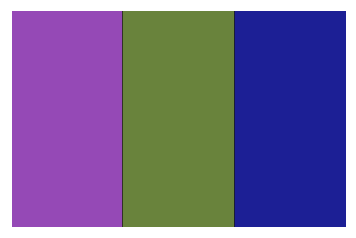

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


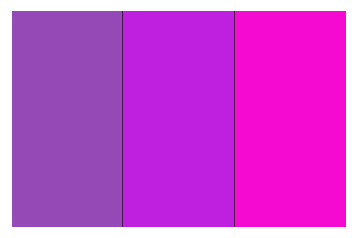

split


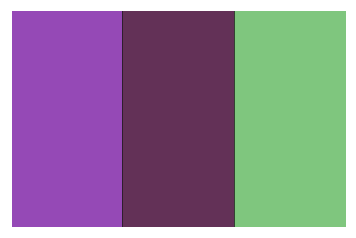

far


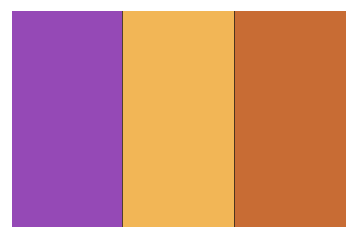

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


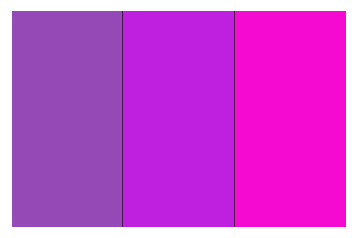

split


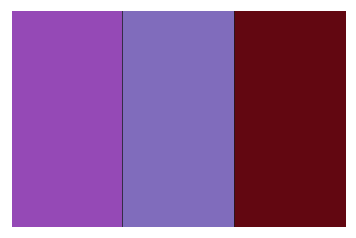

far


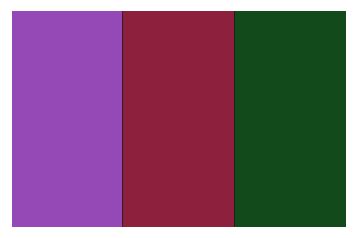

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


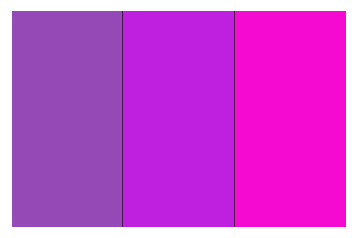

split


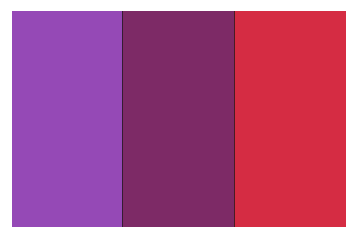

far


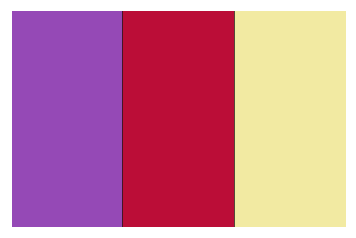

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


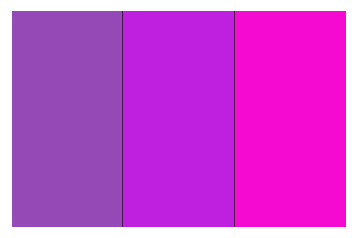

split


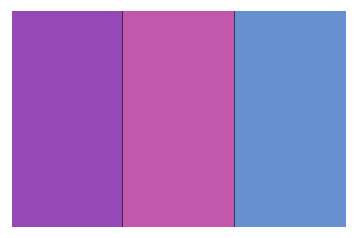

far


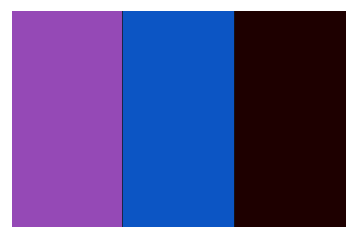

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


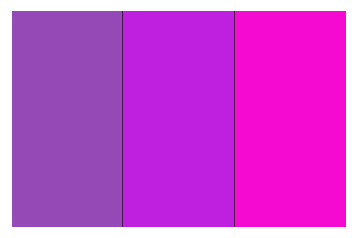

split


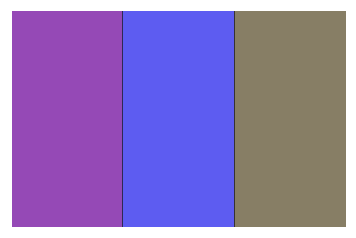

far


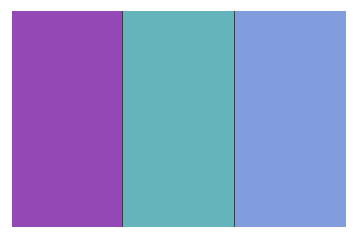

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


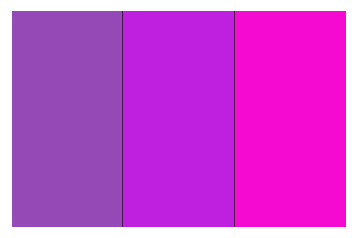

split


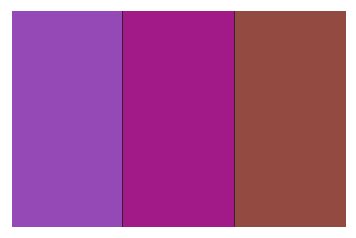

far


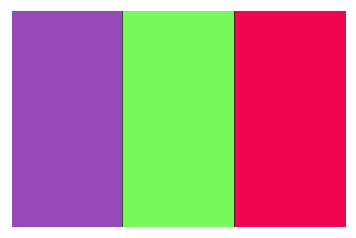

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


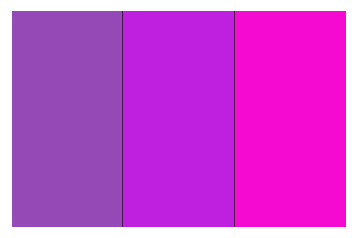

split


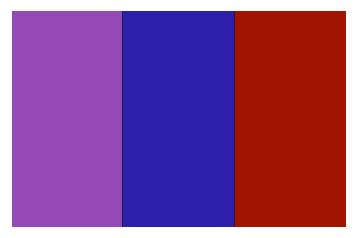

far


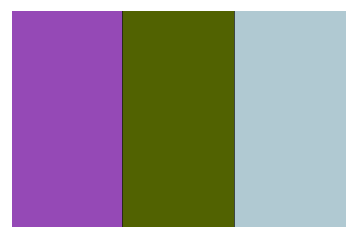

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


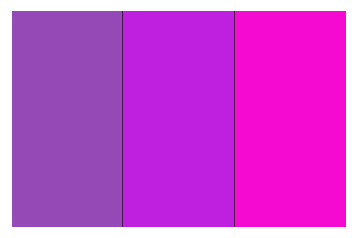

split


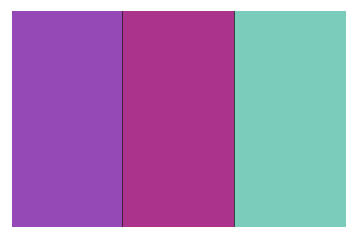

far


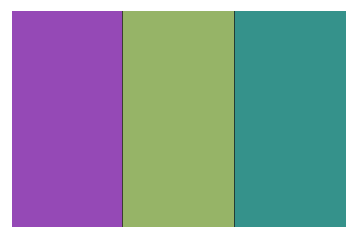

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


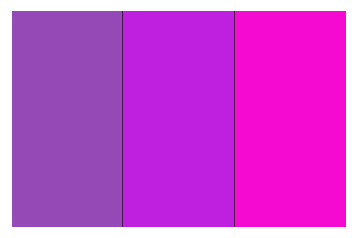

split


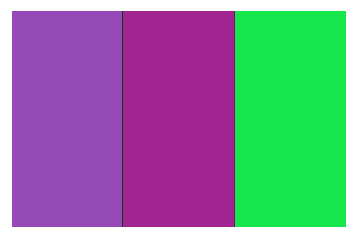

far


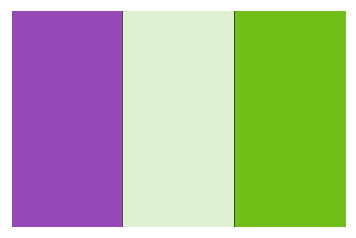

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


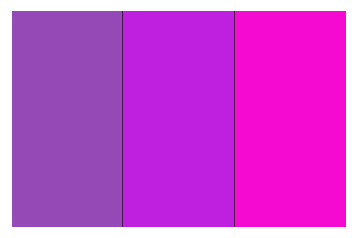

split


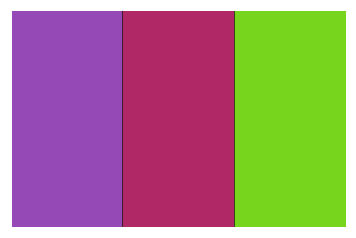

far


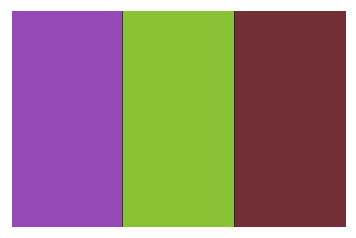

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


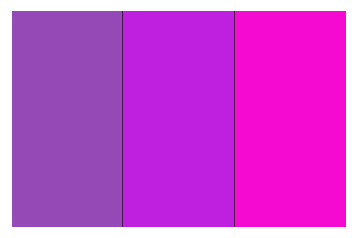

split


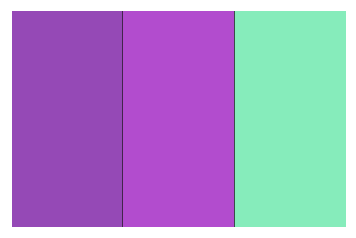

far


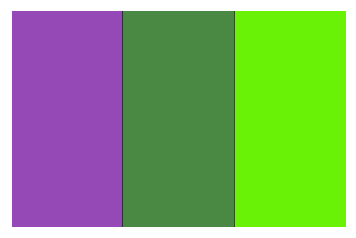

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


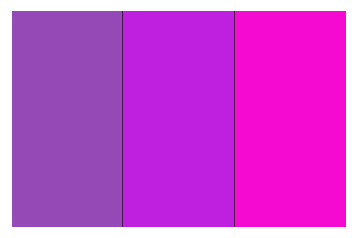

split


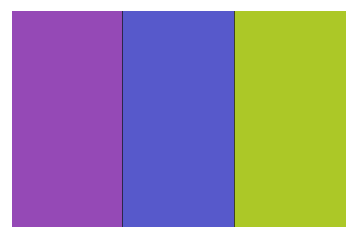

far


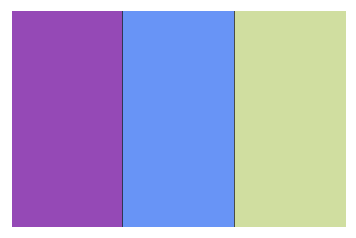

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


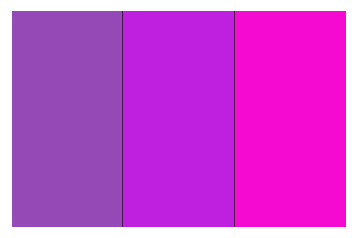

split


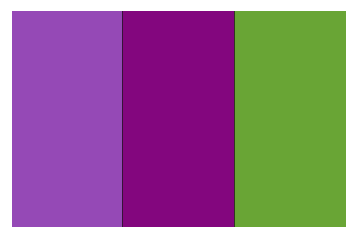

far


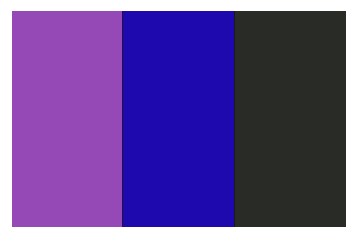

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


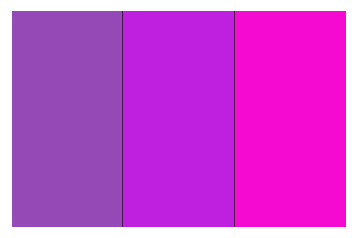

split


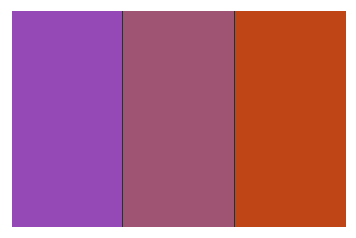

far


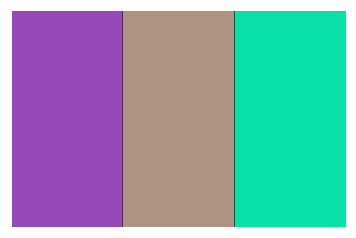

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


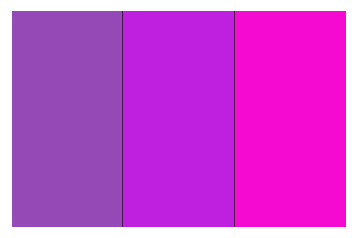

split


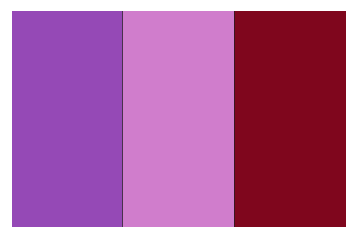

far


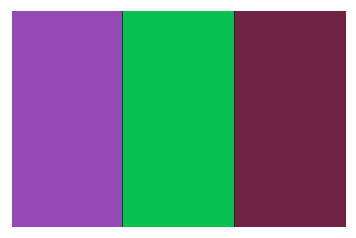

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


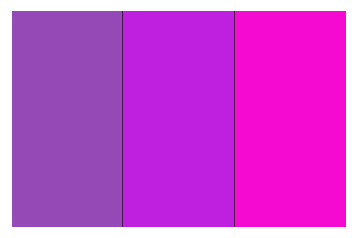

split


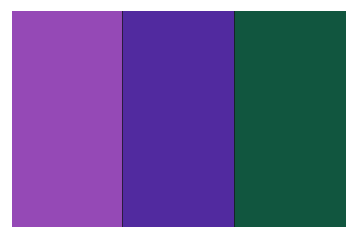

far


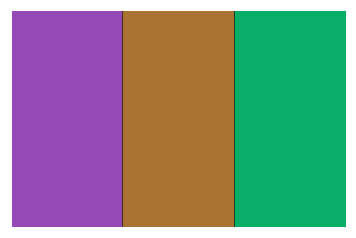

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


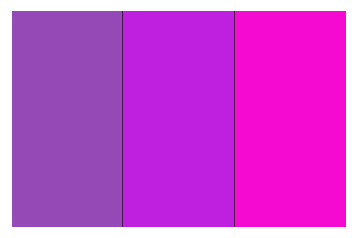

split


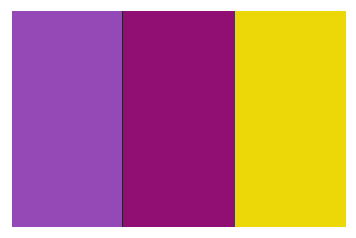

far


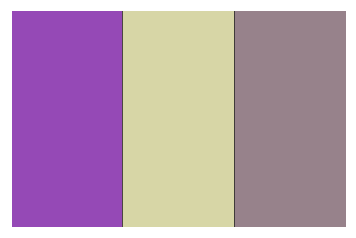

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


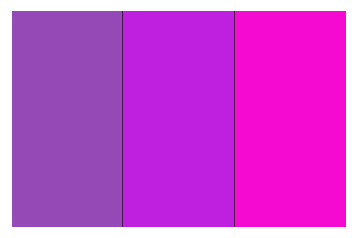

split


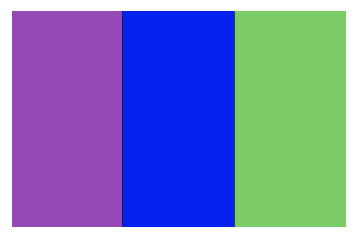

far


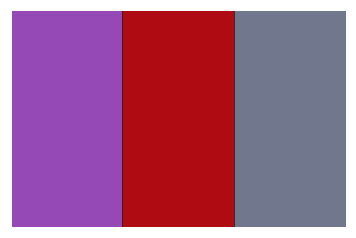

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


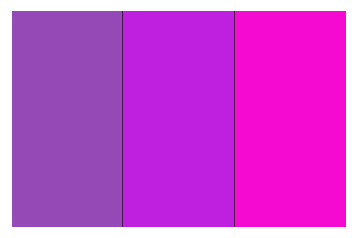

split


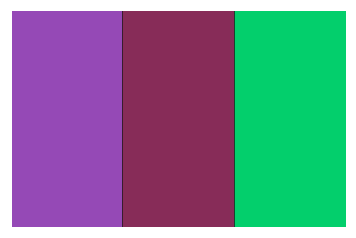

far


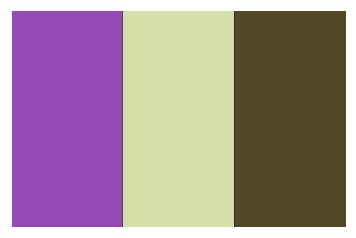

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


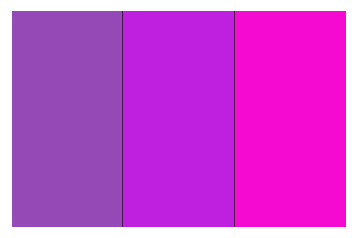

split


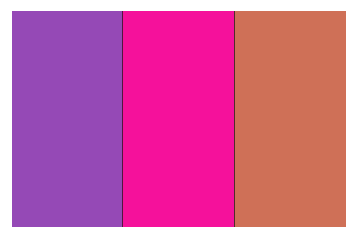

far


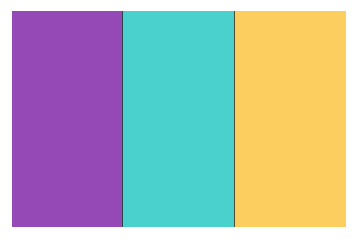

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


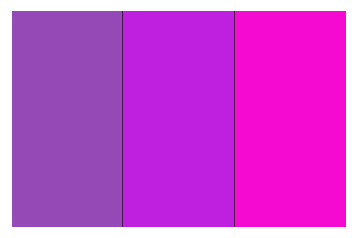

split


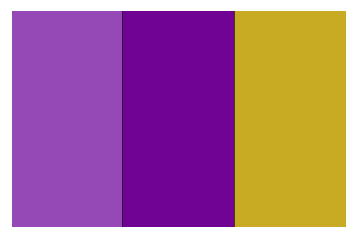

far


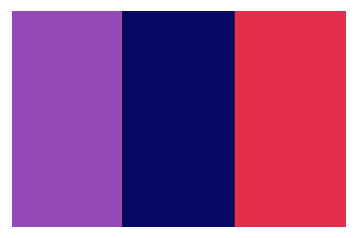

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


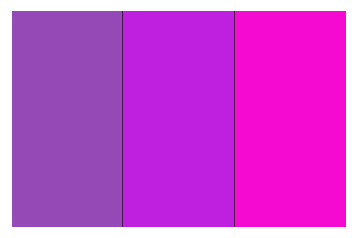

split


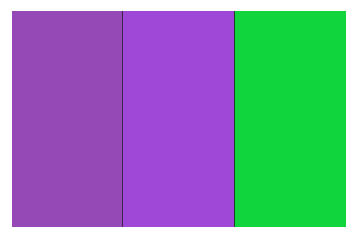

far


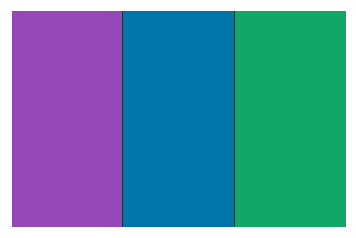

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


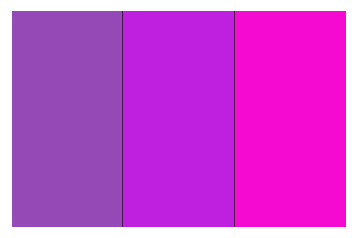

split


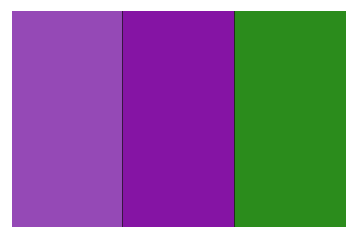

far


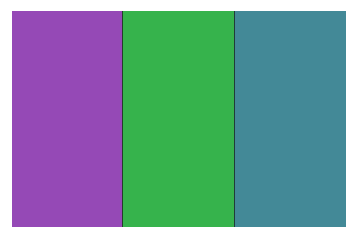

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


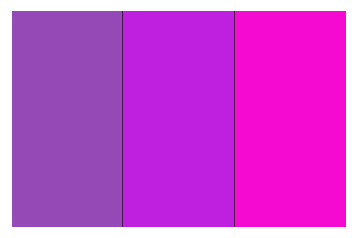

split


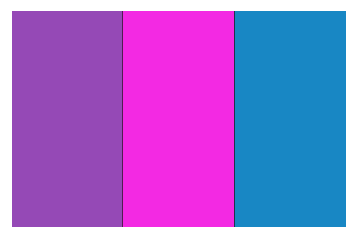

far


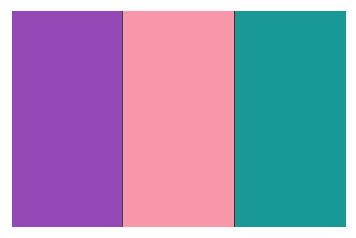

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


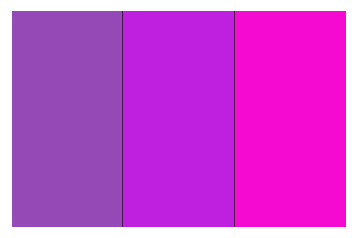

split


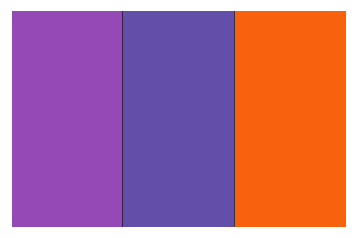

far


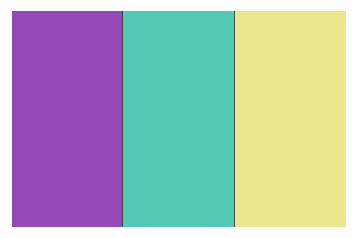

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


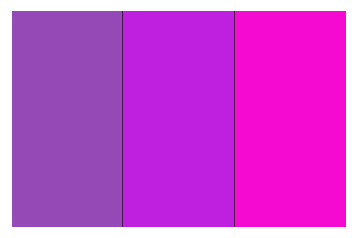

split


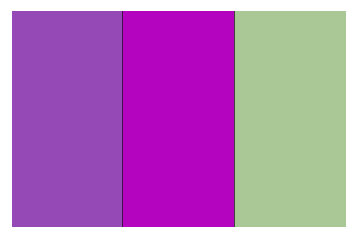

far


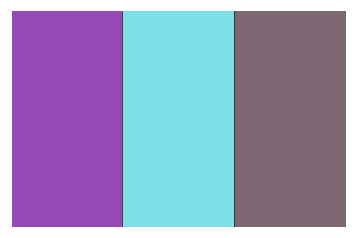

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: far | bl: close


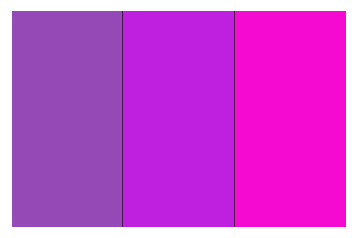

split


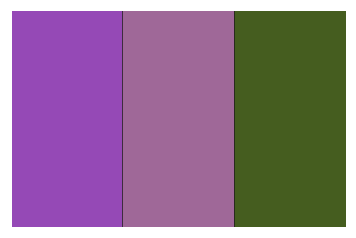

far


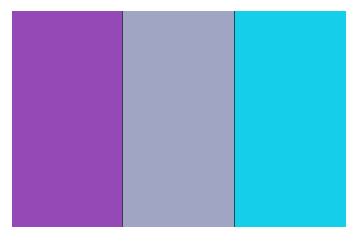

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: close | bl: close


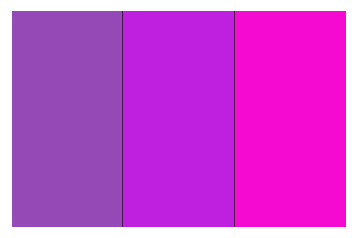

split


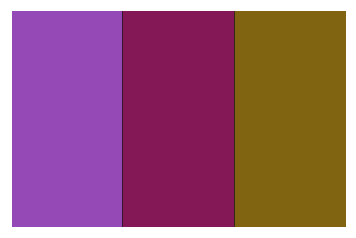

far


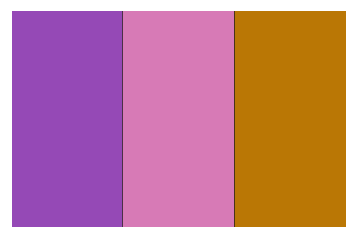

OK.  Not Neon Magenta. ~ It is the darker purple one. | prag: split | bl: close


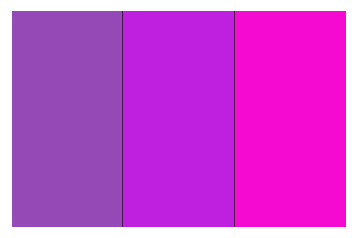

split


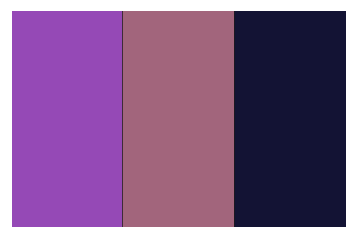

far


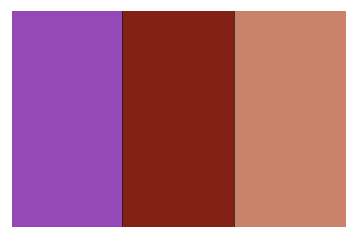

In [880]:
for i in range(50*1141, 50*1141+50):
    train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {}".format(
        train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i]))
    train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
    train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

(array([17.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0., 17.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

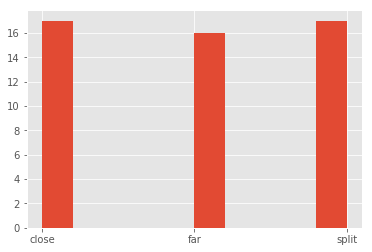

In [882]:
plt.hist(cp_preds_str_subword_50sample[50*1141:50*1141+50])

Red | prag: split | bl: far | correct: True


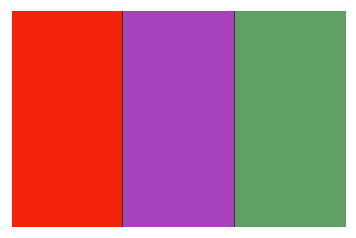

close


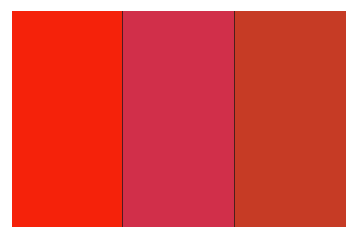

split


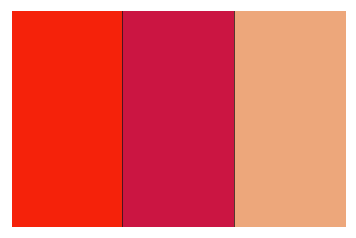

In [938]:
i=34*50+1
train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {} | correct: {}".format(
    train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i],
    train_cp_data_50sample[2*50*(i//50) + (i//50)].outcome))
train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

In [1034]:
just_baseline_success = np.where((modes_result.reshape(-1) != np.array(true_train_conditions))
         & (cp_preds_str_subword_baseline == np.array(true_train_conditions)))

In [928]:
just_baseline_success[0][:10]

array([ 0,  3,  7,  8, 17, 18, 27, 34, 43, 44])

In [918]:
j=0
train_data[j].caption, train_data[j].outcome, train_data[j].condition 

('The darker blue one', False, 'close')

Caption: grey
Listener Sucess: True
Actual: far
Prag Pred: (array(['close'], dtype='<U5'), array([20]))


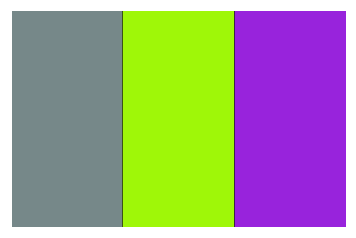

In [939]:
j=43
train_data.display_custom_game(train_data[j].colors, "Caption: {}\nListener Sucess: {}\nActual: {}\nPrag Pred: {}".format(
    train_data[j].caption, train_data[j].outcome, train_data[j].condition, (modes_result[j], modes_counts[j])))

In [1035]:
mistake_types_pragma = Counter()
for i in just_baseline_success[0]:
    mistake_types_pragma[(train_data[i].condition, modes_result[i][0])] += 1

In [1036]:
mistake_types_pragma.most_common()

[(('split', 'close'), 786),
 (('far', 'close'), 688),
 (('far', 'split'), 620),
 (('close', 'split'), 366),
 (('split', 'far'), 114),
 (('close', 'far'), 96)]

In [ ]:
# This doesn't really make too much sense. Why are there so many far conditions being mistaken for close?

# I'm curious to try this in the other direction as well


In [1033]:
just_prag_success = np.where((modes_result.reshape(-1) == np.array(true_train_conditions))
         & (cp_preds_str_subword_baseline != np.array(true_train_conditions)))

In [1037]:
just_prag_success[0][:20]

array([ 2,  6, 13, 20, 21, 25, 32, 33, 36, 37, 39, 40, 46, 55, 60, 69, 71,
       75, 80, 82])

In [1038]:
len(just_prag_success[0])/len(train_data)

0.25943185445260136

In [1039]:
len(just_baseline_success[0])/len(train_data)

0.17044366421959783

In [1040]:
baseline_prag_failure = np.where((modes_result.reshape(-1) != np.array(true_train_conditions))
         & (cp_preds_str_subword_baseline != np.array(true_train_conditions)))

In [1041]:
len(baseline_prag_failure[0])/len(train_data)

0.27883817427385893

In [1042]:
baseline_prag_success = np.where((modes_result.reshape(-1) == np.array(true_train_conditions))
         & (cp_preds_str_subword_baseline == np.array(true_train_conditions)))

In [1043]:
len(baseline_prag_success[0])/len(train_data)

0.29128630705394193

In [1044]:
0.25943185445260136 + 0.17044366421959783 + 0.27883817427385893 + 0.29128630705394193

1.0

Caption: brown. not the yellow one or classic brown one, the weirder one
Listener Sucess: True
Actual: close
Baseline Pred: split


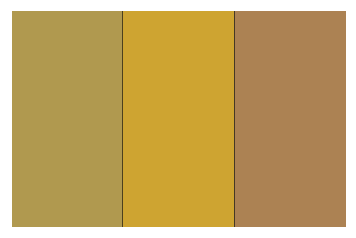

In [1045]:
j=32
train_data.display_custom_game(train_data[j].colors, "Caption: {}\nListener Sucess: {}\nActual: {}\nBaseline Pred: {}".format(
    train_data[j].caption, train_data[j].outcome, train_data[j].condition, cp_preds_str_subword_baseline[j]))

In [ ]:
# baseline doesn't seem to understand the word "one"

In [971]:
all_caption_lens = [len(de.caption) for de in train_data]

In [972]:
all_caption_lens[:10]

[19, 6, 33, 4, 11, 9, 9, 10, 11, 4]

In [976]:
np.where(np.array(all_caption_lens)==283)

(array([12980]),)

In [977]:
train_data[12980].caption

"yes, caca green, brown caca, barney? ~ thank you. i take it your a bread on a certain forum ~ ahhhh. bummer, i saw someone talk about having a great partner on a forum ~ let's see how we can get through this. then hopefully we will meet again ~ thank you. you were awesome too ~ grey"

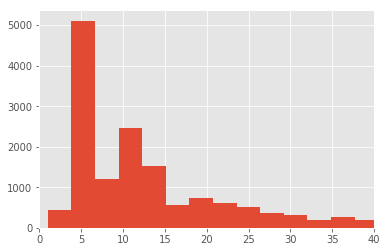

In [987]:
plt.hist(all_caption_lens, bins=100)
plt.xlim((0, 40))
plt.show()

In [997]:
cp_preds_str_subword_baseline[12983]

'split'

12983) Game: 6089-c Round: 6
caca green, but with mustard on it


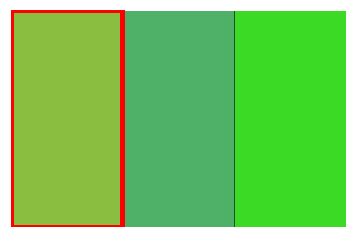

In [996]:
train_data.display_game(12983)

In [1006]:
close_cap_len_baseline_preds = np.array(all_caption_lens)[cp_preds_str_subword_baseline == "close"]

In [1007]:
split_cap_len_baseline_preds = np.array(all_caption_lens)[cp_preds_str_subword_baseline == "split"]

In [1008]:
far_cap_len_baseline_preds = np.array(all_caption_lens)[cp_preds_str_subword_baseline == "far"]

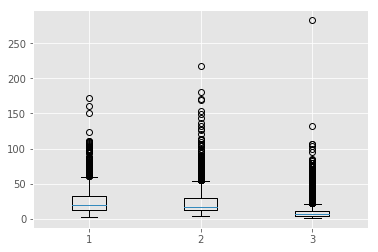

In [1010]:
plt.boxplot([close_cap_len_baseline_preds, split_cap_len_baseline_preds, far_cap_len_baseline_preds])
plt.show()

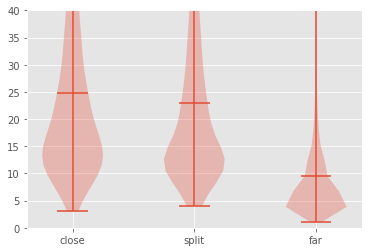

In [1018]:
plt.violinplot([close_cap_len_baseline_preds, split_cap_len_baseline_preds, far_cap_len_baseline_preds],
               showmeans=True)
plt.ylim((0, 40))
plt.xticks((1, 2, 3), ("close", "split", "far"))
plt.show()

In [ ]:
# so it appears "far" is the one that depends on length the most. This matches up with far having the highest F1 score.
# but that said,

In [1046]:
mistake_types_baseline = Counter()
for i in just_prag_success[0]:
    mistake_types_baseline[(train_data[i].condition, cp_preds_str_subword_baseline[i])] += 1

In [1047]:
mistake_types_baseline.most_common()

[(('split', 'far'), 1144),
 (('close', 'split'), 1143),
 (('close', 'far'), 1033),
 (('split', 'close'), 418),
 (('far', 'split'), 210),
 (('far', 'close'), 116)]

In [ ]:
# wow, the baseline makes a lot of mistakes. The top 2 most common mistakes make the most sense. 
# the mistaking a close condition for a far condition doesn't particularly make sense, and it is the opposite
# of the common mistake the pragmatic method made mistaking far for close.

# I wonder how this looks compared to pragmatics' predictions? 

# I'm not really making much progress here and I'm having trouble staying focused on the narritive. I'm going to 
# take a bit of a break and walk around I think.

In [1023]:
just_prag_success

(array([    6,    12,    13, ..., 15643, 15653, 15662]),)

In [1024]:
cp_preds_str_subword_baseline[6]

'far'

In [1025]:
train_data[6].condition

'split'

In [1056]:
# confusion matrices
confusion_matrix(['a', 'b', 'c', 'b'], ['a', 'c', 'b', 'c'], labels=['a', 'b', 'c'])

array([[1, 0, 0],
       [0, 0, 2],
       [0, 1, 0]])

In [1069]:
print(confusion_matrix(cp_truth_str_50sample, cp_preds_str_subword_50sample, labels=['close', 'split', 'far']))

[[139396  70696  47858]
 [ 88081 111079  62890]
 [ 59843  58086 145321]]


In [1068]:
print(confusion_matrix(cp_truth_str, cp_preds_str_subword_baseline, labels=['close', 'split', 'far']))

[[1435 1738 1986]
 [ 878 1640 2723]
 [ 414  693 4158]]


In [1070]:
baseline_pred_far_actual_close = []
for i in just_prag_success[0]:
    if train_data[i].condition == "close" and cp_preds_str_subword_baseline[i] == "far":
        baseline_pred_far_actual_close.append(i)
        #print("hello")
        
#     unintuitive_mistakes.append(i)
#     mistake_types_baseline[(train_data[i].condition, cp_preds_str_subword_baseline[i])] += 1

In [1071]:
len(baseline_pred_far_actual_close)

1033

In [1072]:
baseline_pred_far_actual_close[:10]

[20, 37, 39, 71, 80, 89, 103, 107, 109, 115]

Caption: Neon pink
Listener Sucess: False
Actual: close
Baseline Pred: far


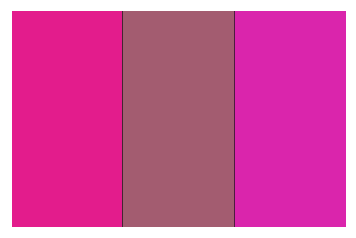

Caption: light brown
Listener Sucess: True
Actual: close
Baseline Pred: far


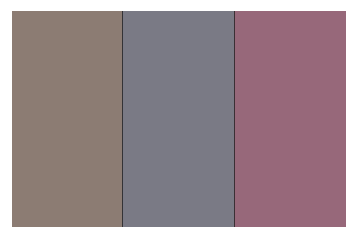

Caption: blue
Listener Sucess: True
Actual: close
Baseline Pred: far


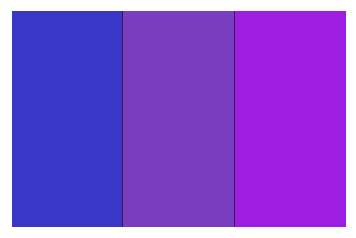

Caption: brightest pink
Listener Sucess: True
Actual: close
Baseline Pred: far


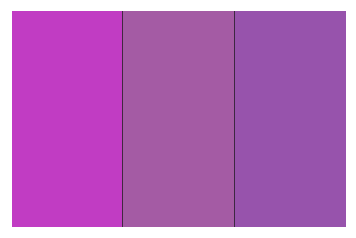

Caption: olive
Listener Sucess: True
Actual: close
Baseline Pred: far


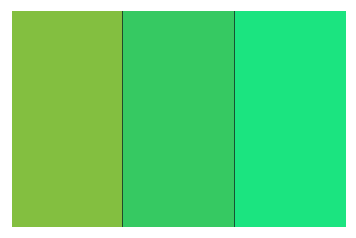

Caption: yellow
Listener Sucess: True
Actual: close
Baseline Pred: far


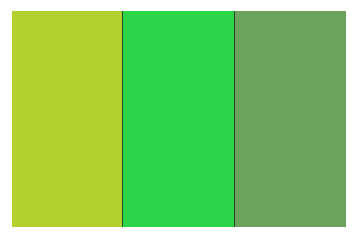

Caption: gray
Listener Sucess: True
Actual: close
Baseline Pred: far


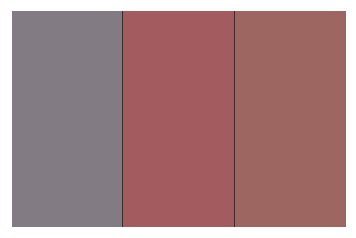

Caption: the slightly darker pink
Listener Sucess: True
Actual: close
Baseline Pred: far


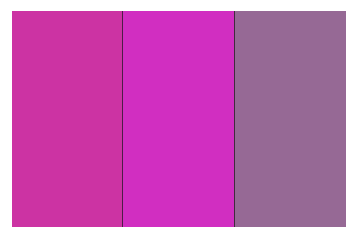

Caption: lime green
Listener Sucess: True
Actual: close
Baseline Pred: far


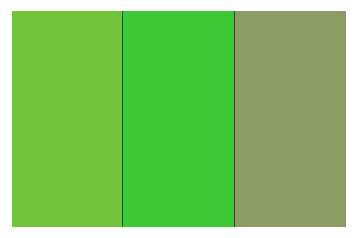

Caption: light green
Listener Sucess: True
Actual: close
Baseline Pred: far


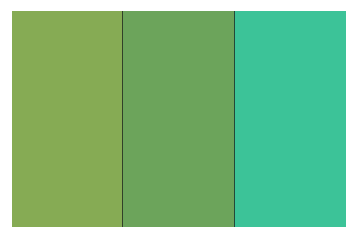

In [1074]:
for j in baseline_pred_far_actual_close[:10]:
    train_data.display_custom_game(train_data[j].colors, "Caption: {}\nListener Sucess: {}\nActual: {}\nBaseline Pred: {}".format(
        train_data[j].caption, train_data[j].outcome, train_data[j].condition, cp_preds_str_subword_baseline[j]))

In [1075]:
prag_pred_close_actual_far = []
for i in just_baseline_success[0]:
    if train_data[i].condition == "far" and modes_result[i][0] == "close":
        prag_pred_close_actual_far.append(i)
    # mistake_types_pragma[(train_data[i].condition, modes_result[i][0])] += 1

In [1076]:
len(prag_pred_close_actual_far)

688

Caption: The fuchsia box
Listener Sucess: True
Actual: far
Prag Pred: ('close', 29)


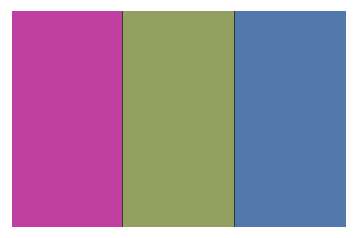

Caption: purplish blue
Listener Sucess: True
Actual: far
Prag Pred: ('close', 31)


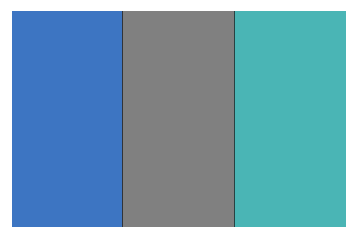

Caption: Not an apple, but an...
Listener Sucess: True
Actual: far
Prag Pred: ('close', 25)


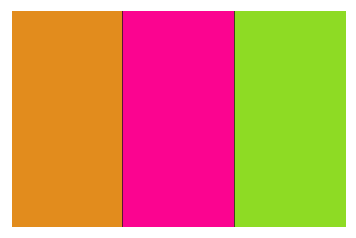

Caption: the green one
Listener Sucess: True
Actual: far
Prag Pred: ('close', 36)


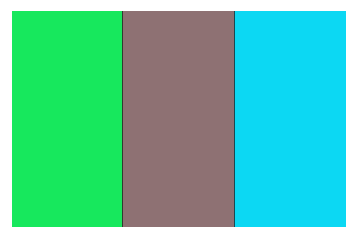

Caption: color of the sky
Listener Sucess: True
Actual: far
Prag Pred: ('close', 31)


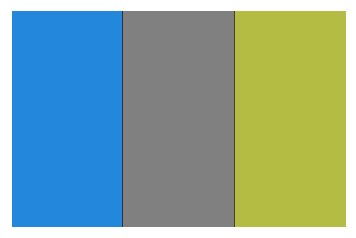

Caption: sky
Listener Sucess: True
Actual: far
Prag Pred: ('close', 22)


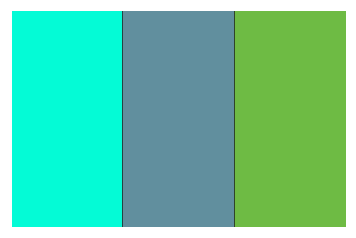

Caption: purple gray
Listener Sucess: True
Actual: far
Prag Pred: ('close', 19)


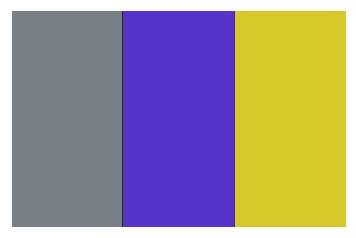

Caption: barney
Listener Sucess: True
Actual: far
Prag Pred: ('close', 28)


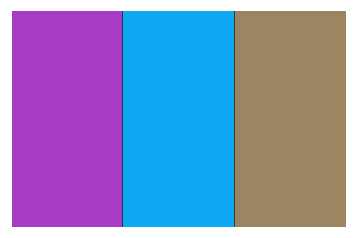

Caption: brown
Listener Sucess: True
Actual: far
Prag Pred: ('close', 25)


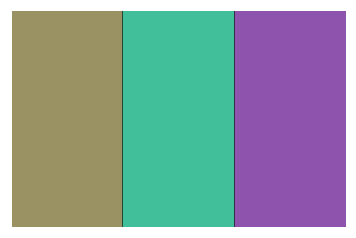

Caption: the pink one
Listener Sucess: True
Actual: far
Prag Pred: ('close', 25)


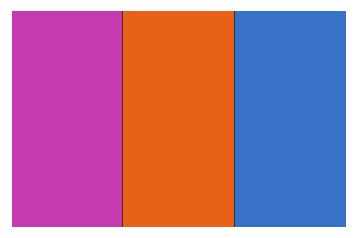

In [1080]:
for j in prag_pred_close_actual_far[200:300:10]:
    train_data.display_custom_game(train_data[j].colors, "Caption: {}\nListener Sucess: {}\nActual: {}\nPrag Pred: {}".format(
        train_data[j].caption, train_data[j].outcome, train_data[j].condition, (modes_result[j][0], modes_counts[j][0])))

In [1081]:
prag_pred_close_actual_far[210]

4164

purplish blue | prag: close | bl: far | correct: True


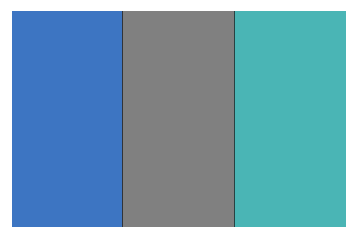

close


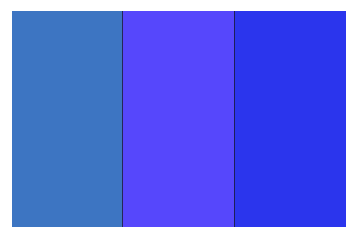

split


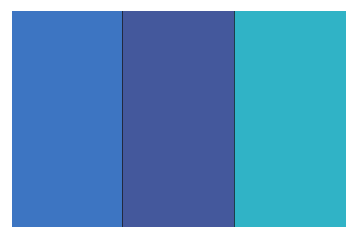

In [1084]:

i=4164*50 + 3
train_data.display_custom_game(train_cp_data_50sample[2*50*(i//50) + (i//50)].colors, "{} | prag: {} | bl: {} | correct: {}".format(
    train_cp_data_50sample[2*50*(i//50) + (i//50)].caption, cp_preds_str_subword_50sample[i], cp_preds_str_subword_baseline_rep[i],
    train_cp_data_50sample[2*50*(i//50) + (i//50)].outcome))
train_data.display_custom_game(train_cp_data_50sample[2*i+1 + (i//50)].colors, train_cp_data_50sample[2*i+1 + (i//50)].condition)
train_data.display_custom_game(train_cp_data_50sample[2*i+2 + (i//50)].colors, train_cp_data_50sample[2*i+2 + (i//50)].condition)

In [1098]:
train_cp_data_50sample[2*i+1 + (i//50)].colors

[hsl: [215, 52, 50], rgb [61, 117, 195], hsv [215, 68.42105263157895, 76.0],
 hsl: [245, 97.0, 63.0], rgb [86.0, 71.0, 253.0], hsv [245, 72.58570128425524, 98.89],
 hsl: [237, 84.0, 55.0], rgb [43.0, 53.0, 238.0], hsv [237, 81.4655172413793, 92.8]]

In [1093]:
color_featurizers.color_phi_fourier(train_cp_data_50sample[2*i+1 + (i//50)].colors[0].hsv_norm, "hsv_norm")

array([ 1.        , -0.7289686 ,  0.06279052, -0.54694813, -0.17437184,
        0.80117136, -0.40169543,  0.9197133 , -0.9391889 , -0.81915206,
        0.98977625, -0.6238796 ,  0.92821264, -0.42195213, -0.31303295,
       -0.19621637, -0.5282044 ,  0.9663052 ,  0.34202015, -0.8925858 ,
        0.959314  , -0.9737465 ,  0.86565775, -0.2883282 ,  0.7231575 ,
       -0.05435399, -0.6439128 ,  0.        , -0.6845471 ,  0.9980267 ,
       -0.8371665 ,  0.9846799 , -0.598435  ,  0.91577333, -0.39259058,
       -0.3434009 ,  0.57357645,  0.14262894, -0.7815205 ,  0.37205005,
       -0.9066181 ,  0.94974226, -0.9805606 ,  0.8491173 , -0.25739908,
       -0.9396926 ,  0.45087755,  0.28234145,  0.22763535,  0.5006363 ,
       -0.95753163,  0.6906831 , -0.99852175,  0.76509887], dtype=float32)

In [1096]:
output_to_likelihood(s0_subword.predict([X_assess_subword_cp_50sample[2*i+1 + (i//50)]]), y_assess_subword_cp_50sample)

array([-27.890379], dtype=float32)

In [1097]:
s0_subword.predict([X_assess_subword_cp_50sample[2*i+1 + (i//50)]])

[[tensor([[-22.3626,  -3.5775,  -2.2502,  -1.4132,  -6.3624,  -6.3585,  -3.1486,
            -2.3069,  -7.9708,  -9.1516,  -9.1528,  -9.4405,  -9.9845,  -6.4305,
           -11.4007,  -2.5504, -10.7868,  -9.6339,  -7.8189,  -4.5969,  -9.3506,
            -8.9398,  -8.6757,  -9.7563,  -9.8708,  -7.4313,  -7.6694,  -3.2107,
            -3.4299,  -7.9895,  -7.6762,  -8.8383,  -9.7745,  -9.0805,  -8.4902,
            -9.3315,  -2.0292,  -8.9674,  -5.5013, -11.1066,  -8.8390,  -8.7915,
            -8.3732,  -8.3884, -10.3203,  -4.3138,  -5.2186, -11.2925,  -7.8630,
            -8.3985,  -6.7740,  -7.4708,  -9.2997,  -9.7551,  -9.1254,  -9.8962,
            -6.9355,  -8.4301, -10.6840,  -9.2264,  -4.3492,  -4.9975, -10.1327,
            -9.2832,  -8.5229,  -6.9884,  -8.8106,  -9.6448,  -4.9841, -10.3303,
            -9.9772,  -4.2574,  -9.3503,  -9.8489, -12.2567, -11.8864, -11.8657,
           -10.2442,  -5.3697, -10.6435, -11.8544,  -7.9647,  -2.7690,  -9.5212,
            -4.3797,  -4.753